# LATAM Airlines

**"Probabilidad de atraso de los vuelos que aterriza o despegan"**

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL.

# Instalar las dependencias


In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#!pip install pycaret

# Entendimiento inicial de los datos

## Cargar Librerias

In [3]:
%matplotlib inline

import re
import random
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

from scipy.stats import kstest

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(color_codes=True)
sns.set(style='darkgrid')

from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder

#from pycaret.classification import *

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,ParameterGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import metrics as mt
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score

/home/laren.osorio/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


## Definición de funciones

In [4]:
def cross_target(data,var,target):
    """Calcula los porcentajes de conversión del target por cada categoria de la variable"""
    
    base = data[[var,target]]#.fillna("NULOS")
    print("----------------------------------------------------------------")
    print("---- Var: ",var)
    print(pd.concat([pd.DataFrame(base[:][var].value_counts(dropna=False).index, columns = ['Atributo']),
           pd.DataFrame(base[:][var].value_counts(dropna=False).values, columns = ['Cantidad']),
           pd.DataFrame(100*base[:][var].value_counts(dropna=False).values/len(base), columns = ['%Total'])], axis = 1))
    
    temp = pd.DataFrame(np.array(base.groupby(var, as_index = False, axis = 0)[target].mean()), 
                         columns = [var,"% ratio_conv"])
    temp["% ratio_conv"] = temp["% ratio_conv"]*100
    temp = temp.sort_values(by = ['% ratio_conv'], ascending = [False])
    print("")
    print(temp)


def plot_graph_initial(df, meta):
  """Graficos para el analisis univariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(35,7))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if (t.__class__.__name__=="CategoricalDtype"):
          fa=df[v].value_counts() 
          fr=fa/len(df[v]) 
          #Barras
          plt.subplot(1,2,1)
          plt.bar(fa.index,fa)
          plt.xticks(fa.index,rotation=90)
          plt.title(v)
          #Pie
          plt.subplot(1,2,2)
          plt.pie(fr,autopct='%1.1f%%', shadow=True, startangle=90)
          plt.legend(fr.index,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")

      else:
          #Histograma
          plt.subplot(1,2,1)
          plt.hist(df[v].dropna(),bins=100)
          plt.title(v)
          #Boxplot
          plt.subplot(1,2,2)
          plt.boxplot(df[v])
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")
      plt.show()


def plot_graph_bivariable(df2, meta, y):
  """Graficos para el analisis bivariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(35,7))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if v==y: break
      print(v)
      if (t.__class__.__name__=="CategoricalDtype"):        
          g=df2.groupby([df2[y],v]).size().unstack(0)
          tf= g[1]/(g[0]+g[1])
          #tf=tf.sort_values(ascending=False)
          c1 = g[0]
          c2 = g[1]
          width = 0.9   # the width of the bars: can also be len(x) sequence

          p1 = plt.bar(g.index, c1, width)
          p2 = plt.bar(g.index, c2, width,bottom=c1)

          plt.ylabel('Freq')
          plt.title('Bivariado')
          plt.xticks(g.index,rotation=90)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red',marker ="o")
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      else:
          d=pd.qcut(df2[v], 10, duplicates='drop',labels=False)     
          g=df2.groupby([y, d]).size().unstack(0)   
          N = len(g)
          mMeans = g[0]
          wMeans = g[1]
          tf= g[1]/(g[0]+g[1])
          ind = np.arange(N)    # the x locations for the groups

          width = 0.9       # the width of the bars: can also be len(x) sequence        
          p1 = plt.bar(ind, mMeans, width)
          p2 = plt.bar(ind, wMeans, width,
                       bottom=mMeans)

          plt.ylabel('Freq')
          plt.xlabel("Deciles " + v)
          plt.title('Bivariado: ' + v + " vs " + y)
          plt.xticks(ind, np.arange(1,10,1),rotation=90)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      plt.show()



def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de valores vacios en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)


def clean_outlier_perc(df, column, value_perc):
  """Genera el reemplazo de valores outliers superiores por un percentile personalizado"""
  
  top_value = df[column].quantile(value_perc) 
  df.loc[df[column] >= top_value, column] = top_value


def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(20, 18))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


## Lectura y validación de datos

Ruta donde se encuentra alojado el dataset del caso

In [5]:
url_data='../data/'

**Lectura y carga de la data**

In [6]:
dfVuelos=pd.read_csv(url_data+'dataset_SCL.csv', na_values='?', low_memory=False)

**Validar la correcta lectura del dataframe**

Se observa que se tienen **68206 filas** y **18 columnas** de los tipos int64(3), object(15). Se tiene que modificar el tipo de dato de las variables **Fecha-I** y **Fecha-O** para su posterior tratamiento

In [7]:
dfVuelos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Mostrar los 5 primeros registros

In [8]:
dfVuelos.head(5)

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
0  2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   226   
1  2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   226   
2  2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   226   
3  2017-01-04 23:30:00   226  SCEL  KMIA   AAL  2017-01-04 23:33:00   226   
4  2017-01-05 23:30:00   226  SCEL  KMIA   AAL  2017-01-05 23:28:00   226   

  Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO              OPERA  \
0  SCEL  KMIA   AAL    1    1  2017    Domingo         I  American Airlines   
1  SCEL  KMIA   AAL    2    1  2017      Lunes         I  American Airlines   
2  SCEL  KMIA   AAL    3    1  2017     Martes         I  American Airlines   
3  SCEL  KMIA   AAL    4    1  2017  Miercoles         I  American Airlines   
4  SCEL  KMIA   AAL    5    1  2017     Jueves         I  American Airlines   

   SIGLAORI SIGLADES  
0  Santiago    Miami  
1  Santiago    Miami  
2  Santiago    Miami  
3  Santiago    Miami  
4  Santiago    Miami

## Estudiar las dimensiones del dataset

In [9]:
dfVuelos.shape

(68206, 18)

Se tienen 68206 filas y 18 columnas

In [10]:
dfVuelos.size

1227708

No se tiene un **id** correspondiente a cada vuelo. Como parte de las indicaciones cada fila corresponde a un vuelo que aterrizó o despegó de SCL, por lo que cada fila será tomado como un único registro

## Evaluar el tipo de Problema

**Vemos que es un caso de aprendizaje supervisado de clasificación para predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)**

In [11]:
dfVuelos.head(3)

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
0  2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   226   
1  2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   226   
2  2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   226   

  Ori-O Des-O Emp-O  DIA  MES   AÑO   DIANOM TIPOVUELO              OPERA  \
0  SCEL  KMIA   AAL    1    1  2017  Domingo         I  American Airlines   
1  SCEL  KMIA   AAL    2    1  2017    Lunes         I  American Airlines   
2  SCEL  KMIA   AAL    3    1  2017   Martes         I  American Airlines   

   SIGLAORI SIGLADES  
0  Santiago    Miami  
1  Santiago    Miami  
2  Santiago    Miami

## Variable Objetivo

**Armado del target**

Se debe construir el target **atraso_15** en base a una nueva variable llamada **dif_min**. La definición del target obedece:

*   dif_min<15    : Si la diferencia en minutos entre Fecha-O y Fecha-I es menor de 15 minutos entonces atraso_15=0
*   dif_min>15    : Si la diferencia en minutos entre Fecha-O y Fecha-I es mayor de 15 minutos entonces atraso_15=1

Finalmente tomando en cuenta una diferencia de 15 min se construye el target **atraso_15**. Esta variable **bivariada** será usada para predecir si un vuelo se retrasa o no.

Se convierten los campos **Fecha-O** y **Fecha-I** en variables del tipo *datetime* para su posterior tratamiento.

In [12]:
dfVuelos['Fecha-O']=pd.to_datetime(dfVuelos['Fecha-O'])
dfVuelos['Fecha-I']=pd.to_datetime(dfVuelos['Fecha-I'])

Crear la variables **dif_min** tomando las variables **Fecha-O** y **Fecha-I**

In [13]:
dfVuelos['dif_min']=dfVuelos['Fecha-O']-dfVuelos['Fecha-I']
dfVuelos['dif_min']=dfVuelos['dif_min']/np.timedelta64(1,'m')

Se crea la variable **atraso_15** en base a la variable **dif_min**

In [14]:
dfVuelos['atraso_15'] = dfVuelos['dif_min'].map(lambda x: '1' if x>15 else '0')

Se valida la cantidad de valores para cada categoría del target. Se observa que 12614 (**~18,4%**) corresponde el target de análisis

In [15]:
# Validación
dfVuelos['atraso_15'].value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

In [16]:
dfVuelos[['dif_min','atraso_15']]

dif_min atraso_15
0          3.0         0
1          9.0         0
2          9.0         0
3          3.0         0
4         -2.0         0
...        ...       ...
68201     46.0         1
68202     16.0         1
68203     40.0         1
68204     13.0         0
68205      9.0         0

[68206 rows x 2 columns]

## Describir el Dataset

El primer alcance descriptivo de los datos es el siguiente:

*   **Viernes** es el dia de la semana con más fechas programadas de vuelo. Representa el **15%**

*   **Grupo LATAM** es el operador con la mayor cantidad de vuelos operados. Representa el **60%**.

*   **TIPOVUELO**. Los vuelos Nacionales(N) representan el **54%** del total de vuelos

*   **SIGLAORI**. Todos los vuelos salen de la ciudad de Santiago, esta variable con una única categoría será eliminada posteriormente ya que por tener **cero varianza** no aporta en el proceso de aprendizaje.

*   La variable **Vlo-O** tiene un valor nulo, el resto de variables no tiene valores vacios.

*   **DIANOM** que obedece al día de la semana es correspondiente al valor de la variable **DIA**. Para fines descriptivos se usará **DIANOM**

*   **MES** y **AÑO** necesitan ser transformados en variables categóricas, con ello  la posibilidad de conocer el mes y el año que tiene menos y más vuelos programados y operados.


In [17]:
dfVuelos.describe(include =['int64','object','float64'])

Vlo-I  Ori-I  Des-I  Emp-I  Vlo-O  Ori-O  Des-O  Emp-O           DIA  \
count   68206  68206  68206  68206  68205  68206  68206  68206  68206.000000   
unique    584      1     64     30    861      1     63     32           NaN   
top       174   SCEL   SCFA    LAN    174   SCEL   SCFA    LAN           NaN   
freq      686  68206   5787  37611    649  68206   5786  20988           NaN   
mean      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     15.714790   
std       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      8.782886   
min       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      1.000000   
25%       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      8.000000   
50%       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     16.000000   
75%       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     23.000000   
max       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     31.000000   

                 MES           AÑO   DIANOM TIPOVUELO        OPERA  SIGLAORI  \
count   68206.000000  68206.000000    68206     68206        68206     68206   
unique           NaN           NaN        7         2           23         1   
top              NaN           NaN  Viernes         N  Grupo LATAM  Santiago   
freq             NaN           NaN    10292     36966        40892     68206   
mean        6.622585   2017.000029      NaN       NaN          NaN       NaN   
std         3.523321      0.005415      NaN       NaN          NaN       NaN   
min         1.000000   2017.000000      NaN       NaN          NaN       NaN   
25%         3.000000   2017.000000      NaN       NaN          NaN       NaN   
50%         7.000000   2017.000000      NaN       NaN          NaN       NaN   
75%        10.000000   2017.000000      NaN       NaN          NaN       NaN   
max        12.000000   2018.000000      NaN       NaN          NaN       NaN   

            SIGLADES       dif_min atraso_15  
count          68206  68206.000000     68206  
unique            62           NaN         2  
top     Buenos Aires           NaN         0  
freq            6335           NaN     55592  
mean             NaN      9.110855       NaN  
std              NaN     19.313387       NaN  
min              NaN    -14.000000       NaN  
25%              NaN     -1.000000       NaN  
50%              NaN      4.000000       NaN  
75%              NaN     12.000000       NaN  
max              NaN    161.000000       NaN

# Data Wrangling

## Registros Repetidos

In [18]:
dfVuelos.shape

(68206, 20)

In [19]:
dfVuelos.drop_duplicates(inplace = True)

In [20]:
dfVuelos.shape

(68206, 20)

## Renombramiento de variables

In [21]:
dfVuelos.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'dif_min', 'atraso_15'],
      dtype='object')

Se renombra las variables para un mejor entendimiento

In [22]:
dfVuelos.rename(columns={
   'Fecha-I':'fecVuelProg',
   'Vlo-I':'nroVuelProg',
   'Ori-I': 'codCiudadOrigProg',
   'Des-I': 'codCiudadDestProg',
   'Emp-I': 'codAerolineaVuelProg',
   'Fecha-O':'fecVuelOperado',
   'Vlo-O':'nroVuelOperado',
   'Ori-O': 'codCiudadOrigOperado',
   'Des-O': 'codCiudadDestOperado',
   'Emp-O': 'codAerolineaVuelOperado',
   'DIA': 'diaVuelOperado',
   'MES': 'mesVuelOperado',
   'AÑO': 'anioVuelOperado',
   'DIANOM':'diaSemVuelOperado',
   'TIPOVUELO': 'tipVuelo',
   'OPERA': 'nombAerolineaOperado',
   'SIGLAORI': 'nombCiudadOrig',
   'SIGLADES': 'nombCiudadDest'},inplace=True)

In [23]:
dfVuelos.columns

Index(['fecVuelProg', 'nroVuelProg', 'codCiudadOrigProg', 'codCiudadDestProg',
       'codAerolineaVuelProg', 'fecVuelOperado', 'nroVuelOperado',
       'codCiudadOrigOperado', 'codCiudadDestOperado',
       'codAerolineaVuelOperado', 'diaVuelOperado', 'mesVuelOperado',
       'anioVuelOperado', 'diaSemVuelOperado', 'tipVuelo',
       'nombAerolineaOperado', 'nombCiudadOrig', 'nombCiudadDest', 'dif_min',
       'atraso_15'],
      dtype='object')

## Remover nulos

In [24]:
fx_porc_missings(dfVuelos, only_missings=True)

n_nulos    %Total
nroVuelOperado        1  0.001466

La variable **nroVuelOperado** es una variable cualitativa. Para este caso se **imputa por su moda**

In [25]:
dfVuelos['nroVuelOperado'].mode()[0]

'174'

In [26]:
dfVuelos['nroVuelOperado'].fillna(dfVuelos['nroVuelOperado'].mode()[0],inplace=True)

Se observan que todo el dataframe no contiene variables con valores nulos

In [27]:
fx_porc_missings(dfVuelos, only_missings=True)

Empty DataFrame
Columns: [n_nulos, %Total]
Index: []

## Creación de nuevas variables

En este paso se crear las dos variables restantes solicitadas en el desafío: **temporada_alta** y **periodo_dia**, con el fin de darles posterior tratamiento. Las variables **dif_min** y **atraso_15** han sido creadas en la sección **Variable Objetivo**

### Se crea la variable **temporada_alta**

In [28]:
dfVuelos["temporada_alta"]='0'

cond1 =( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-12-15') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(lambda x: x+1).apply(str) + '-03-03') )
cond2 = ( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-07-15') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-07-31') )
cond3 = ( (dfVuelos['fecVuelProg'] >= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-09-11') & \
 (dfVuelos['fecVuelProg']  <= dfVuelos['fecVuelProg'].dt.year.apply(str) + '-09-30') )
dfVuelos.loc[(cond1 | cond2 | cond3) , 'temporada_alta'] = '1'

In [29]:
# Validación
dfVuelos['temporada_alta'].value_counts()

0    58051
1    10155
Name: temporada_alta, dtype: int64

### Se crea la variable **periodo_dia**

In [30]:
dfVuelos['periodo_dia'] = ""

index = pd.DatetimeIndex(dfVuelos['fecVuelProg'])
dfVuelos.loc[index.indexer_between_time('5:00','11:59'),"periodo_dia"]="mañana"
dfVuelos.loc[index.indexer_between_time('12:00','18:59'),"periodo_dia"]="tarde"
dfVuelos.loc[index.indexer_between_time('19:00','04:59'),"periodo_dia"]="noche"

Validación para ver si las horas corresponden correctamente con la variable **periodo_dia** creada

In [31]:
dfVuelos['horaFecI']=dfVuelos['fecVuelProg'].dt.hour
dfVuelos.groupby(by=['periodo_dia','horaFecI']).size()

periodo_dia  horaFecI
mañana       5           2514
             6           4199
             7           4882
             8           4363
             9           3264
             10          2462
             11          3668
noche        0           1082
             1           1573
             2            641
             3            505
             4           1092
             19          3591
             20          2935
             21          2312
             22          2320
             23          1297
tarde        12          3412
             13          3675
             14          3836
             15          3884
             16          3072
             17          3465
             18          4162
dtype: int64

Se verifica que las horas corresponden de manera correcta con las partes del día.

In [32]:
dfVuelos["periodo_dia"].value_counts(normalize = True)*100

tarde     37.395537
mañana    37.169750
noche     25.434712
Name: periodo_dia, dtype: float64

Se observa que se tiene un porcentaje menor (**~25%**) de personas que vuelan durante la noche. Siendo un porcentaje mayor durante la mañana y la tarde

### Exportar las variables creadas

Se guarda y se exporta los variables creadas en el archivo **synthetic_features.csv**. Se mantiene el index para posteriores cruces

In [33]:
dfVuelos[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv(url_data+'synthetic_features.csv',sep=',')

In [34]:
dfVuelos.head(5)

fecVuelProg nroVuelProg codCiudadOrigProg codCiudadDestProg  \
0 2017-01-01 23:30:00         226              SCEL              KMIA   
1 2017-01-02 23:30:00         226              SCEL              KMIA   
2 2017-01-03 23:30:00         226              SCEL              KMIA   
3 2017-01-04 23:30:00         226              SCEL              KMIA   
4 2017-01-05 23:30:00         226              SCEL              KMIA   

  codAerolineaVuelProg      fecVuelOperado nroVuelOperado  \
0                  AAL 2017-01-01 23:33:00            226   
1                  AAL 2017-01-02 23:39:00            226   
2                  AAL 2017-01-03 23:39:00            226   
3                  AAL 2017-01-04 23:33:00            226   
4                  AAL 2017-01-05 23:28:00            226   

  codCiudadOrigOperado codCiudadDestOperado codAerolineaVuelOperado  \
0                 SCEL                 KMIA                     AAL   
1                 SCEL                 KMIA                     AAL   
2                 SCEL                 KMIA                     AAL   
3                 SCEL                 KMIA                     AAL   
4                 SCEL                 KMIA                     AAL   

   diaVuelOperado  mesVuelOperado  anioVuelOperado diaSemVuelOperado tipVuelo  \
0               1               1             2017           Domingo        I   
1               2               1             2017             Lunes        I   
2               3               1             2017            Martes        I   
3               4               1             2017         Miercoles        I   
4               5               1             2017            Jueves        I   

  nombAerolineaOperado nombCiudadOrig nombCiudadDest  dif_min atraso_15  \
0    American Airlines       Santiago          Miami      3.0         0   
1    American Airlines       Santiago          Miami      9.0         0   
2    American Airlines       Santiago          Miami      9.0         0   
3    American Airlines       Santiago          Miami      3.0         0   
4    American Airlines       Santiago          Miami     -2.0         0   

  temporada_alta periodo_dia  horaFecI  
0              0       noche        23  
1              0       noche        23  
2              0       noche        23  
3              0       noche        23  
4              0       noche        23

Eliminar la variable **horaFecI** que no será empleada para el análisis posterior

In [35]:
dfVuelos.drop('horaFecI', axis=1, inplace=True)

# EDA

## Analisis Preliminar Univariado

In [36]:
df_analisis = dfVuelos.copy()

In [37]:
df_analisis.head(5)

fecVuelProg nroVuelProg codCiudadOrigProg codCiudadDestProg  \
0 2017-01-01 23:30:00         226              SCEL              KMIA   
1 2017-01-02 23:30:00         226              SCEL              KMIA   
2 2017-01-03 23:30:00         226              SCEL              KMIA   
3 2017-01-04 23:30:00         226              SCEL              KMIA   
4 2017-01-05 23:30:00         226              SCEL              KMIA   

  codAerolineaVuelProg      fecVuelOperado nroVuelOperado  \
0                  AAL 2017-01-01 23:33:00            226   
1                  AAL 2017-01-02 23:39:00            226   
2                  AAL 2017-01-03 23:39:00            226   
3                  AAL 2017-01-04 23:33:00            226   
4                  AAL 2017-01-05 23:28:00            226   

  codCiudadOrigOperado codCiudadDestOperado codAerolineaVuelOperado  \
0                 SCEL                 KMIA                     AAL   
1                 SCEL                 KMIA                     AAL   
2                 SCEL                 KMIA                     AAL   
3                 SCEL                 KMIA                     AAL   
4                 SCEL                 KMIA                     AAL   

   diaVuelOperado  mesVuelOperado  anioVuelOperado diaSemVuelOperado tipVuelo  \
0               1               1             2017           Domingo        I   
1               2               1             2017             Lunes        I   
2               3               1             2017            Martes        I   
3               4               1             2017         Miercoles        I   
4               5               1             2017            Jueves        I   

  nombAerolineaOperado nombCiudadOrig nombCiudadDest  dif_min atraso_15  \
0    American Airlines       Santiago          Miami      3.0         0   
1    American Airlines       Santiago          Miami      9.0         0   
2    American Airlines       Santiago          Miami      9.0         0   
3    American Airlines       Santiago          Miami      3.0         0   
4    American Airlines       Santiago          Miami     -2.0         0   

  temporada_alta periodo_dia  
0              0       noche  
1              0       noche  
2              0       noche  
3              0       noche  
4              0       noche

### Origen de los vuelos

Se realiza el análisis de las siguientes variables:

* **codCiudadOrigProg**
* **codCiudadOrigOperado**
* **nombCiudadOrig**

In [38]:
df_analisis[['codCiudadOrigProg','codCiudadOrigOperado','nombCiudadOrig']].describe(include='all')

codCiudadOrigProg codCiudadOrigOperado nombCiudadOrig
count              68206                68206          68206
unique                 1                    1              1
top                 SCEL                 SCEL       Santiago
freq               68206                68206          68206

Algunas consideraciones relacionadas con las variables:

- **Todos los vuelos parten de Santiago de Chile**. No existen cambios en el origen de los vuelos operados con respecto a los vuelos programados.
- Las variables: **codCiudadOrigProg** y **codCiudadOrigOperado** que describen el código de ciudad de origen programado y codigo de ciudad de origen de operación por tener un único valor se comportan como una **columna constante de varianza nula**, en ese sentido, esta columna será eliminada posteriormente ya que no aporta en la diferenciación de una clase(1) con otra(0). 
- El origen del vuelo programado y operado es el mismo, lo que evidencia que se realiza lo programado
- Nos quedaremos con **nombCiudadOrig** para el análisis exploratorio de los datos, sin embargo para el entrenamiento del modelo será igualmente eliminada, por ser una **columna constante de varianza nula**

In [39]:
df_analisis.drop('codCiudadOrigProg', axis=1, inplace=True)
df_analisis.drop('codCiudadOrigOperado', axis=1, inplace=True)

**Número de vuelos por Origen**

Como se menciona **Todos los vuelos parten de Santiago de Chile**. No existen cambios en el origen de los vuelos operados con respecto a los vuelos programados.

### Destino de los Vuelos

Se realiza el análisis de las siguientes variables:

* **codCiudadDestProg**
* **codCiudadDestOperado**
* **nombCiudadDest**

In [40]:
df_analisis[['codCiudadDestProg','codCiudadDestOperado','nombCiudadDest']].describe(include='all')

codCiudadDestProg codCiudadDestOperado nombCiudadDest
count              68206                68206          68206
unique                64                   63             62
top                 SCFA                 SCFA   Buenos Aires
freq                5787                 5786           6335

In [41]:
groupped_data = df_analisis.groupby(['nombCiudadDest','codCiudadDestProg','codCiudadDestOperado']).agg({'atraso_15': 'count'})
groupped_data["%"] = groupped_data.apply(lambda x:  100*x / x.sum())
groupped_data

atraso_15         %
nombCiudadDest   codCiudadDestProg codCiudadDestOperado                     
Antofagasta      SCFA              SCFA                       5786  8.483125
Arica            SCAR              SCAR                       2436  3.571533
Asuncion         SGAS              SGAS                        232  0.340146
Atlanta          KATL              KATL                        358  0.524881
Auckland N.Z.    NZAA              NZAA                        361  0.529279
Balmaceda        SCBA              SCBA                        839  1.230097
Bariloche        SAZS              SAZS                          2  0.002932
Bogota           SKBO              SKBO                       1604  2.351699
Buenos Aires     SABE              SABE                       3090  4.530393
                                   SAEZ                          4  0.005865
                 SAEZ              SABE                          3  0.004398
                                   SAEZ                       3237  4.745917
                 SEGU              SABE                          1  0.001466
Calama           SCCF              SCCF                       5145  7.543325
                 SCFA              SCCF                          1  0.001466
Cancun           MMUN              MMUN                         63  0.092367
Castro (Chiloe)  SCPQ              SCPQ                        235  0.344544
Cataratas Iguacu SARI              SBFI                          1  0.001466
                 SBFI              SBFI                          1  0.001466
Ciudad de Mexico MMMX              MMMX                        700  1.026303
Ciudad de Panama MPTO              MPTO                       1850  2.712371
Cochabamba       SLCB              SLCB                          1  0.001466
Concepcion       SCIE              SCIE                       3993  5.854324
Copiapo          SCAT              SCAT                       1780  2.609741
Cordoba          SACO              SACO                       1023  1.499868
Curitiba, Bra.   SBCT              SBCT                          3  0.004398
Dallas           KDFW              KDFW                        357  0.523414
Florianapolis    SBFL              SBFL                        162  0.237516
Guayaquil        SEGU              SEGU                        422  0.618714
Houston          KIAH              KIAH                        334  0.489693
Iquique          SCDA              SCDA                       3747  5.493652
Isla de Pascua   SCIP              SCIP                        452  0.662698
La Paz           SLLP              SLLP                        209  0.306425
La Serena        SCSE              SCSE                       2410  3.533413
Lima             SPJC              SPJC                       5270  7.726593
Londres          EGLL              EGLL                        205  0.300560
Los Angeles      KLAX              KLAX                        155  0.227253
Madrid           LEMD              LEMD                        894  1.310735
Melbourne        YMML              YMML                         38  0.055714
                 YSSY              YMML                          1  0.001466
Mendoza          SAME              SAME                       1625  2.382488
Miami            KJFK              KMIA                          1  0.001466
                 KMIA              KMIA                       1015  1.488139
Montevideo       SUMU              SUMU                       1066  1.562912
Neuquen          SAZN              SAZN                         37  0.054247
Nueva York       KJFK              KJFK                        382  0.560068
Orlando          KMCO              KMCO                         34  0.049849
Osorno           SCJO              SCJO                        259  0.379732
Paris            LFPG              LFPG                        359  0.526347
Pisco, Peru      SPSO              SPSO                          1  0.001466
Puerto Montt     SCBA              SCTE              

Algunas consideraciones relacionadas con las variables:

- Existen algunos cambios en el **destino** de los vuelos operados con respecto a los vuelos programados
- Algunas **ciudades de destino** agrupan uno o más codigos de destino programado y operado

**Número de vuelos por Destino**

In [42]:
groupped_data = df_analisis.groupby(['nombCiudadDest'],as_index=False).agg({'atraso_15': 'count'})
groupped_data.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
groupped_data.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_vuelos']/len(df_analisis)*100
groupped_data.head(5)

nombCiudadDest  nro_vuelos   % Total
8    Buenos Aires        6335  9.288039
0     Antofagasta        5786  8.483125
28           Lima        5270  7.726593
9          Calama        5146  7.544791
42   Puerto Montt        4357  6.388001

In [43]:
groupped_data.tail(5)

nombCiudadDest  nro_vuelos   % Total
12  Cataratas Iguacu           2  0.002932
41       Pisco, Peru           1  0.001466
44    Puerto Stanley           1  0.001466
15        Cochabamba           1  0.001466
61        Washington           1  0.001466

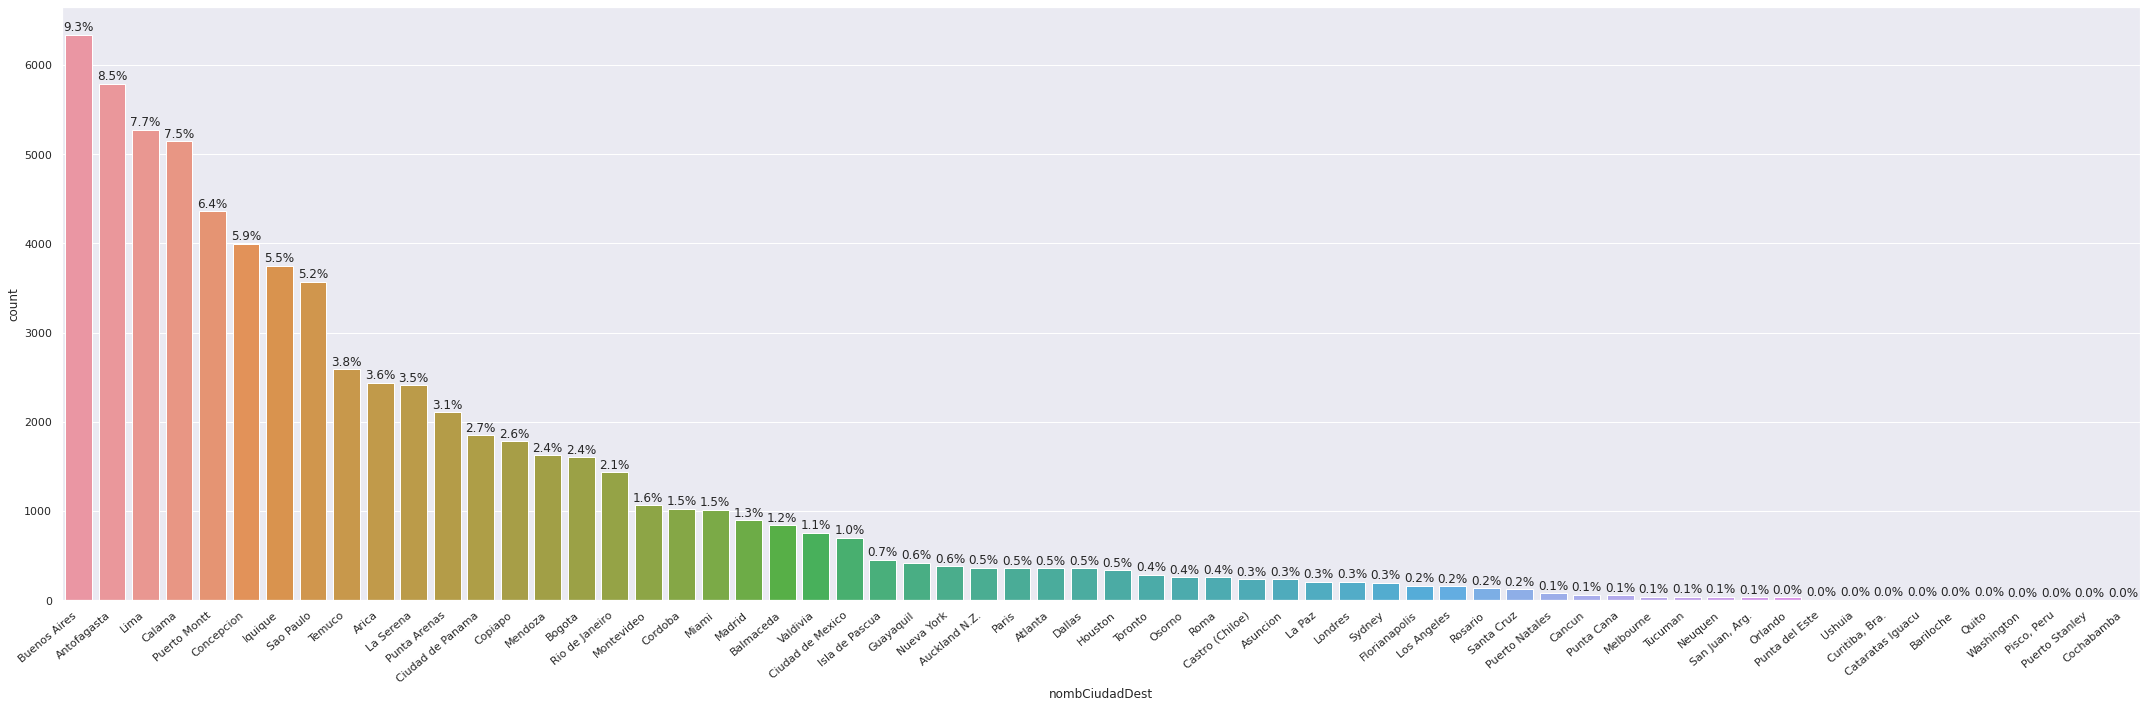

In [44]:
plt.figure(figsize=(30,10))
ax=sns.countplot(data=df_analisis,x='nombCiudadDest',
                 order=df_analisis['nombCiudadDest'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Los destinos más frecuentes son **Buenos Aires(9,3%), Antofagasta(8.5%), Lima(7.7%) y Calama(7.5%)**. Estas ciudades se encuentran dentro de los países: **Argentina, Chile y Perú**
- Los destinos menos frecuentes son **Washington, Pisco - Peru, Puerto Stanley y Cochabamba**


**Agrupación de las ciudades en PAIS, REGION**

In [45]:
#Pendiente
#Crear una nueva variable
#Se debe relacionar esto con respecto al origen y destino. 
#Esto permite mirar la frecuencia de un lugar a otro. Mirar cuales son las rutas más frecuentes

### Número de vuelos por año, mes y dia de la semana

#### Vuelos por año

In [46]:
data_agrupada = df_analisis.groupby(['anioVuelOperado'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada

anioVuelOperado  nro_vuelos    % Total
0             2017       68204  99.997068
1             2018           2   0.002932

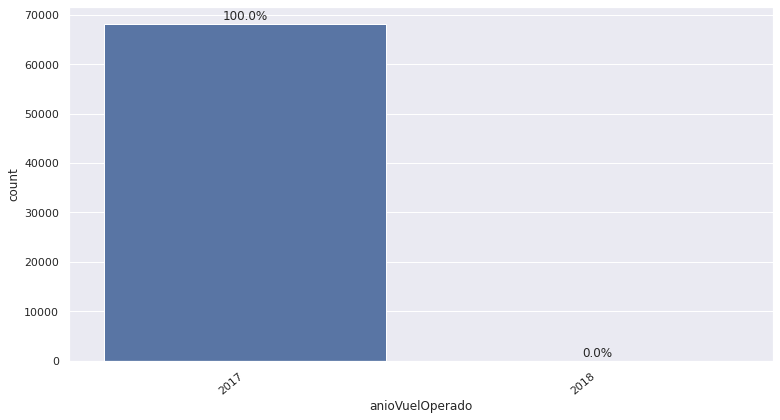

In [47]:
plt.figure(figsize=(11,6))
ax=sns.countplot(data=df_analisis,x='anioVuelOperado',
                 order=df_analisis['anioVuelOperado'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa que la mayor cantidad de vuelos operados corresponden al año 2017. Esta variable se puede considerar así mismo como una **columna constante de varianza nula** ya que el 99.99% de sus valores se encuentran sobre una única categoria por lo que será eliminado.

In [48]:
df_analisis.drop('anioVuelOperado', axis=1, inplace=True)

#### Vuelos por mes

In [49]:
data_agrupada = df_analisis.groupby(['mesVuelOperado'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada

mesVuelOperado  nro_vuelos   % Total
11              12        6356  9.318828
0                1        6108  8.955224
10              11        6080  8.914172
9               10        6032  8.843797
6                7        5992  8.785151
7                8        5744  8.421546
8                9        5610  8.225083
1                2        5561  8.153242
2                3        5482  8.037416
4                5        5240  7.682609
3                4        5020  7.360056
5                6        4981  7.302877

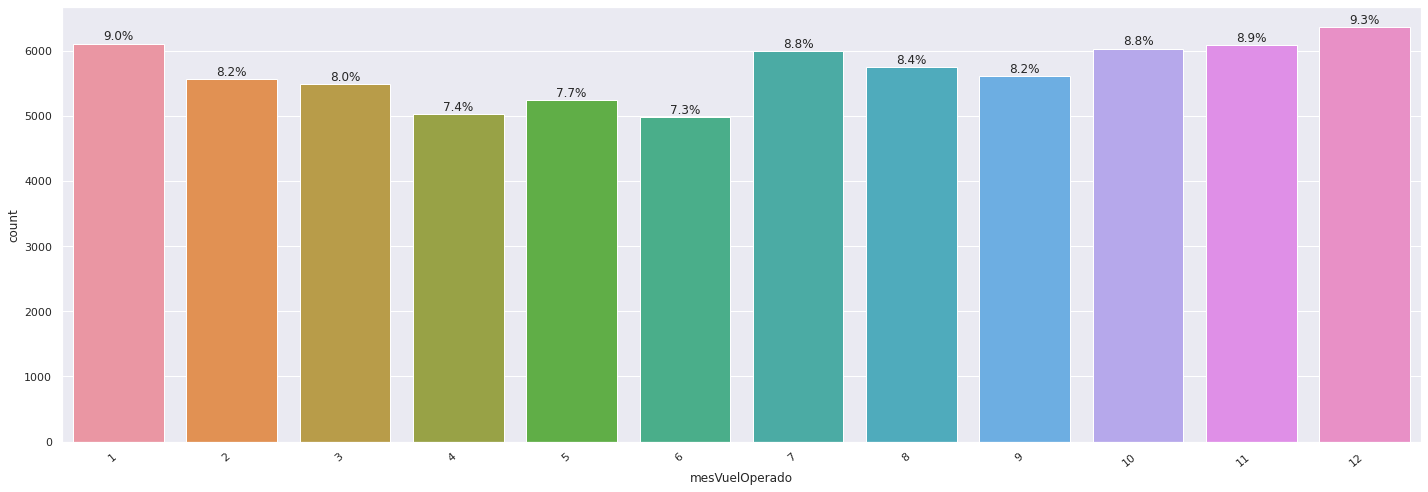

In [50]:
plt.figure(figsize=(20,7))
ax=sns.countplot(data=df_analisis,x='mesVuelOperado')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa lo siguiente:

*   **Enero** y **Diciembre** son los meses con la mayor cantidad de vuelos operados
*   **Abril** y **Junio** registran la menor cantidad de vuelos operados
*   El **segundo trimestre** del año (Abr. May. Jun.) tiene el menor número de vuelos operados
*   **Enero**, **Julio** y **Diciembre** registran una subida en el número de vuelos operados con respecto a los meses anteriores.
*   El **último trimestre** del año (Oct. Nov. Dic.) tiene un mayor número de vuelos operados con respecto al resto de trimestres




#### Vuelos por día de la semana

In [51]:
data_agrupada = df_analisis.groupby(['diaSemVuelOperado'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada


diaSemVuelOperado  nro_vuelos    % Total
6           Viernes       10292  15.089582
1            Jueves       10251  15.029470
2             Lunes       10131  14.853532
0           Domingo        9796  14.362373
4         Miercoles        9722  14.253878
3            Martes        9662  14.165909
5            Sabado        8352  12.245257

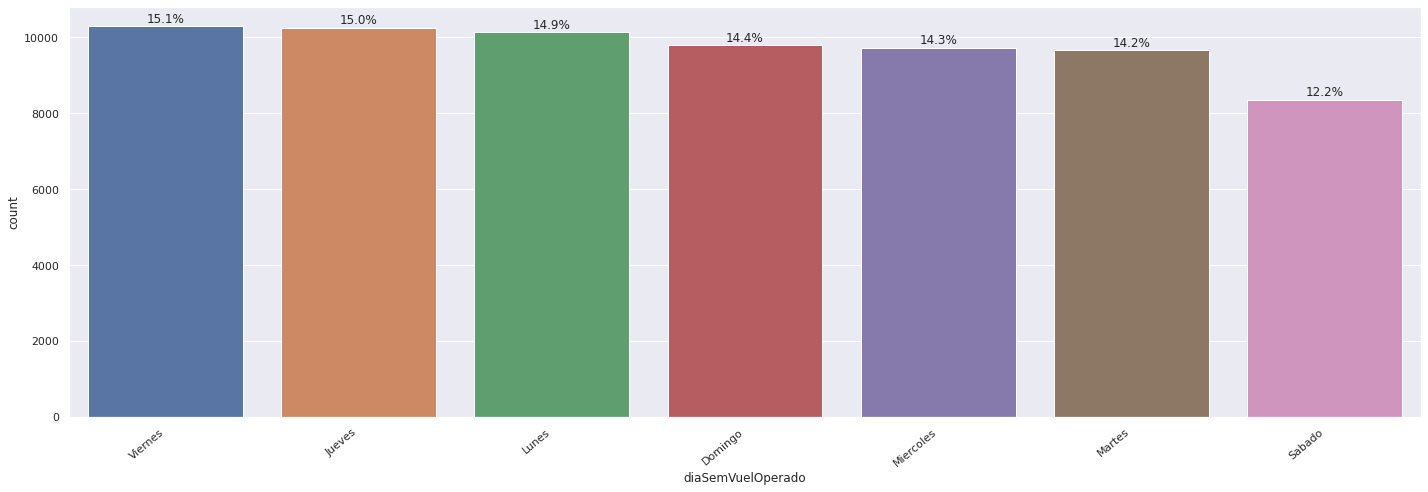

In [52]:
plt.figure(figsize=(20,7))
ax=sns.countplot(data=df_analisis,x='diaSemVuelOperado',
                 order=df_analisis['diaSemVuelOperado'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa lo siguiente:
- Los **Sábados** es el dia con la menor cantidad de vuelos. Representa el **12.2%** de los vuelos operados
- Los **Viernes** y **Jueves** y **Lunes** son los días con la mayor cantidad de vuelos. Cada uno representa más del **15%**.

In [53]:
df_analisis.drop('diaVuelOperado', axis=1, inplace=True)

### Número de vuelos por tipo y nombre de la aerolínea

#### Vuelos por tipo de vuelo

In [54]:
data_agrupada = df_analisis.groupby(['tipVuelo'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada


tipVuelo  nro_vuelos    % Total
1        N       36966  54.197578
0        I       31240  45.802422

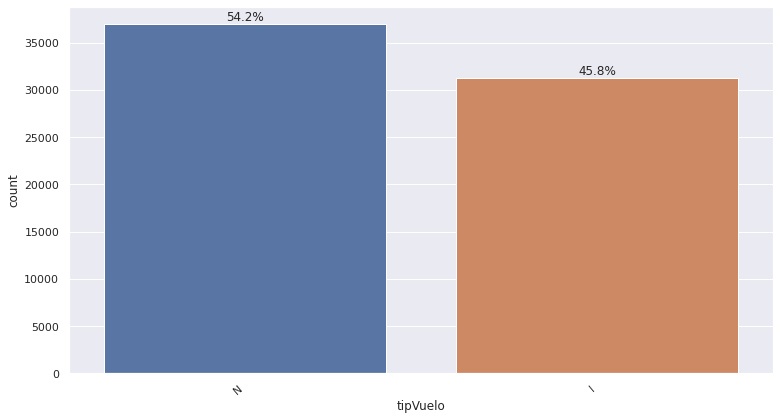

In [55]:
plt.figure(figsize=(11,6))
ax=sns.countplot(data=df_analisis,x='tipVuelo',
                 order=df_analisis['tipVuelo'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Del total de vuelos operados el **54.2%** son vuelos **Nacionales** 10% más que los vuelos Internacionales **45.8%**.

#### Vuelos por nombre de la aerolínea que opera

In [56]:
data_agrupada = df_analisis.groupby(['nombAerolineaOperado'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada.head(10)

nombAerolineaOperado  nro_vuelos    % Total
12            Grupo LATAM       40892  59.953670
21            Sky Airline       14298  20.962965
0   Aerolineas Argentinas        1949   2.857520
9                Copa Air        1850   2.712371
17   Latin American Wings        1674   2.454330
7                 Avianca        1152   1.689001
14           JetSmart SPA        1095   1.605431
11              Gol Trans         806   1.181714
5       American Airlines         757   1.109873
2              Air Canada         565   0.828373

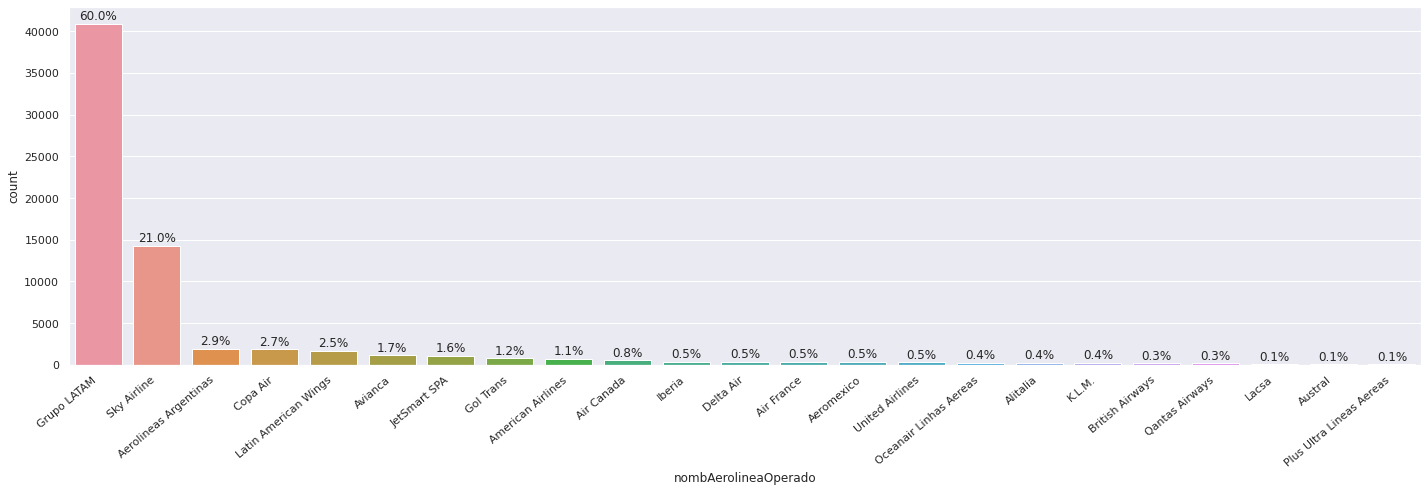

In [57]:
plt.figure(figsize=(20,7))
ax=sns.countplot(data=df_analisis,x='nombAerolineaOperado',
                 order=df_analisis['nombAerolineaOperado'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa lo siguiente:
- La aerolinea con más vuelos es el **Grupo LATAM** con 40892 vuelos, esto representa el **59.9%** del total de vuelos operados. Seguido de **Sky Airlines** con el **20.9%**.
- **Más del 80%** del total de vuelos operados está conformado por las aerolíneas Grupo LATAM y Sky Airlines.
- **Cerca de 10%** está conformado por **Aerolineas Argentinas (2.85%), Copa Air (2.7%), Latin American Wings (2.4%), Avianca (1.6%)**.

### Número de vuelos por temporada y periodo

#### Vuelos por temporada

In [58]:
data_agrupada = df_analisis.groupby(['temporada_alta'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada

temporada_alta  nro_vuelos    % Total
0              0       58051  85.111281
1              1       10155  14.888719

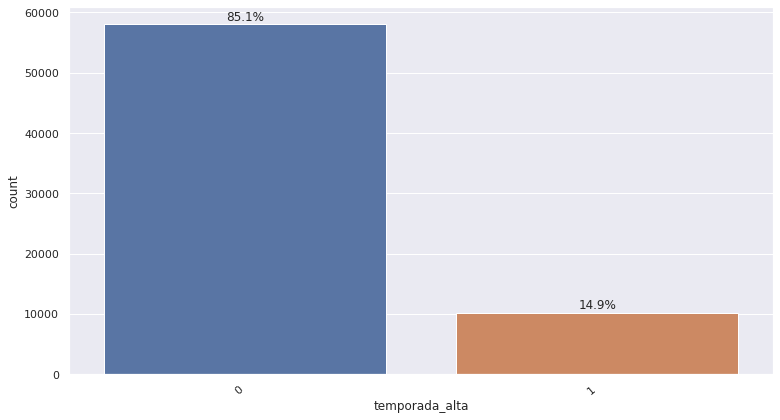

In [59]:
plt.figure(figsize=(11,6))
ax=sns.countplot(data=df_analisis,x='temporada_alta',
                 order=df_analisis['temporada_alta'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa que el **85.11%** de los vuelos **no** se realizan en temporada alta, es decir entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep.

#### Vuelos por periodo dia

In [60]:
data_agrupada = df_analisis.groupby(['periodo_dia'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada

periodo_dia  nro_vuelos    % Total
2       tarde       25506  37.395537
0      mañana       25352  37.169750
1       noche       17348  25.434712

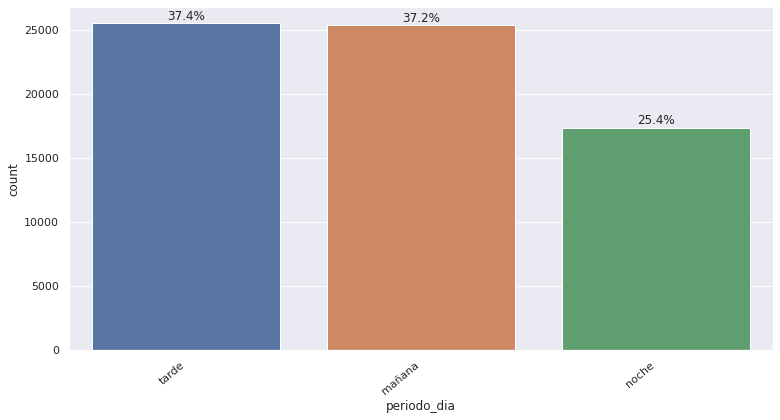

In [61]:
plt.figure(figsize=(11,6))
ax=sns.countplot(data=df_analisis,x='periodo_dia',
                 order=df_analisis['periodo_dia'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa que se tiene un porcentaje menor **(25.4%)** de personas que vuelan durante la **noche**. Siendo un porcentaje **mayor** durante la **tarde(37.4%)** y la **mañana(37.2)**

### Distribución de la tasa de atraso (min)

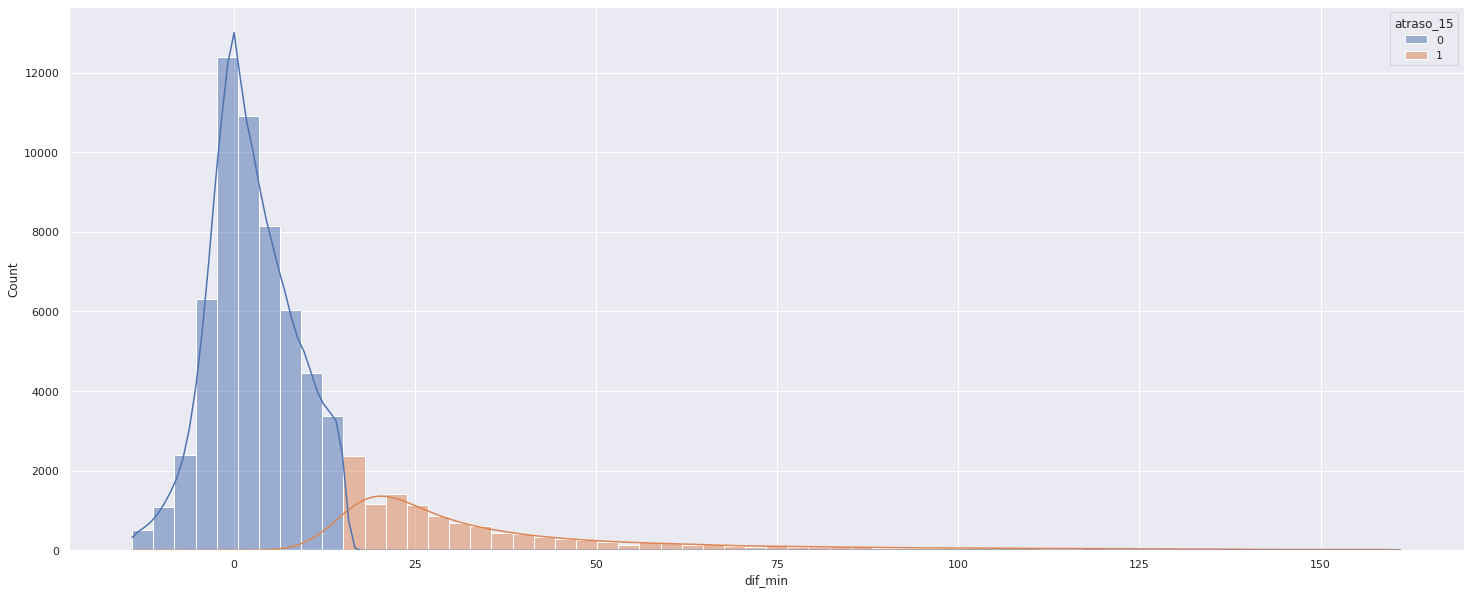

In [62]:
plt.figure(figsize=(25,10))
sns.histplot(data=df_analisis, x='dif_min',kde=True,hue='atraso_15',bins=60)
plt.show()

Se observa lo siguiente:
- La variable **dif_min** presenta un histograma asimetrico con cola hacia la derecha, lo que evidencia que se tiene la presencia de pocos altos valores de atraso de un vuelo.
- La diferencia en minutos para la variable **atraso_15** de **valor igual a 1**, tiene un histograma achatado asimetrico de cola hacia a la derecha, lo que evidencia que se tiene la presencia de pocos altos valores de atraso de un vuelo. Esto genera una alta desviación estandar con respecto a la media.
- La diferencia en minutos para la variable **atraso_15** de **valor igual a 0**, tiene un histograma apuntado con baja desviación estandar ya que sus valores se encuentran concentrados cerca de la media.
- La desviación estandar de la variable **atraso_15** de **valor igual a 0** es mayor que la variable **atraso_15** de **valor igual a 1**, esto evidencia una mayor variabilidad en cuanto a sus valores con respecto a la media para los vuelos retrasados.

Se observa una ligera **asimetria a la derecha (Cola a la derecha)**. Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de distribución. Veamos un BOXPLOT para analizar estos puntos.

/home/laren.osorio/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


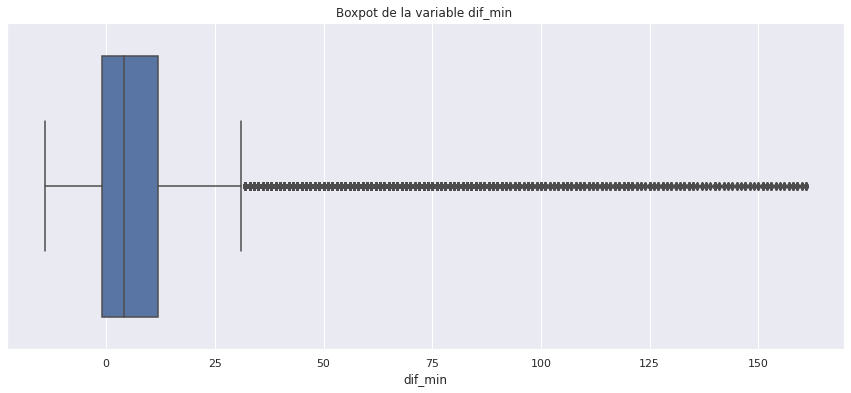

In [63]:
plt.figure(figsize=(15,6))
sns.boxplot(df_analisis['dif_min'])
plt.title("Boxpot de la variable dif_min ")
plt.show()

A través del boxplot podemos ver claramente que existen algunos valores a la derecha que pueden no favorecer en el comportamiento habitual de los datos. Veamos un análisis por PERCENTILES

In [64]:
vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
vector_valores_percentiles=np.percentile(df_analisis['dif_min'],vector_percentiles)

pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
           pd.DataFrame(vector_valores_percentiles, columns = ['Valor'])], axis = 1)

Percentile  Valor
0          0.0  -14.0
1          0.5  -12.0
2          1.0  -11.0
3          2.5   -8.0
4          5.0   -6.0
5         10.0   -4.0
6         25.0   -1.0
7         50.0    4.0
8         75.0   12.0
9         90.0   26.0
10        92.5   32.0
11        95.0   43.0
12        97.5   66.0
13        98.0   75.0
14        98.5   86.0
15        99.0  102.0
16        99.5  123.0
17       100.0  161.0

Lo que se busca son **grandes variaciones por percentil**. Por ejemplo para esta variable el percentil **98.5** tiene un valor de **86** sin embargo el percentil 100 tiene un valor **161**, casi el doble. es decir solo un **1.5%** concentra valores mayores que **86**; se observa una amplia variación de un percentil a otro. Este será nuestro criterio para imputar cada variable.

Se analizaron los percentiles de la variable y se definió en base la punto de corte correspondiente:

In [65]:
#clean_outlier_perc(df_analisis,'dif_min', 0.98)

Para este caso primero analizaremos si esta variable le aporta al modelo, de lo contrario no tiene sentido retirar los valores outliers con la función **clean_outlier_perc** ya que le añade más sesgo al modelo

### Reporte Univariado

Se realiza la conversión en los tipos de datos para realizar el reporte univariado

In [66]:
df_analisis_uni = df_analisis.copy()

In [67]:
feat_numerical_uni = ['dif_min']

feat_categorical_uni = [
 'codCiudadDestProg',
 'codAerolineaVuelProg',
 'codCiudadDestOperado',
 'codAerolineaVuelOperado',
 'diaSemVuelOperado',
 'mesVuelOperado',
 'tipVuelo',
 'nombAerolineaOperado',
 'nombCiudadDest',
 'atraso_15',
 'temporada_alta',
 'periodo_dia']

In [68]:
for var in feat_categorical_uni:
  df_analisis_uni[var] = df_analisis_uni[var].astype('category')

In [69]:
v=pd.DataFrame({"variable": df_analisis_uni.columns.values})
t=pd.DataFrame({"tipo": df_analisis_uni.dtypes.values})
meta=pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category')|(meta['tipo']=='float64'),:]
meta

variable      tipo
2         codCiudadDestProg  category
3      codAerolineaVuelProg  category
6      codCiudadDestOperado  category
7   codAerolineaVuelOperado  category
8            mesVuelOperado  category
9         diaSemVuelOperado  category
10                 tipVuelo  category
11     nombAerolineaOperado  category
13           nombCiudadDest  category
14                  dif_min   float64
15                atraso_15  category
16           temporada_alta  category
17              periodo_dia  category

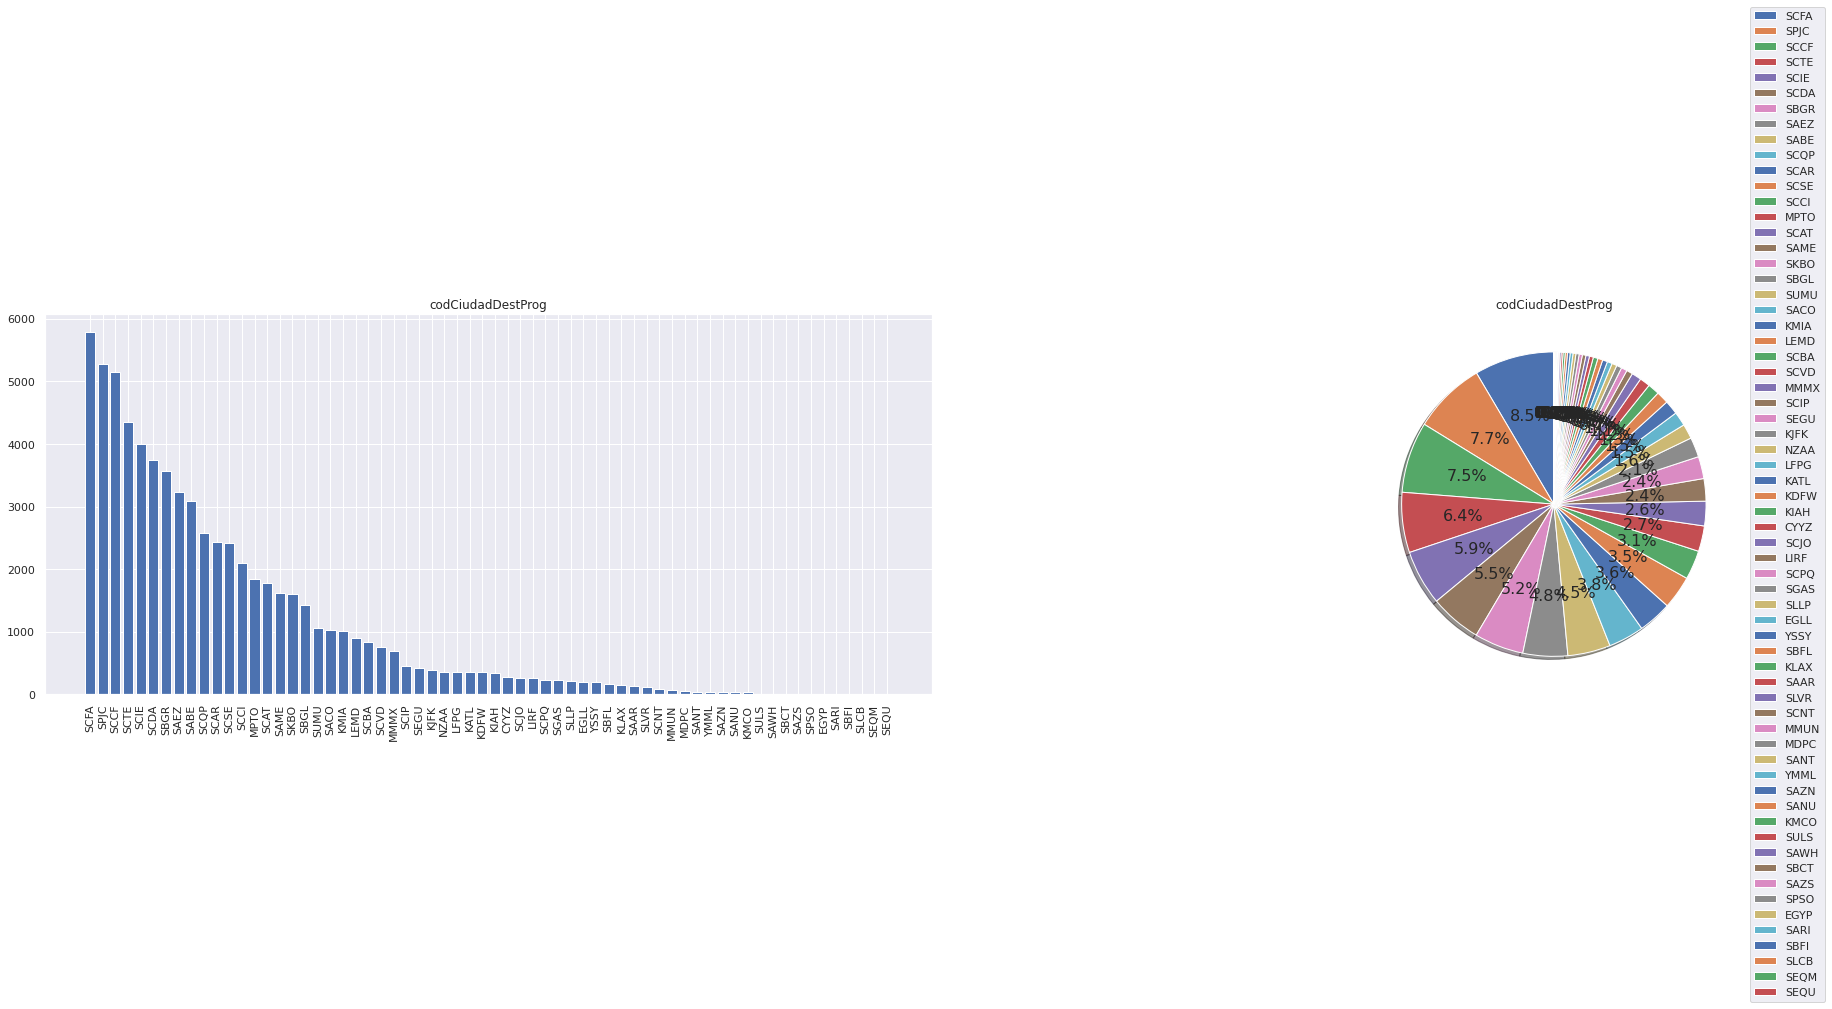

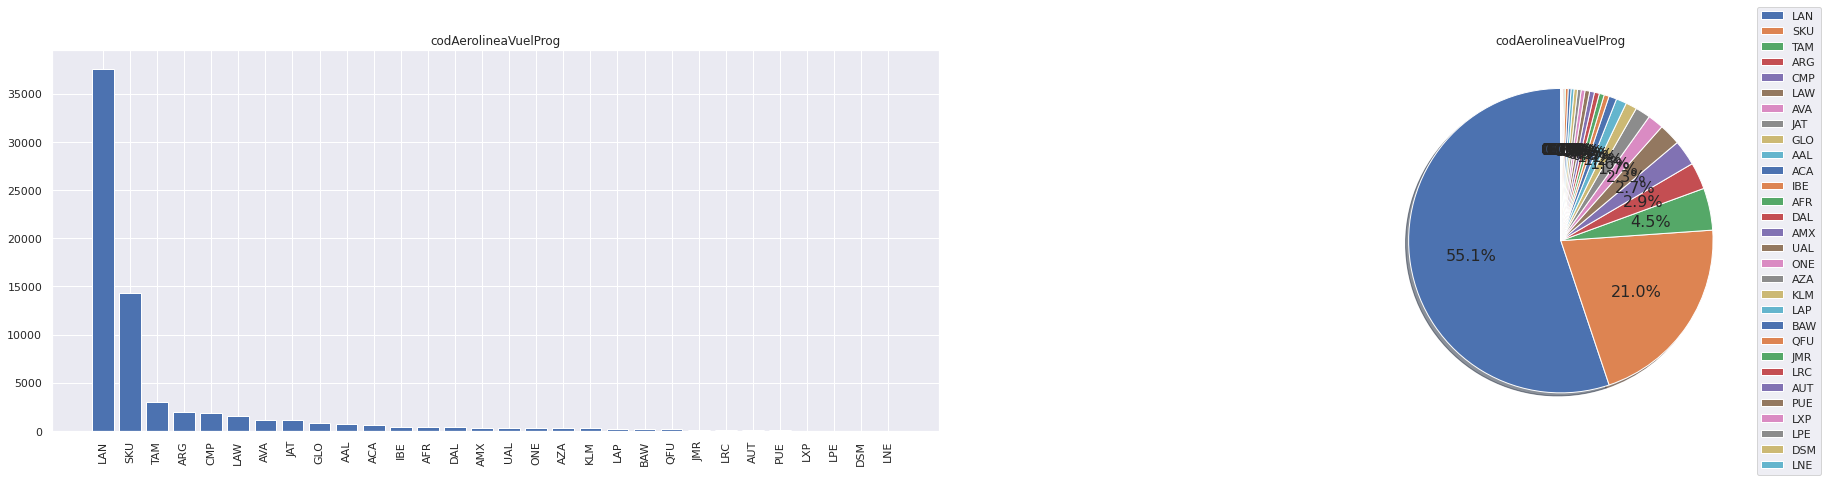

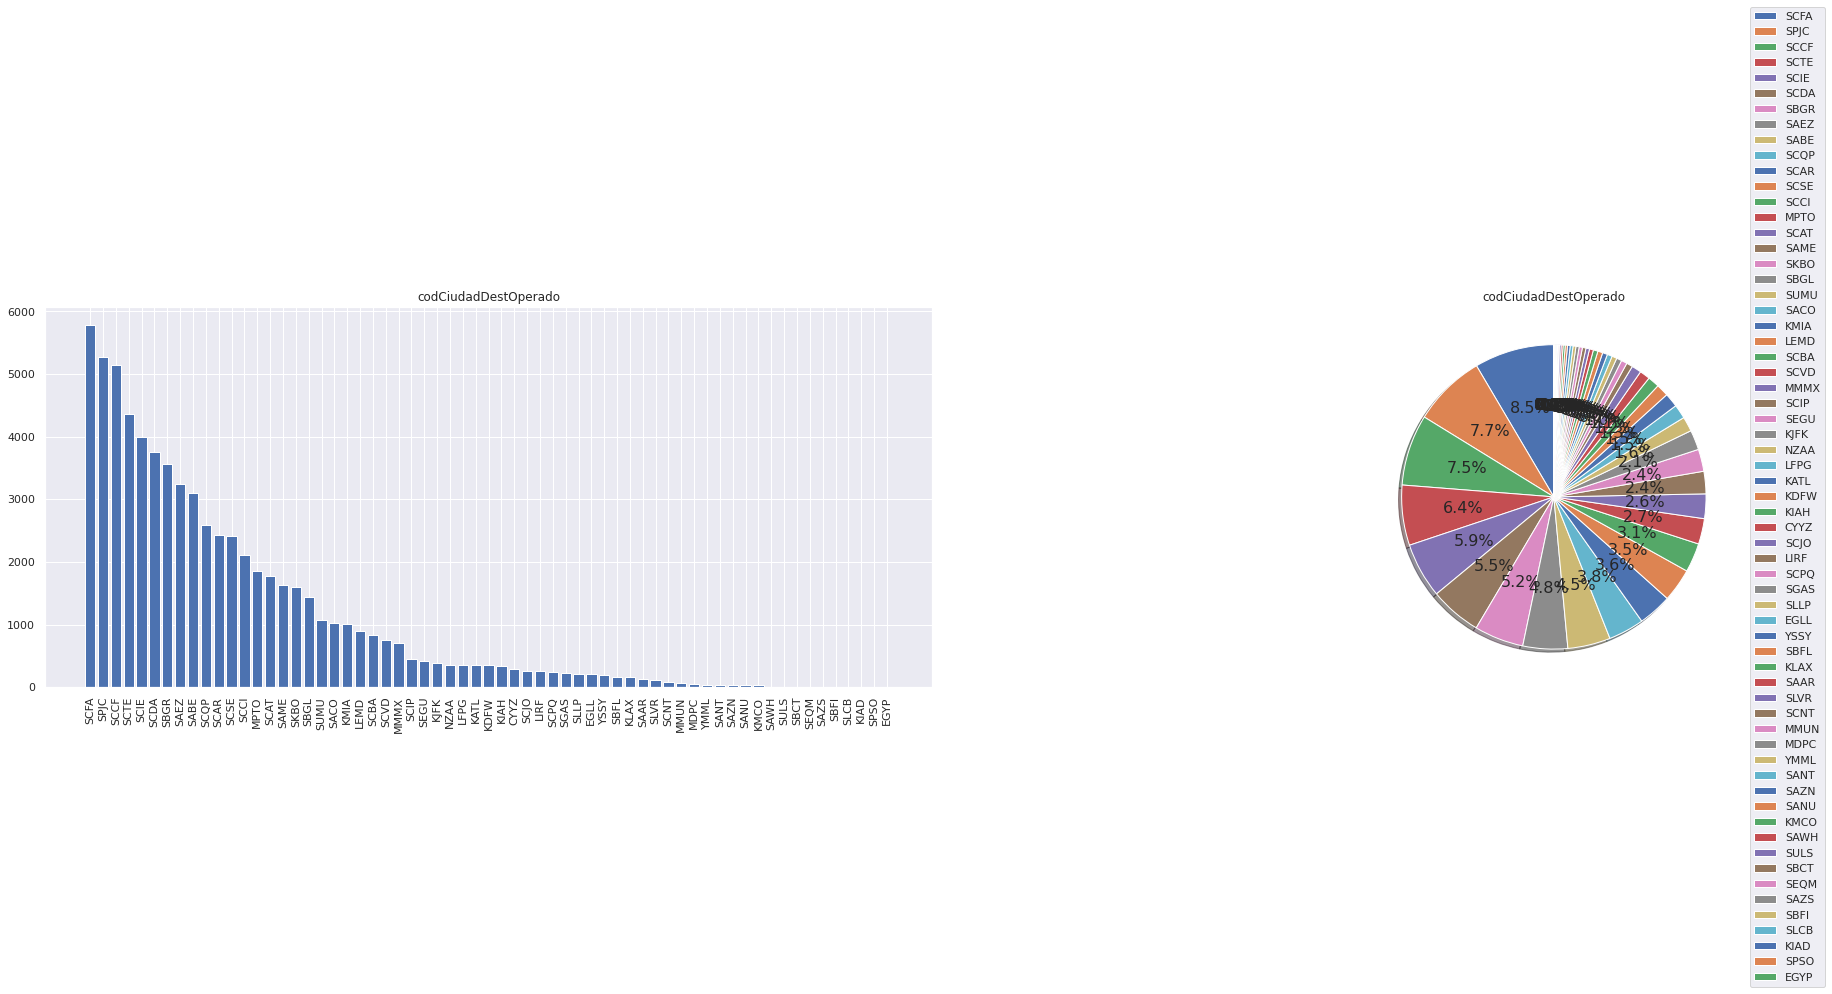

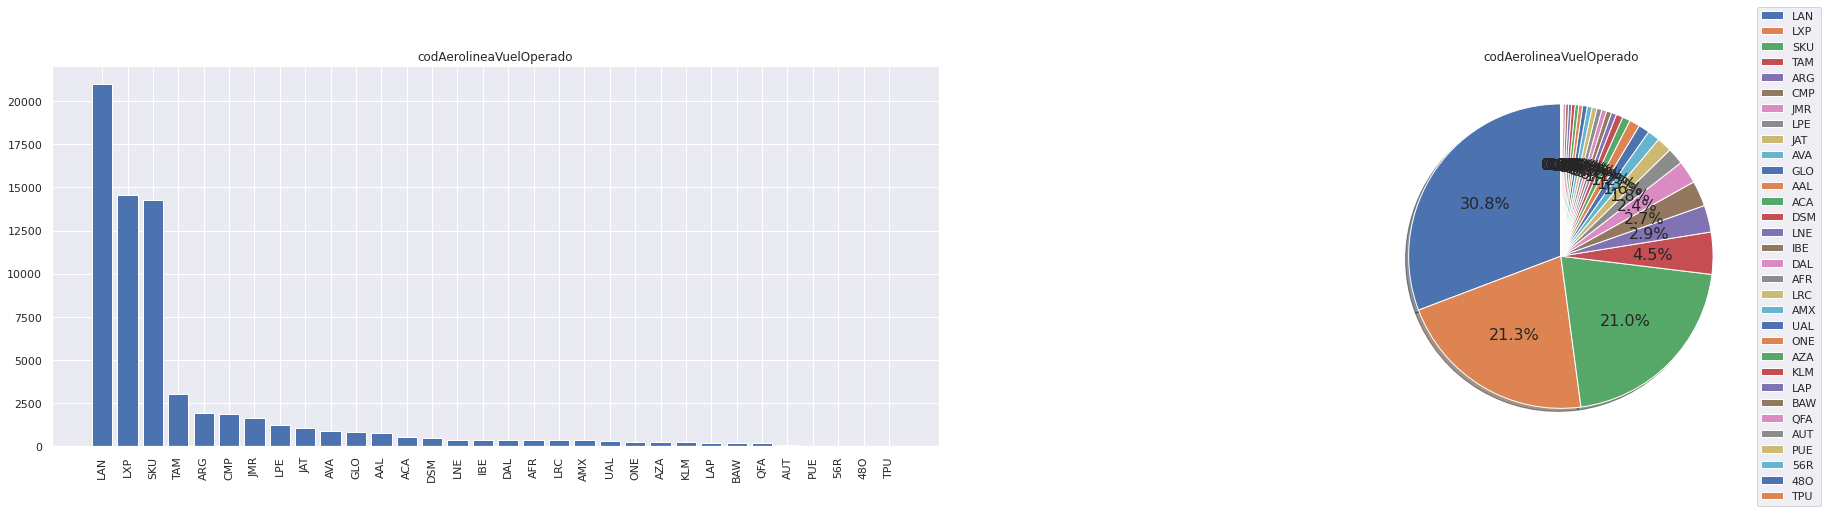

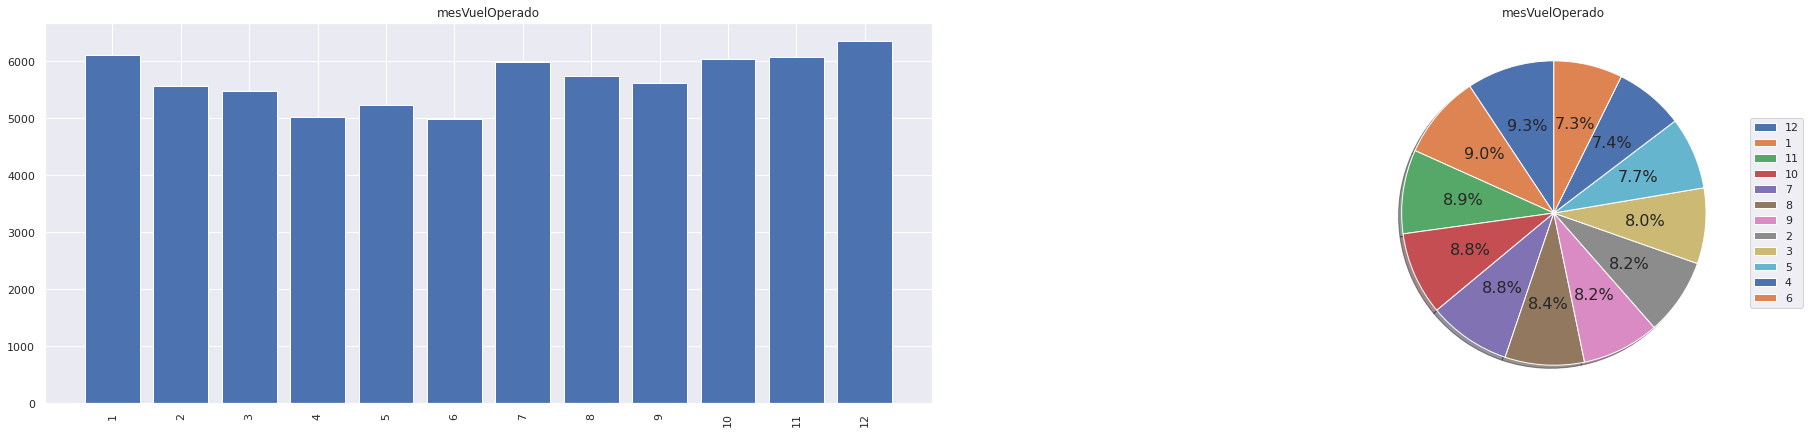

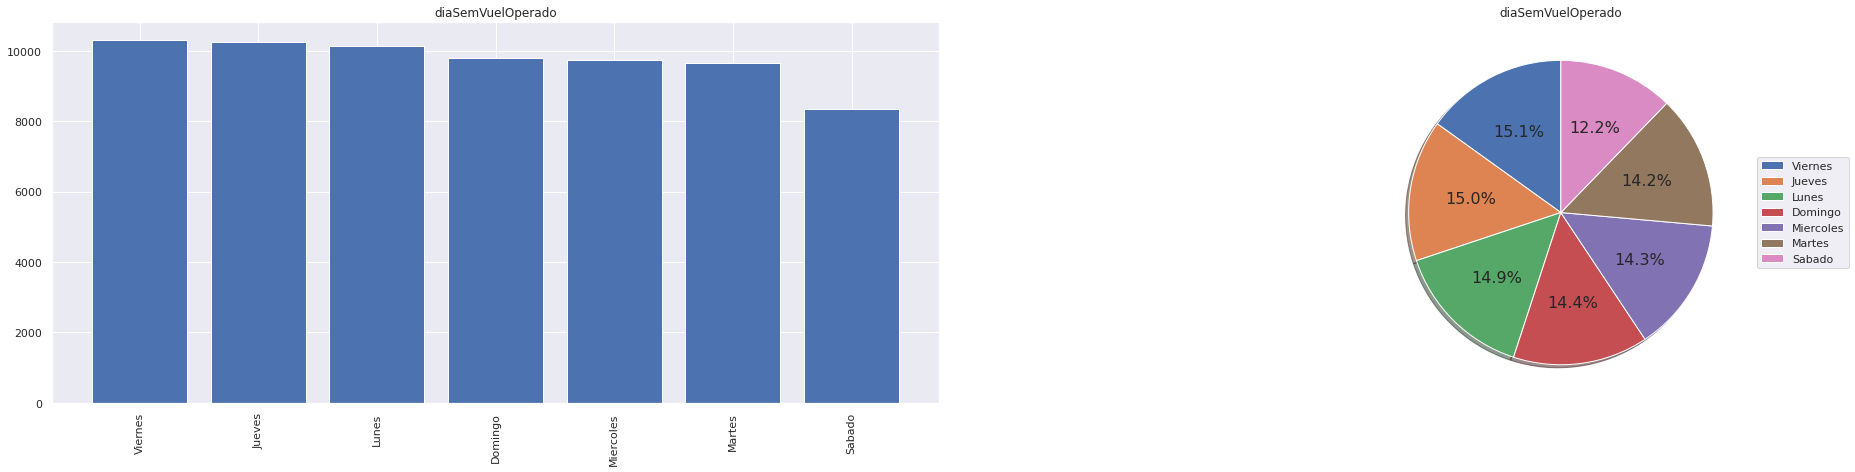

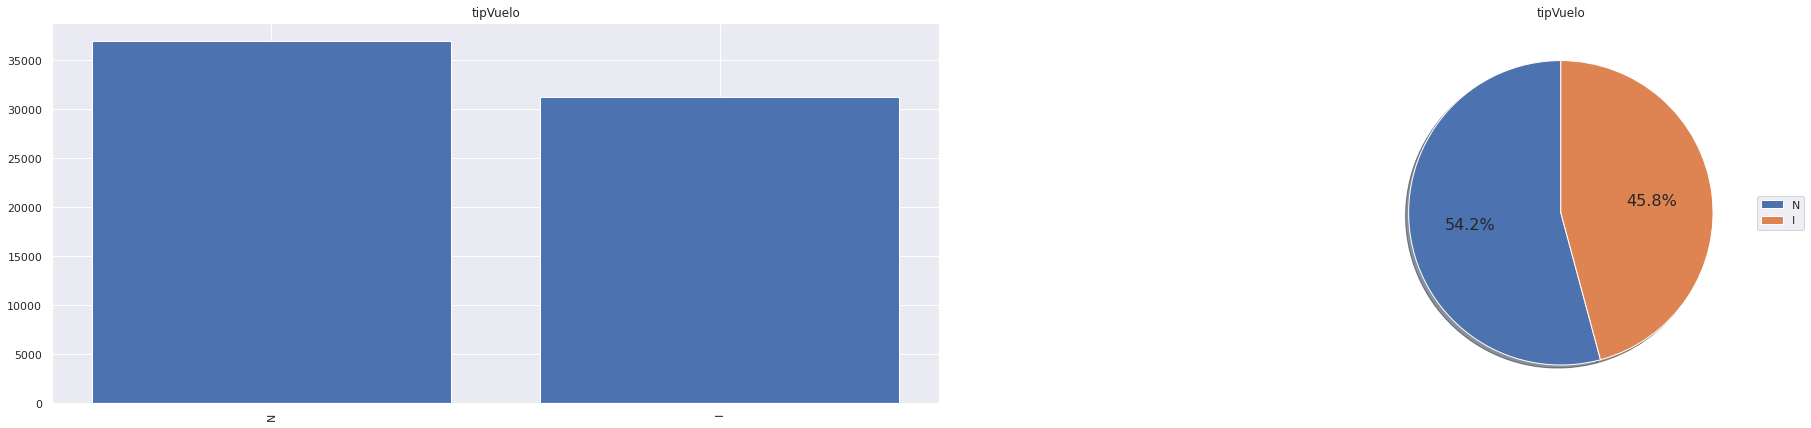

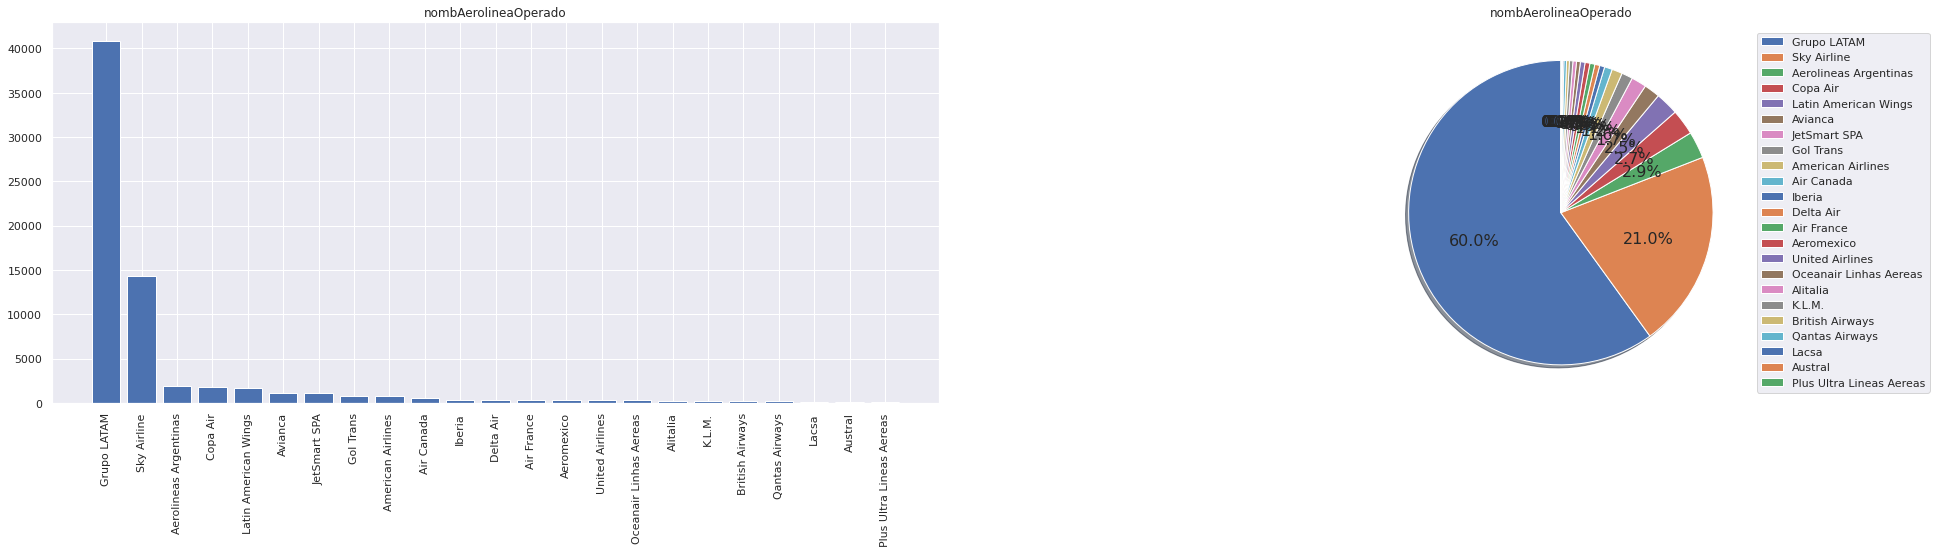

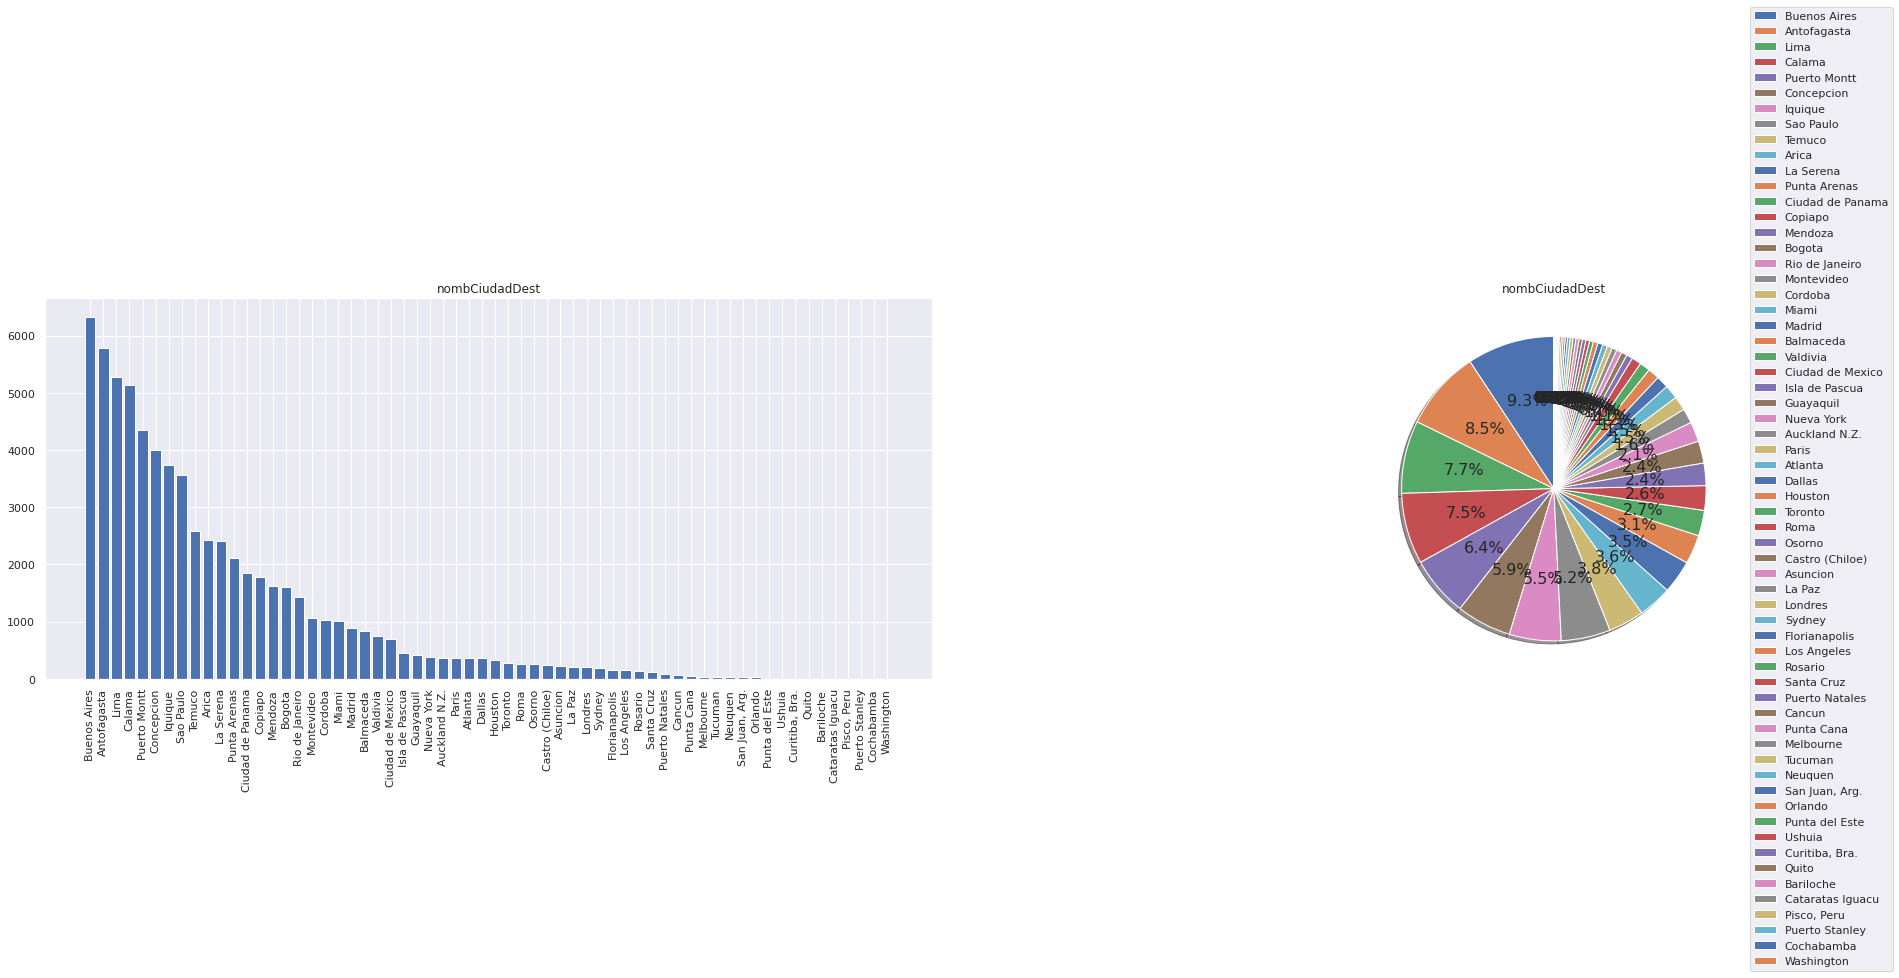

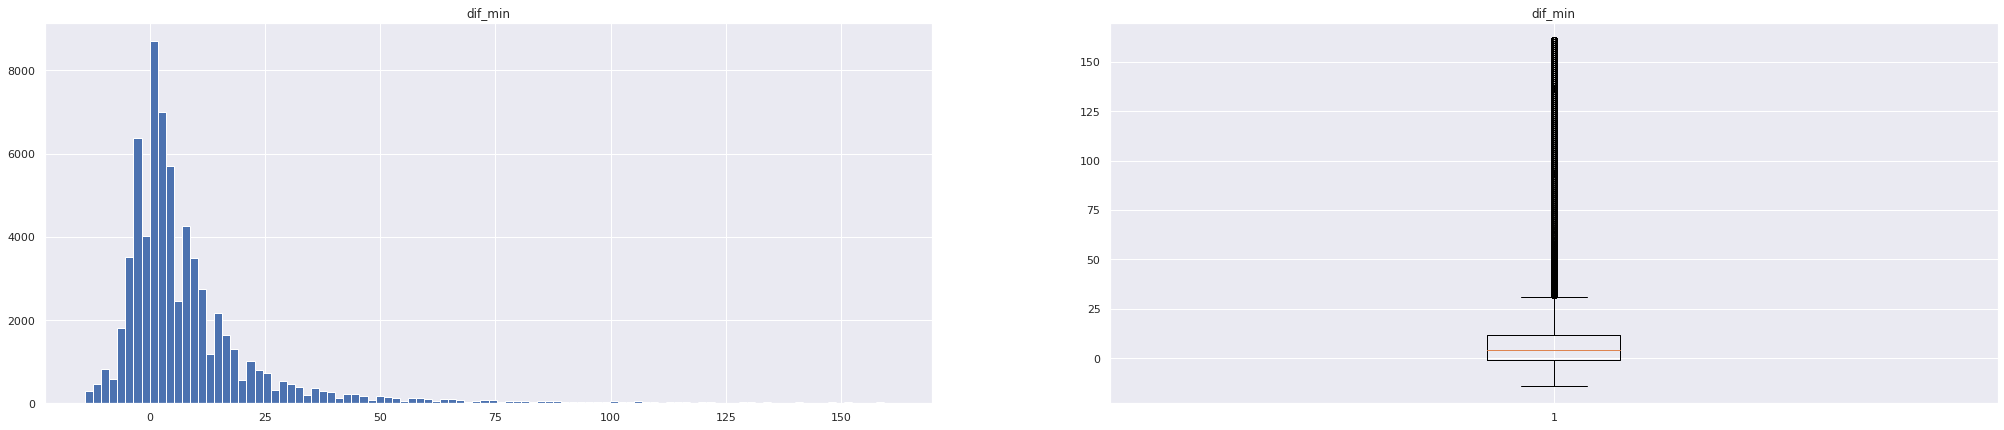

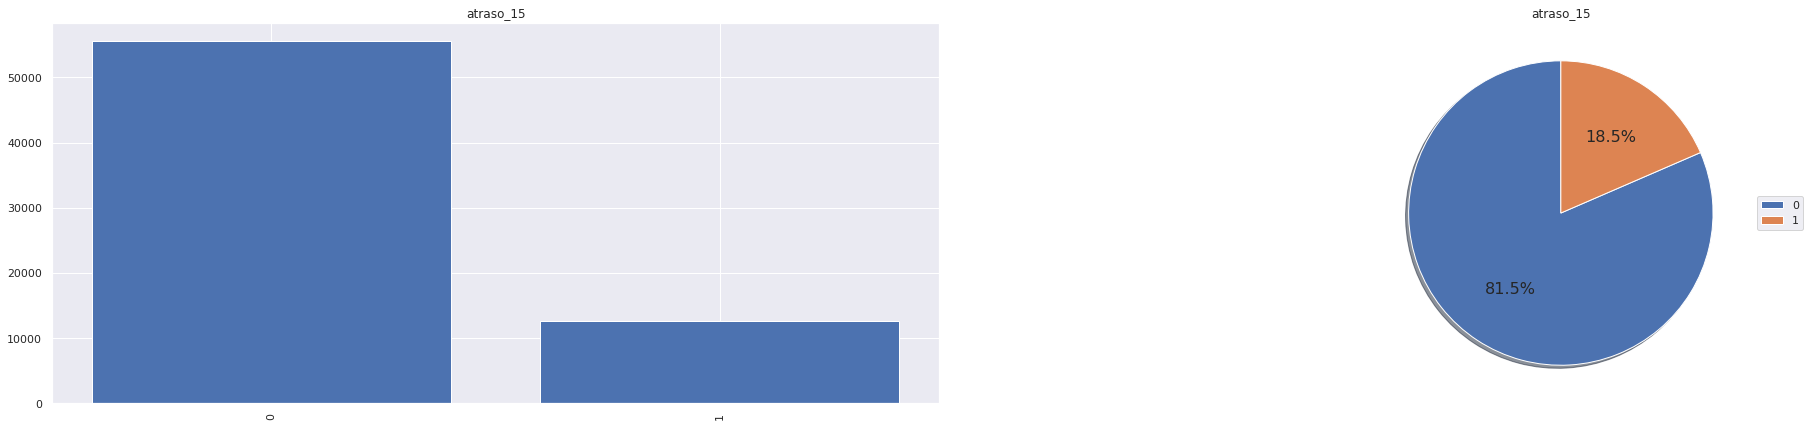

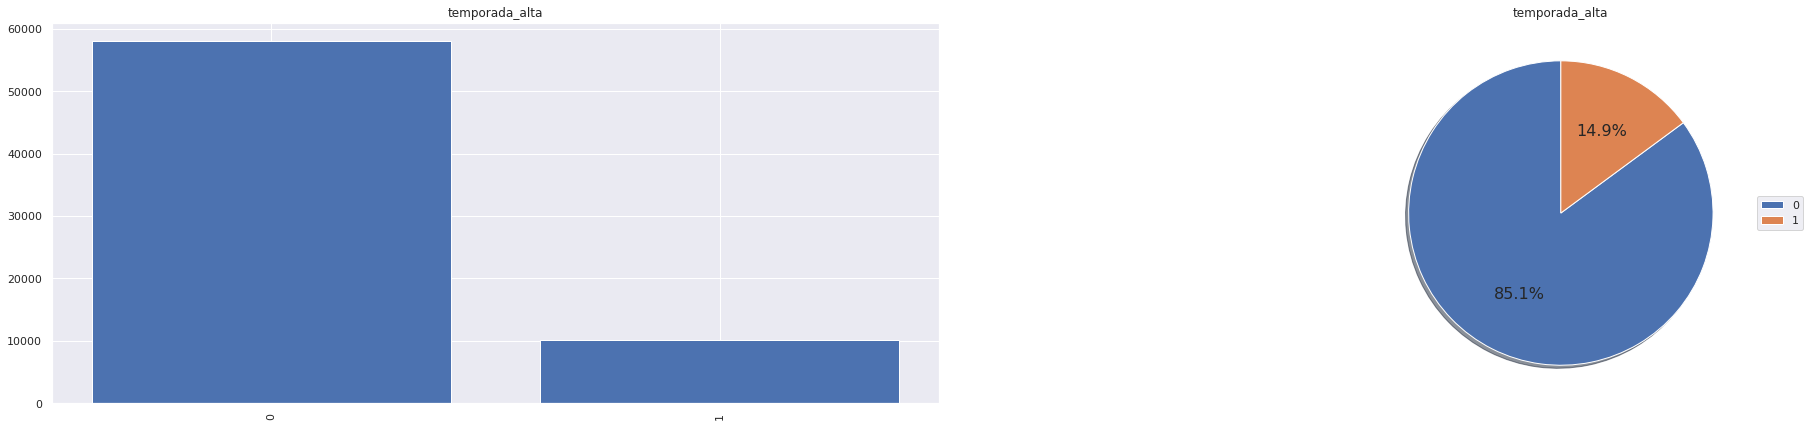

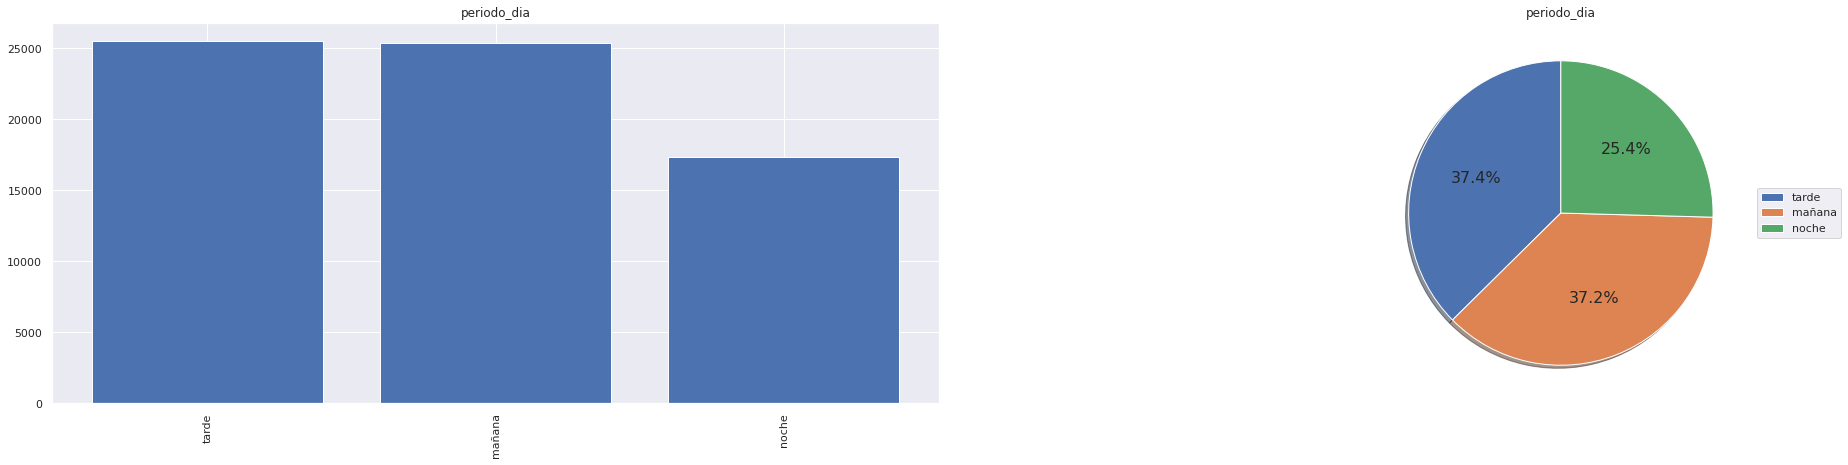

In [70]:
# Reporte Univariado
plot_graph_initial(df_analisis_uni, meta)

En el siguiente reporte se muestra lo siguiente:
- Para las variables cualitativas un gráfico de barras ordenado según la cantidad de vuelos, así como un digrama de pastel que indica el porcentaje de cada categoria.
- Para la única variable cuantitativa se muestra su histograma y boxplot.

## Analisis Preliminar Bivariado


*  Se tomará en cuenta como parte del análisis la **mediana** y la **media** teniendo en cuenta que los valores de la media son afectados por los valores outliers de la variable **dif_min**
*  Se debe de tomar en cuenta la cantidad de valores por cada categoría
*  La intensidad de color en cada boxplot ayudaría a saber la concentración de valores en cada boxplot (densidad)
*  El gráfico del tipo Violinplot será empleado ya que ayudará a reflejar esta característica




### Análisis de los minutos de atraso por vuelo

Se realiza el análisis correspondiente de los **minutos de atraso** por destino, aerolínea, tipo de vuelo, dia de la semana, mes del año, temporada y periodo. En ese sentido se necesita convertir las variables **mesVuelOperado** y **diaSemVuelOperado** a tipo *'category'* para un correcto análisis

In [71]:
df_analisis['diaSemVuelOperado'] = df_analisis['diaSemVuelOperado'].astype('object')
df_analisis['mesVuelOperado'] = df_analisis['mesVuelOperado'].astype('object')

#### Minutos de Atraso por destino

Se divide el siguiente análisis por el número de vuelos para un mejor entendimiento

**Número de vuelos <= 6**

In [72]:
data_agrupada = df_analisis.groupby(['nombCiudadDest'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'nombCiudadDest_':'nombCiudadDest','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada=data_agrupada.sort_values(by=['nro_vuelos','dif_min_median'],ascending=True)
data_agrupada=data_agrupada.loc[data_agrupada.nro_vuelos<=6,:]
data_agrupada

nombCiudadDest  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
61        Washington           1      0.000000             0.0          NaN
41       Pisco, Peru           1      2.000000             2.0          NaN
44    Puerto Stanley           1     50.000000            50.0          NaN
15        Cochabamba           1    113.000000           113.0          NaN
12  Cataratas Iguacu           2      1.500000             1.5     4.949747
6          Bariloche           2     18.500000            18.5    16.263456
48             Quito           2     52.000000            52.0    39.597980
19    Curitiba, Bra.           3     -2.666667            -4.0     8.082904
47    Punta del Este           6      8.500000             1.5    16.477257
59            Ushuia           6     24.500000            24.0    16.670333

Se osbserva que existen destinos con poca cantidad de vuelos como **Puerto Stanley (1)**, **Cochabamba(1)** y **Quito(2)** cuyo promedio y mediana de minutos de atraso si bien son altos estos valores estan siendo afectados por la poca cantidad de número de vuelos. En ese sentido se separa los vuelos que tienen **menos y más de 6 vuelos** para un mejor entendimiento.

Se puede apreciar que estos 10 últimos destinos (menos de 6 vuelos) presentan **características climatológicas** particulares como la **altura de Cochabamba-Bolivia y Quito-Ecuador**

**Número de vuelos > 6**

In [73]:
data_filtrada=df_analisis.loc[~df_analisis.nombCiudadDest.isin(list(data_agrupada.nombCiudadDest.values)),:]
data_filtrada.shape

(68181, 18)

In [74]:
data_agrupada = df_analisis.groupby(['nombCiudadDest'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'nombCiudadDest_':'nombCiudadDest','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada=data_agrupada.sort_values(by=['dif_min_median'],ascending=False)
data_agrupada=data_agrupada.loc[data_agrupada.nro_vuelos>6,:]
data_agrupada.head(10)

nombCiudadDest  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
55          Sydney         194     26.948454            19.0    28.213057
32       Melbourne          39     19.256410            17.0    15.106147
51         Rosario         136     19.022059            12.0    23.080364
46      Punta Cana          54     14.092593            10.5    15.896206
4    Auckland N.Z.         361     18.246537            10.0    23.206624
18         Cordoba        1023     13.811339             9.0    17.909552
53      Santa Cruz         120     14.066667             9.0    22.414631
2         Asuncion         232     12.969828             8.5    17.688109
49  Rio de Janeiro        1435     14.121951             8.0    22.451119
30     Los Angeles         155     13.264516             7.0    22.704504

In [75]:
data_agrupada.tail(10)

nombCiudadDest  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
29           Londres         205      7.560976             2.0    19.241561
11   Castro (Chiloe)         235      6.212766             2.0    18.667738
9             Calama        5146      5.968908             2.0    15.251535
43    Puerto Natales          79      4.518987             1.0    12.375390
13  Ciudad de Mexico         700      3.175714             0.0    15.853017
40             Paris         359      1.660167            -1.0    11.615408
14  Ciudad de Panama        1850      0.214054            -2.0    11.617931
3            Atlanta         358      0.114525            -2.0    12.212211
20            Dallas         357     -1.081232            -4.0    14.024321
23           Houston         334     -1.862275            -5.0    17.345601

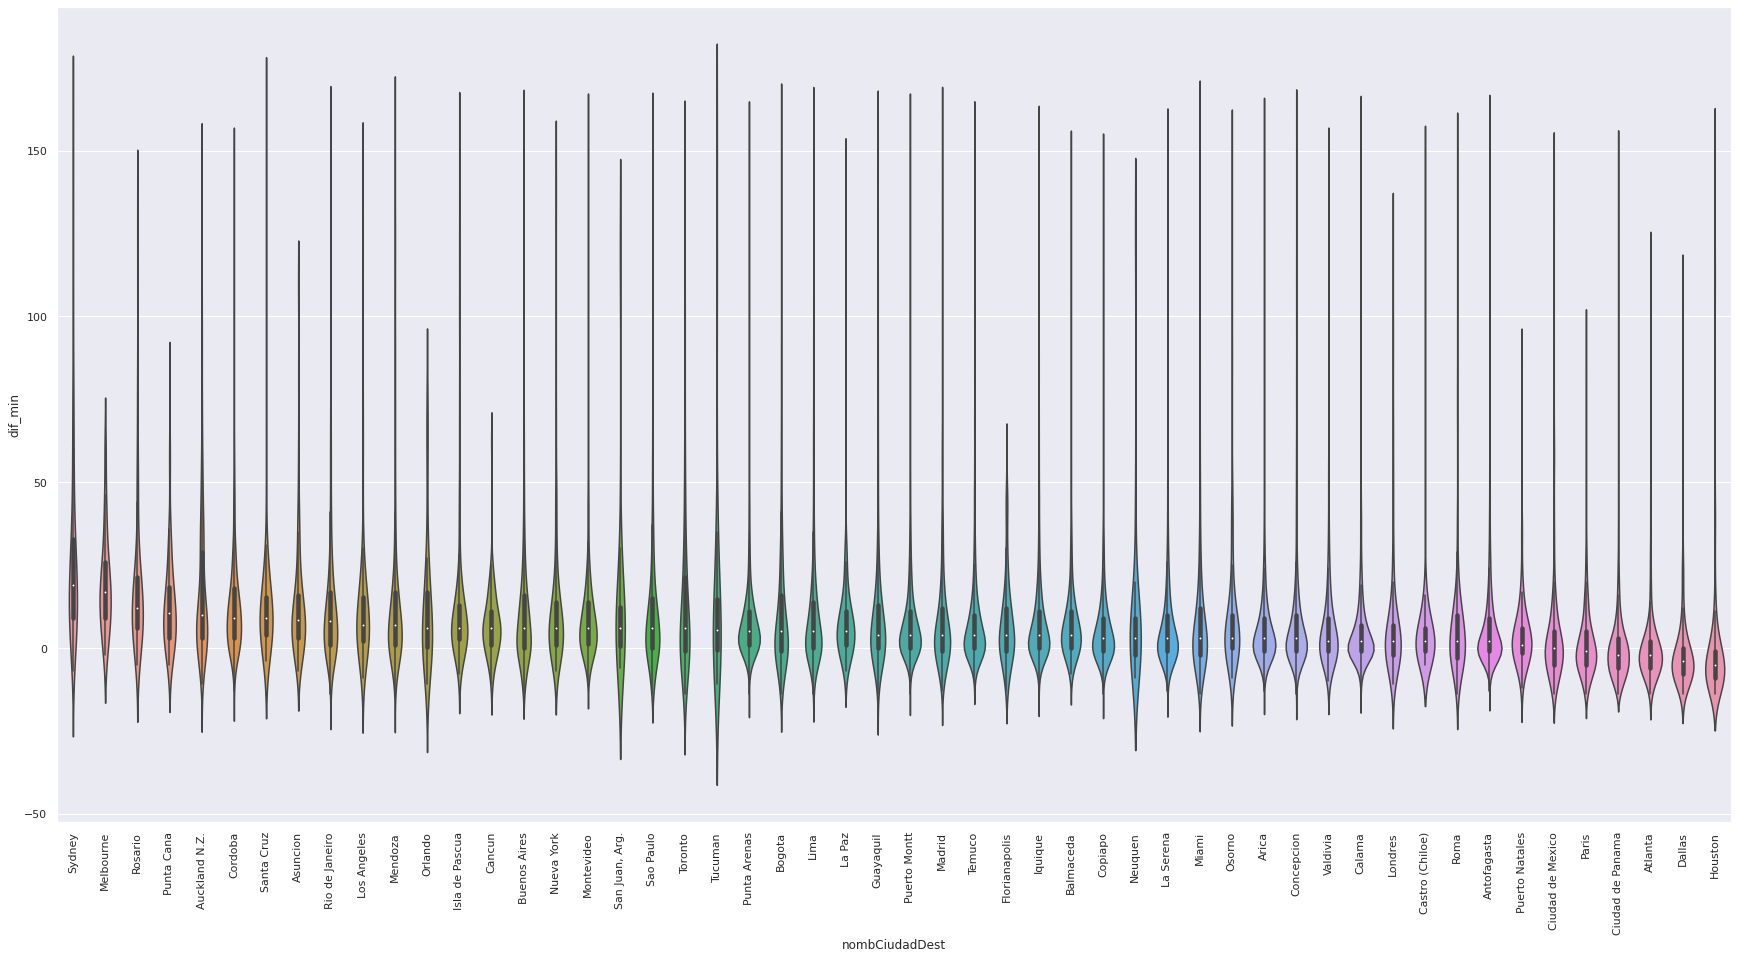

In [76]:
fig, ax = plt.subplots(1, figsize=(30,15))
sns.violinplot(x=data_filtrada['nombCiudadDest'], y=data_filtrada['dif_min'],
            order = data_filtrada.groupby(by=["nombCiudadDest"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

Se observa lo siguiente:
- **Sydney**, **Melbourne** y **Rosario** son las destinos que presentan altos valores de minutos de atraso a diferencia del resto de destinos. Teniendo una mediana de 19, 17 y 12 así como un promedio de minutos de atraso 26, 19, 19 respectivamente.
- **Ciudad de Mexico**, **Puerto Natales**, **Calama** son los destinos que presentan bajos valores de minutos de atraso a diferencia del resto de destinos. Teniendo una mediana de 0, 1 y 2 así como un promedio de minutos de atraso 15, 12, 15 respectivamente.
- El rango de minutos de atraso del destino **Sydney** es amplia desde el primer al tercer cuartil. Es el destino con la mayor promedio (26.9) y mediana (19) de minutos de retraso que el resto de destinos. Tiene una alta desviación estandár (28.21) ya que sus valores no son próximos a la media debido a la presencia de valores atipicos. Su **densidad o concentración de valores** **es baja** en comparación con **Cancun**, **Sao Paulo**, **Punta Arenas**, **Puerto Montt.**, **Serena** y **Calama** y **Antofagasta** que presentan mayor cantidad de vuelos con menor promedio y mediana de minutos de retraso. Algunos de estos destinos centran su atractivo turistico por sus **playas, numerosos resorts y vida nocturna**.
- Si bien los siguientes destinos **Melbourne** y **Rosario** presentan una baja concentración de valores su promedio y mediana de minutos de atraso son altos con respecto al resto de destinos.

#### Minutos de atraso por aerolínea operada

In [77]:
data_agrupada = df_analisis.groupby(['nombAerolineaOperado'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'nombAerolineaOperado_':'nombAerolineaOperado','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

nombAerolineaOperado  nro_vuelos  dif_min_mean  dif_min_median  \
19  Plus Ultra Lineas Aereas          49     31.714286            22.0   
20            Qantas Airways         195     26.835897            19.0   
2                 Air Canada         565     22.909735            13.0   
17      Latin American Wings        1674     24.566308             9.0   
11                 Gol Trans         806     11.911911             6.0   
12               Grupo LATAM       40892      9.470630             5.0   
6                    Austral          74      6.608108             4.5   
0      Aerolineas Argentinas        1949     10.004618             3.0   
7                    Avianca        1152     11.131944             2.5   
8            British Airways         205      7.560976             2.0   
13                    Iberia         362      4.276243             2.0   
14              JetSmart SPA        1095      7.442009             2.0   
4                   Alitalia         259      5.293436             2.0   
21               Sky Airline       14298      8.117149             2.0   
16                     Lacsa          92      4.880435             0.0   
18    Oceanair Linhas Aereas         279      6.340502             0.0   
3                 Air France         358      1.399441            -1.0   
9                   Copa Air        1850      0.214054            -2.0   
10                 Delta Air         358      0.114525            -2.0   
15                    K.L.M.         251      1.310757            -3.0   
5          American Airlines         757      0.277411            -3.0   
1                 Aeromexico         351     -2.495726            -4.0   
22           United Airlines         335     -1.856716            -5.0   

    dif_min_std  
19    34.575401  
20    28.184110  
2     30.628997  
17    36.845529  
11    23.844599  
12    17.772141  
6     13.734087  
0     22.604230  
7     25.043905  
8     19.241561  
13    12.571830  
14    18.035869  
4     15.932233  
21    18.367337  
16    21.549250  
18    21.396114  
3     10.527260  
9     11.617931  
10    12.212211  
15    18.554111  
5     16.445667  
1     10.799437  
22    17.319914

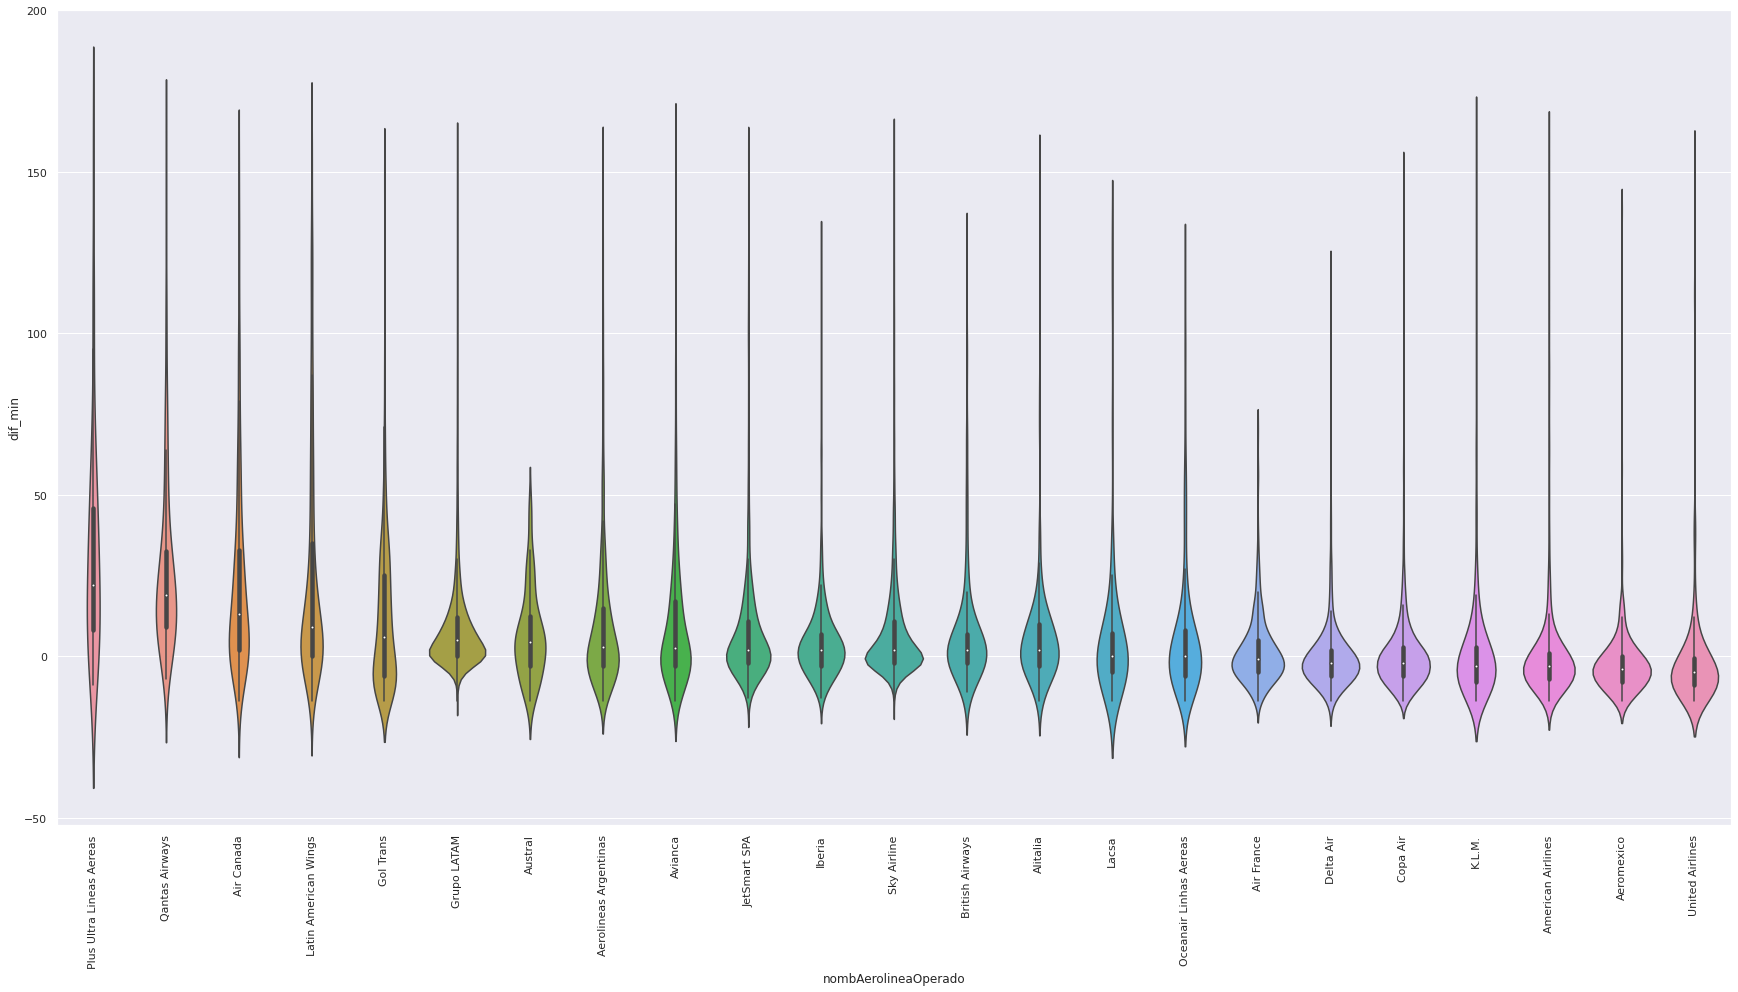

In [78]:
fig, ax = plt.subplots(1, figsize=(30,15))
sns.violinplot(x=df_analisis['nombAerolineaOperado'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["nombAerolineaOperado"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

Se observa lo siguiente:

- **Plus Ultra Líneas Aereas**, **Qantas Airways**, **Air Canada** son las aerolíneas que presentan altos valores de minutos de atraso a diferencia del resto de aerolíneas. Teniendo una mediana de 22,19 y 13 así como un promedio de minutos de atraso 31,26,22 respectivamente.
- **Oceanair Linhas Aereas**, **Lacsa**, **Sky Airline** son las aerolíneas que presentan bajos valores de minutos de atraso a diferencia del resto de aerolíneas. Teniendo una mediana de 0,0 y 2 así como un promedio de minutos de atraso 6,4,8 respectivamente.
- El rango de amplitud de minutos de atraso de la areolínea española **Plus Ultra Línea Aéreas** es amplia desde el primer al tercer cuartil, cuya mediana (22) es alta en comparación con el resto de aerolíneas. La desviación estandár (34.57) de los minutos de atraso es alta en comparación con el resto de aerolíneas debido a su alta dispersión de valores con respecto a la media, así como la presencia de valores outliers.
- El volumen de minutos (concentración) de atraso de la aerolínea **Grupo LATAM** es amplia **desde los 0 hasta los 5 minutos de atraso**. Tiene una alta desviación estandár ya que sus valores no son próximos a la media debido a la dispersión de sus valores


#### Minutos de atraso por tipo de vuelo

In [79]:
data_agrupada = df_analisis.groupby(['tipVuelo'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'tipVuelo_':'tipVuelo','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

tipVuelo  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
0        I       31240     10.638892             5.0    21.579424
1        N       36966      7.819510             3.0    17.060643

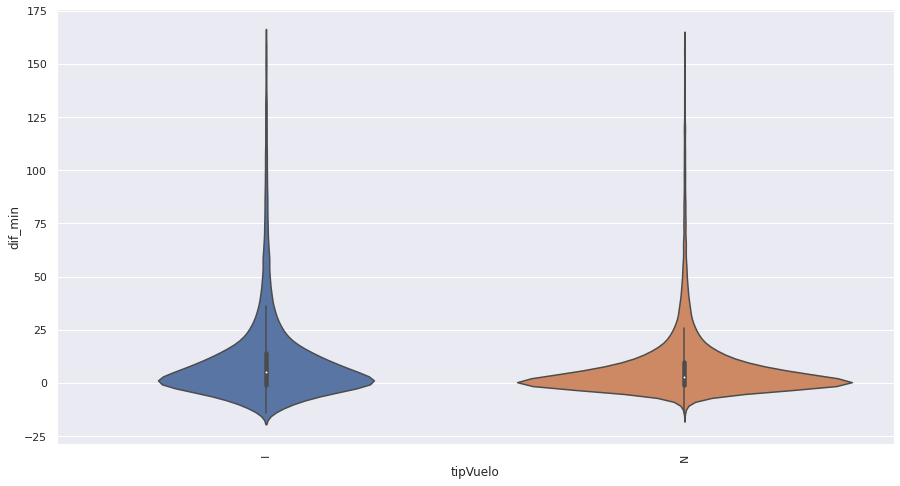

In [80]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.violinplot(x=df_analisis['tipVuelo'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["tipVuelo"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

Se observa lo siguiente:
- Se tiene una concentración en los minutos de atraso para los **Vuelos Nacionales** desde los 0 hasta los 3 min.
- Se tiene un mayor rango en los minutos de atraso para los **Vuelos Internacionales** debido a la variabilidad de sus valores, esto se evidencia con el alto valor de su desviación estandar (21.57 min)

#### Minutos de atraso por dia de la semana

In [81]:
data_agrupada = df_analisis.groupby(['diaSemVuelOperado'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'diaSemVuelOperado_':'diaSemVuelOperado','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

diaSemVuelOperado  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
6           Viernes       10292     10.891469             5.0    20.331720
1            Jueves       10251      9.521120             4.0    18.789608
2             Lunes       10131      9.980653             4.0    20.645717
0           Domingo        9796      7.930788             3.0    17.825904
3            Martes        9662      8.324777             3.0    18.846261
4         Miercoles        9722      8.540835             3.0    18.570424
5            Sabado        8352      8.315014             3.0    19.830023

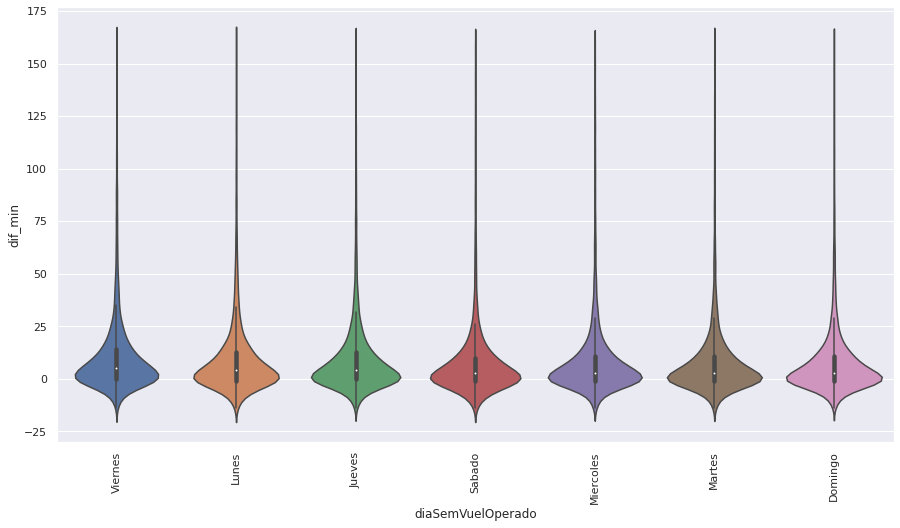

In [82]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.violinplot(x=df_analisis['diaSemVuelOperado'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["diaSemVuelOperado"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

Se observa que la proporción de viajes en cuanto al **dia de semana** no tiene mucha diferencia, son proporciones muy equitativas. Sin embargo la cantidad de minutos de atraso es mayor los **Lunes, Jueves y Viernes** que los **Martes, Miercoles, Sabado y Domingo**

#### Minutos de atraso por mes del año

In [83]:
data_agrupada = df_analisis.groupby(['mesVuelOperado'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'mesVuelOperado_':'mesVuelOperado','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

mesVuelOperado  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
6                7        5992     15.372163             7.0    25.457811
11              12        6356     11.849591             6.0    20.314042
9               10        6032     11.295922             5.0    21.559598
10              11        6080      9.342763             4.0    18.409677
0                1        6108      7.769646             3.0    16.710173
1                2        5561      7.537853             3.0    17.504430
4                5        5240      7.521756             3.0    16.920480
5                6        4981      8.542461             3.0    19.439951
7                8        5744      8.616818             3.0    19.041656
8                9        5610      8.497326             3.0    19.048354
2                3        5482      5.757205             2.0    16.781073
3                4        5020      5.773506             2.0    15.123701

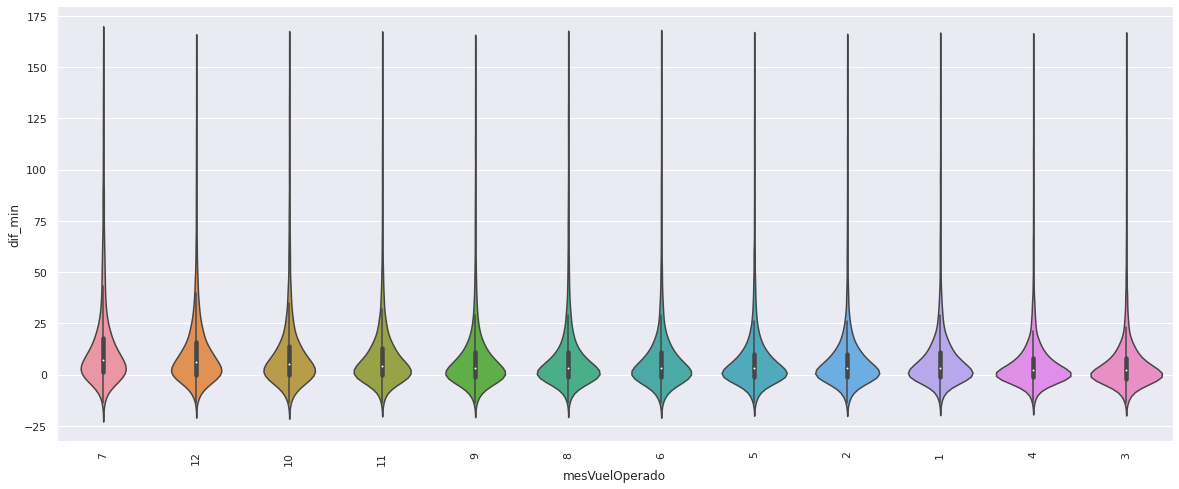

In [84]:
fig, ax = plt.subplots(1, figsize=(20,8))
sns.violinplot(x=df_analisis['mesVuelOperado'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["mesVuelOperado"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

Se observa lo siguiente:
- El **mes de Julio registra altos valores de minutos de atraso**. Teniendo una **mediana de 7 min** y un **promedio de 15.3 min de atraso**. El rango de amplitud de minutos de atraso es más amplio, lo que indica una mayor variabilidad, esto se comprueba con la **desviación estandár (25.45 min)**, la cual es la mayor con respecto al resto de los meses.
- **Marzo** y **Abril** son los meses que presentan bajos valores de minutos de atraso a diferencia del resto de meses. Ambos tienen una mediana de 2 min así como un **promedio 5.75 min. de atraso**. Por otro lado la **densidad** o concentración de puntos es muy amplio en los **2 min**.

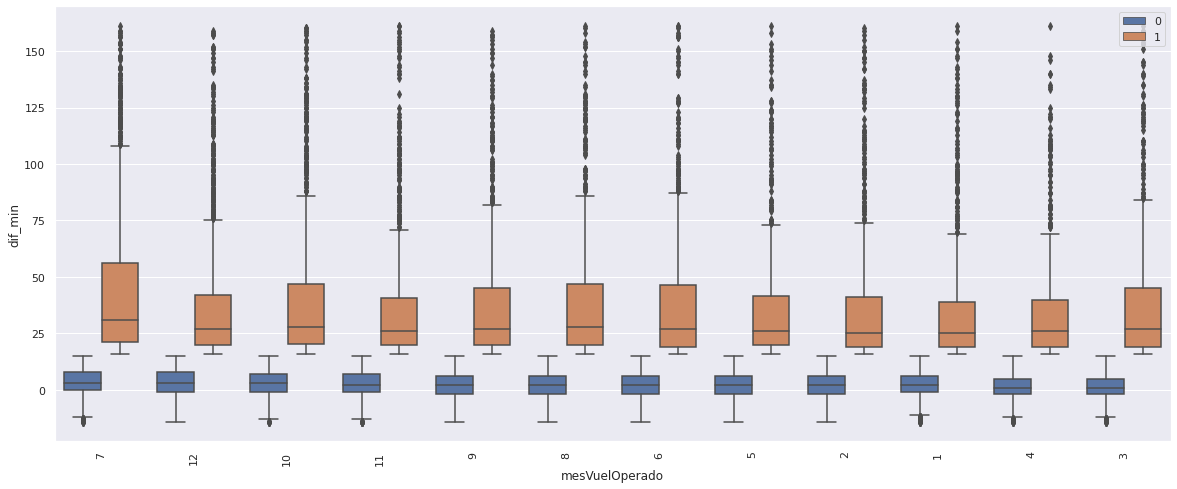

In [85]:
fig, ax = plt.subplots(1, figsize=(20,8))
sns.boxplot(x=df_analisis['mesVuelOperado'], y=df_analisis['dif_min'],hue=df_analisis['atraso_15'],
               order = df_analisis.groupby(by=["mesVuelOperado"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.show()

Se observa lo siguiente:
- El **mes de Julio registra altos valores de minutos de atraso**. Teniendo una **mediana de 7 min** y un **promedio de minutos de atraso de 15.3 min**. El rango de amplitud de minutos de atraso para la clase 1 (atraso_15==1) es más amplio, yendo **desde los 30 hasta los 50 minutos de atraso**.
- [inusual nevada en Santiago de Chile en Julio del 2017](https://www.bbc.com/mundo/noticias-america-latina-40620874). En el 2017 Santiago de Chile vivió la mayor nevada en la última década en la madrugada del sábado.El fenómeno climático dejó una persona muerta, dos heridos y más de 300.000 hogares sin suministro eléctrico.
- **Esto permite tomar en cuenta que las condiciones climáticas afectan la tasa de atraso de un vuelo**. Así como se mencionó el análisis de las ciudad de destino.

#### Creación de la variable condición metereologica

Se crea la variable **cond_meteorologica** que permite describir inusual nevada en Santiago de Chile que provocó un muerto, dos heridos y más de 300.000 casas sin luz en Julio del 2017

In [86]:
def fx_cond_meteorologica_inusual(x):
  if x==7:
    return 'SI'
  else:
    return 'NO'

df_analisis['condMeteorologica'] = df_analisis['mesVuelOperado'].apply(lambda x: fx_cond_meteorologica_inusual(x))

In [87]:
df_analisis.condMeteorologica.value_counts()

NO    62214
SI     5992
Name: condMeteorologica, dtype: int64

In [88]:
df_analisis.mesVuelOperado.value_counts()

12    6356
1     6108
11    6080
10    6032
7     5992
8     5744
9     5610
2     5561
3     5482
5     5240
4     5020
6     4981
Name: mesVuelOperado, dtype: int64

Se comprueba que se tiene la misma cantidad de números de vuelos que el mes de Julio

#### Minutos de atraso por temporada

In [89]:
data_agrupada = df_analisis.groupby(['temporada_alta'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'temporada_alta_':'temporada_alta','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

temporada_alta  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
1              1       10155     12.067848             5.0    22.340209
0              0       58051      8.593582             3.0    18.685899

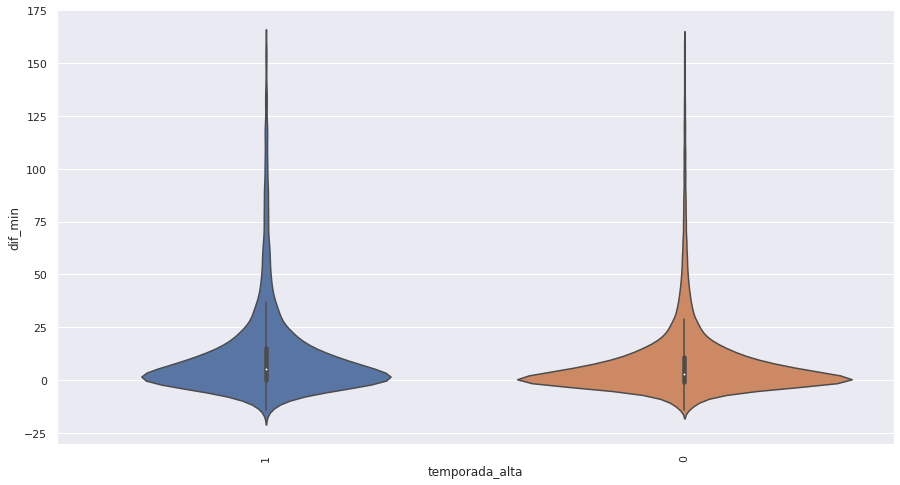

In [90]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.violinplot(x=df_analisis['temporada_alta'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["temporada_alta"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

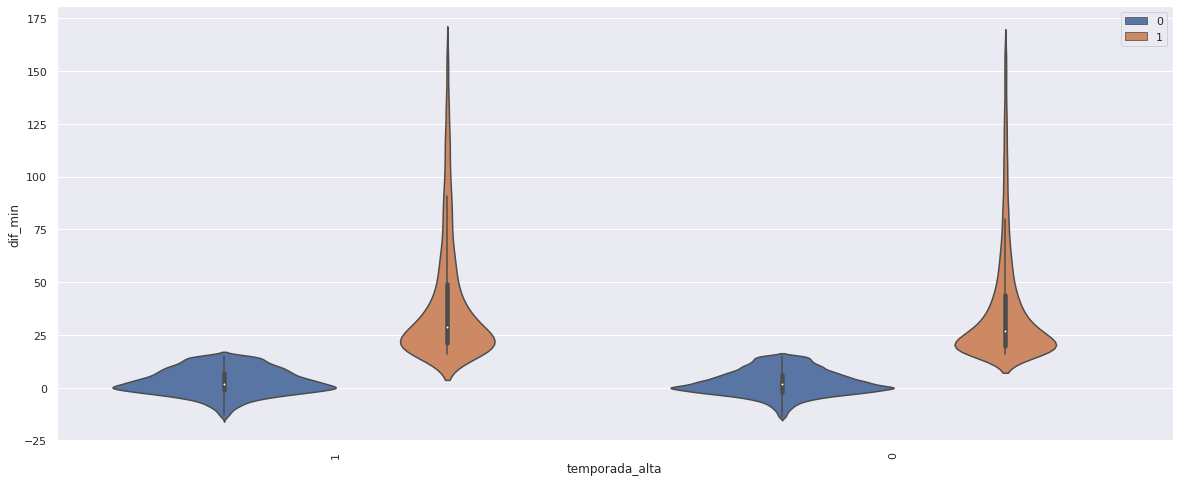

In [91]:
plt.subplots(1, figsize=(20,8))
sns.violinplot(x=df_analisis['temporada_alta'], y=df_analisis['dif_min'],hue=df_analisis['atraso_15'],
               order = df_analisis.groupby(by=["temporada_alta"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.show()

Se observa lo siguiente:

- La variable definida como **temporada_alta** presenta una mayor cantidad de minutos de retraso. Su media y mediana son más altas que los vuelos de temporada baja.
- Ambos tiene una alta desviación estandar, sin embargo la variabilidad de los minutos de atraso para los vuelos de **temporada alta** es mayor. Teniendo una desviación estandar de 22.34 min frente a 18.68 min.
- El rango de amplitud de minutos de atraso de los vuelos de temporada alta para la clase 1 (atraso_15==1) es más amplio, yendo **desde los 25 hasta los 50 minutos de atraso**.
- La densidad de minutos de atraso de los vuelos de temporada baja para la clase 1 (atraso_15==1) está más concentrada en los 25 min.

#### Minutos de atraso por periodo

In [92]:
data_agrupada = df_analisis.groupby(['periodo_dia'],as_index=False).agg({'atraso_15': 'count','dif_min': ['mean','median','std']})
data_agrupada.columns = ['_'.join(map(str,col)).strip() for col in data_agrupada.columns.values]
data_agrupada.rename(columns={'periodo_dia_':'periodo_dia','atraso_15_count':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['dif_min_median'],ascending=False)

periodo_dia  nro_vuelos  dif_min_mean  dif_min_median  dif_min_std
2       tarde       25506      9.757155             4.0    18.857409
0      mañana       25352      8.061534             3.0    18.186330
1       noche       17348      9.694086             3.0    21.397243

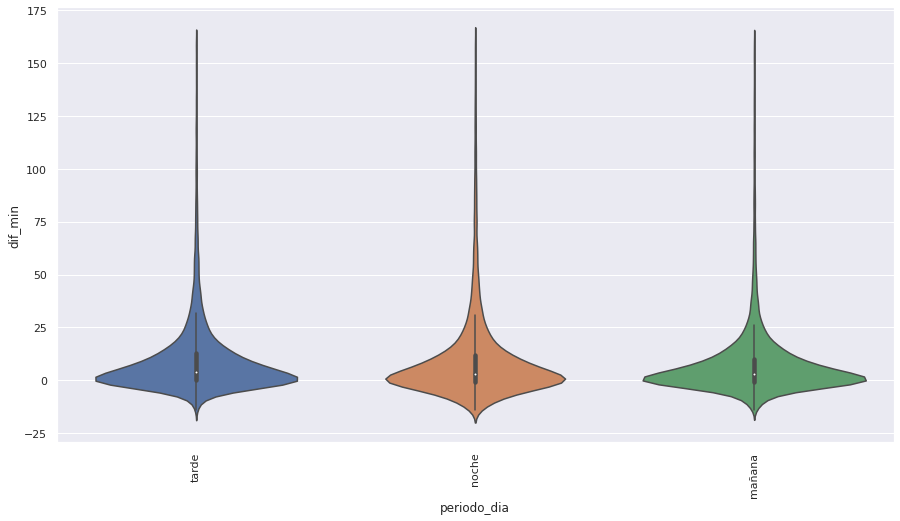

In [93]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.violinplot(x=df_analisis['periodo_dia'], y=df_analisis['dif_min'],
            order = df_analisis.groupby(by=["periodo_dia"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.show()

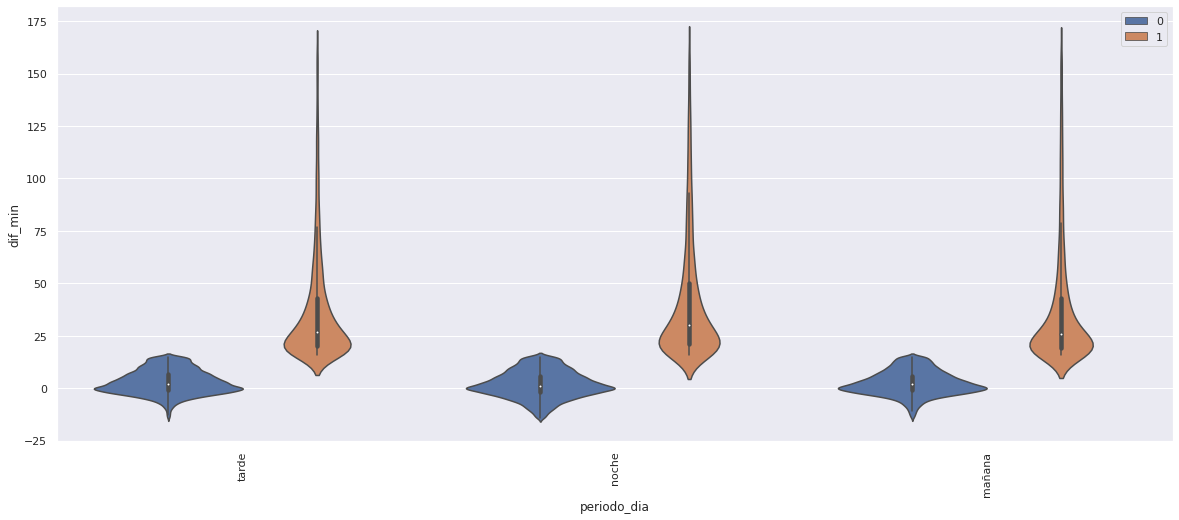

In [94]:
plt.subplots(1, figsize=(20,8))
sns.violinplot(x=df_analisis['periodo_dia'], y=df_analisis['dif_min'],hue=df_analisis['atraso_15'],
               order = df_analisis.groupby(by=["periodo_dia"])["dif_min"].median().sort_values().iloc[::-1].index)
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.show()

- Se observa que la mayoria de las personas prefiere viajar por la **mañana** y la **tarde**. 
- La cantidad de minutos de atraso es mayor en la tarde y en la noche.
- El rango de amplitud de minutos de atraso de los **vuelos de noche** para la clase 1 (atraso_15==1) es más amplio, yendo **desde los 25 hasta los 75 minutos de atraso**.
- La densidad de minutos de atraso de los **vuelos de la mañana** para la clase 1 (atraso_15==1) está más concentrada en los 25 min.

### Análisis de las rutas de mayor frecuencia (Grafos)

In [95]:
data_agrupada = df_analisis.groupby(['nombCiudadOrig','nombCiudadDest'],as_index=False).agg({'atraso_15': 'count'})
data_agrupada.rename(columns={'atraso_15':'nro_vuelos'},inplace=True)
data_agrupada.sort_values(by=['nro_vuelos'],ascending=False,inplace=True)
data_agrupada["% Total"] = data_agrupada['nro_vuelos']/len(df_analisis)*100
data_agrupada.head(10)

nombCiudadOrig nombCiudadDest  nro_vuelos   % Total
8        Santiago   Buenos Aires        6335  9.288039
0        Santiago    Antofagasta        5786  8.483125
28       Santiago           Lima        5270  7.726593
9        Santiago         Calama        5146  7.544791
42       Santiago   Puerto Montt        4357  6.388001
16       Santiago     Concepcion        3993  5.854324
24       Santiago        Iquique        3747  5.493652
54       Santiago      Sao Paulo        3569  5.232677
56       Santiago         Temuco        2589  3.795854
1        Santiago          Arica        2436  3.571533

Se contempla el análisis de las rutas de mayor y menor frecuencia que indican cuales son los orígenes y destinos con más y menos número de vuelos (densidad), sin embargo como se aprecia la ciudad de origen es la misma para todos los vuelos. 

Este tipo de análisis puede ser de vital importancia en caso se tengan múltiples origenes, ya que permite saber cuales son las rutas de mayor y menor frecuencia

**Así mismo se podría considerar el análisis de las rutas mediante el análisis de grafos considerando como conectores:**
- Tasa de Atraso
- Cantidad de vuelos

Se puede implementar este tipo de análisis para una mejor comprensión de la densidad de los nodos.

In [96]:
df_analisis.drop('nombCiudadOrig', axis=1, inplace=True)

Se procede a eliminar esta variable ya que tiene un solo valor. No aporta nada en el proceso de aprendizaje ya que no permite diferenciar una clase de otra

### Análisis de los vuelos Programados vs Operados

Se realiza el análisis de las siguientes variables:
*   **nroVuelProg**
*   **codCiudadDestProg**
*   **codAerolineaVuelProg**


*   **nroVuelOperado**
*   **codCiudadDestOperado**
*   **codAerolineaVuelOperado**


In [97]:
df_analisis[['nroVuelProg','nroVuelOperado','codCiudadDestProg','codCiudadDestOperado','codAerolineaVuelProg','codAerolineaVuelOperado']].describe(include='all')

nroVuelProg nroVuelOperado codCiudadDestProg codCiudadDestOperado  \
count        68206          68206             68206                68206   
unique         584            861                64                   63   
top            174            174              SCFA                 SCFA   
freq           686            650              5787                 5786   

       codAerolineaVuelProg codAerolineaVuelOperado  
count                 68206                   68206  
unique                   30                      32  
top                     LAN                     LAN  
freq                  37611                   20988

In [98]:
df_analisis.nroVuelProg.value_counts(normalize = True).head(30)*100

174    1.005777
11     0.945665
116    0.891417
150    0.816644
704    0.815178
162    0.810779
164    0.806381
118    0.744803
172    0.730141
170    0.725743
146    0.665631
120    0.645105
281    0.628977
136    0.612849
1      0.596722
114    0.590857
138    0.586459
134    0.573263
122    0.567399
130    0.567399
126    0.554203
702    0.554203
43     0.551271
142    0.546873
124    0.543940
912    0.542474
112    0.539542
7      0.535144
802    0.533677
285    0.533677
Name: nroVuelProg, dtype: float64

In [99]:
df_analisis.nroVuelOperado.value_counts(normalize = True).head(30)*100

174     0.952995
11      0.947131
116     0.891417
150     0.757998
704     0.753599
162     0.750667
164     0.744803
118     0.743336
172     0.683224
170     0.662698
146     0.652435
120     0.615782
1       0.583526
136     0.582060
122     0.555670
130     0.554203
281     0.549805
43      0.546873
114     0.543940
138     0.542474
912     0.542474
134     0.542474
142     0.541008
7       0.535144
112     0.533677
7663    0.532211
6830    0.530745
51      0.527813
8161    0.526347
124     0.523414
Name: nroVuelOperado, dtype: float64

Se puede observar muchas categorias en las variables **nroVuelProg** y **nroVuelOperado**, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra, por lo que se decide no tomarlas en cuenta para la etapa de aprendizaje

In [100]:
df_analisis.codCiudadDestProg.value_counts(normalize = True).head(30)*100

SCFA    8.484591
SPJC    7.726593
SCCF    7.543325
SCTE    6.388001
SCIE    5.857256
SCDA    5.493652
SBGR    5.234144
SAEZ    4.750315
SABE    4.536258
SCQP    3.787057
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.102454
SUMU    1.562912
SACO    1.499868
KMIA    1.488139
LEMD    1.310735
SCBA    1.235962
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.620180
KJFK    0.561534
NZAA    0.529279
LFPG    0.526347
Name: codCiudadDestProg, dtype: float64

In [101]:
df_analisis.codCiudadDestOperado.value_counts(normalize = True).head(30)*100

SCFA    8.483125
SPJC    7.726593
SCCF    7.544791
SCTE    6.388001
SCIE    5.854324
SCDA    5.493652
SBGR    5.232677
SAEZ    4.751781
SABE    4.536258
SCQP    3.795854
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.103920
SUMU    1.562912
SACO    1.499868
KMIA    1.489605
LEMD    1.310735
SCBA    1.230097
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.618714
KJFK    0.560068
NZAA    0.529279
LFPG    0.526347
Name: codCiudadDestOperado, dtype: float64

A pesar que estas variables tienen bastantes categorias, agrupandolas según **CONVERSION CON RESPECTO AL TARGET(TASA DE RETRASO)** o **FRECUENCIA DE VUELOS** pueden resultar útiles para el modelo 

In [102]:
df_analisis.codAerolineaVuelProg.value_counts(normalize = True)*100

LAN    55.143243
SKU    20.962965
TAM     4.470281
ARG     2.857520
CMP     2.712371
LAW     2.307715
AVA     1.689001
JAT     1.605431
GLO     1.181714
AAL     1.109873
ACA     0.828373
IBE     0.530745
AFR     0.524881
DAL     0.524881
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.316688
BAW     0.300560
QFU     0.285899
JMR     0.146615
LRC     0.134885
AUT     0.108495
PUE     0.071841
LXP     0.013195
LPE     0.005865
DSM     0.002932
LNE     0.001466
Name: codAerolineaVuelProg, dtype: float64

In [103]:
df_analisis.codAerolineaVuelOperado.value_counts(normalize = True)*100

LAN    30.771486
LXP    21.344163
SKU    20.962965
TAM     4.465883
ARG     2.853121
CMP     2.712371
JMR     2.414744
LPE     1.779902
JAT     1.605431
AVA     1.297540
GLO     1.181714
AAL     1.109873
ACA     0.828373
DSM     0.722810
LNE     0.548339
IBE     0.530745
AFR     0.524881
DAL     0.524881
LRC     0.523414
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.321086
BAW     0.300560
QFA     0.285899
AUT     0.112893
PUE     0.071841
56R     0.024924
48O     0.014661
TPU     0.002932
Name: codAerolineaVuelOperado, dtype: float64

A pesar que estas variables tienen bastantes categorias, agrupandolas según **CONVERSION CON RESPECTO AL TARGET(TASA DE RETRASO)** o **FRECUENCIA DE VUELOS** pueden resultar útiles para el modelo 

- El 75% de la variable **codAerolineaVuelProg** se reparte entre LAN y SKU, teniendo una frecuencia en el número de vuelos de 55% y 20% respectivamente
- El 73% de la variable **codAerolineaVuelOperado** se reparte entre LAN, LXP y SKU, teniendo una frecuencia en el número de vuelos de 31%, 21% y 21% respectivamente



#### Creacion de la hora en base a la Fecha operativa del vuelo

In [104]:
df_analisis['horaOperVuelo']=df_analisis['fecVuelOperado'].dt.hour

In [105]:
df_analisis["horaOperVuelo"]=df_analisis['horaOperVuelo'].astype('str')

In [106]:
df_analisis.horaOperVuelo.value_counts(normalize= True)*100

7     6.700290
8     6.364543
18    5.678386
14    5.668123
6     5.659326
15    5.621206
19    5.459930
11    5.207753
13    5.137378
17    5.118318
9     5.113920
12    5.043545
16    4.762044
20    4.448289
5     3.835440
10    3.759200
21    3.465971
22    3.297364
1     2.468991
23    1.985163
4     1.735918
0     1.693399
2     0.974988
3     0.800516
Name: horaOperVuelo, dtype: float64

#### Creación de campos de validación para revisar si lo programado es igual a lo operado

In [107]:
# Validación para ver si lo programado es igual a lo operado
df_analisis['cambioNroVuelo'] = df_analisis.apply(lambda x: '0' if x['nroVuelProg']==x['nroVuelOperado'] else '1', axis=1)
df_analisis['cambioCodCiudadDest'] = df_analisis.apply(lambda x: '0' if x['codCiudadDestProg']==x['codCiudadDestOperado'] else '1', axis=1)
df_analisis['cambioCodAerolineaVuelo'] = df_analisis.apply(lambda x:'0' if x['codAerolineaVuelProg']==x['codAerolineaVuelOperado'] else '1', axis=1)

In [108]:
print(df_analisis.groupby(df_analisis['cambioNroVuelo']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodCiudadDest']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodAerolineaVuelo']).size())

cambioNroVuelo
0    63687
1     4519
dtype: int64
------------
cambioCodCiudadDest
0    68178
1       28
dtype: int64
------------
cambioCodAerolineaVuelo
0    49537
1    18669
dtype: int64


- El **nroVuelProg** y **nroVuelOperado** se observa que tienen diferencias en sus categorias. El número de vuelo programado cambio con respecto al operado en un **6.6%** del total de vuelos.
- El **codCiudadDestProg** y **codCiudadDestOperado** se observa que tienen diferencias en sus categorias. La ciudad destino programado cambio con respecto al operado en un **0.04%%** del total de vuelos.
- El **codAerolineaVuelProg** y **codAerolineaVuelOperado** se observa que tienen diferencias en sus categorias. El código de la aerolínea programada cambio con respecto al operado en un **27.37%%** del total de vuelos

Las nuevas variables. **cambioNroVuelo**, **cambioCodAerolineaVuelo** tienen la posibilidad de ser empleadas en el proceso de entrenamiento. Por otro lado las variable **cambioCodCiudadDest** no serán usadas debido a la baja varianza.


In [109]:
df_analisis.drop('cambioCodCiudadDest', axis=1, inplace=True)

Se puede observar muchas categorias en las variables **nroVuelProg** y **nroVuelOperado** y ninguna de las categorias reune un porcentaje mayor con respecto a otra, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra. En ese sentido se omite las siguientes campos dado que tienen mucha variabilidad (se puede observar que existen demasiadas categorías en las variables) lo cual no ayudaria a hacer alguna distinción con el target:

nro. de categorias en **nroVuelProg**: 584

nro. de categorias en **nroVuelOperado** : 861

**Si no se desea omitir una alternativa es conversar con el negocio para que nos proporcione un mejor entendiminto de estas variables y asi poder considerarlas.**

In [110]:
df_analisis.drop('nroVuelProg', axis=1, inplace=True)
df_analisis.drop('nroVuelOperado', axis=1, inplace=True)

### Análisis de la tasa de atraso (Conversión con el target)

Para realizar el análisis de la tasa de atraso por categoría de cada variable cualitativa (pudiendo ser cuantitativa dividida en deciles) se emplea la tasa de conversión del target que me interesa (retraso_15=1). **Se calcula tomando la cantidad de valores de retraso_15=1 con respecto al total de valores de cada categoría**

In [111]:
# Se realiza una copia del dataframe de análisis
df_analisis_bi = df_analisis.copy()

In [112]:
# División de las variables según naturaleza
feat_numerical_bi = ['dif_min']

feat_categorical_bi = [
 'codCiudadDestProg',
 'codAerolineaVuelProg',
 'codCiudadDestOperado',
 'codAerolineaVuelOperado',
 'diaSemVuelOperado',
 'mesVuelOperado',
 'tipVuelo',
 'nombAerolineaOperado',
 'nombCiudadDest',
 'temporada_alta',
 'periodo_dia',
 'horaOperVuelo',
 'cambioNroVuelo',
 'cambioCodAerolineaVuelo',
 'condMeteorologica']

In [113]:
# Conversion del tipo de dato
df_analisis_bi['atraso_15']=df_analisis_bi['atraso_15'].astype('int64')

for var in feat_categorical_bi:
  df_analisis_bi[var] = df_analisis_bi[var].astype('category')

In [114]:
# Creación del dataframe meta
v=pd.DataFrame({"variable": df_analisis_bi.columns.values})
t=pd.DataFrame({"tipo": df_analisis_bi.dtypes.values})
meta=pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category'),:]
meta

variable      tipo
1         codCiudadDestProg  category
2      codAerolineaVuelProg  category
4      codCiudadDestOperado  category
5   codAerolineaVuelOperado  category
6            mesVuelOperado  category
7         diaSemVuelOperado  category
8                  tipVuelo  category
9      nombAerolineaOperado  category
10           nombCiudadDest  category
13           temporada_alta  category
14              periodo_dia  category
15        condMeteorologica  category
16            horaOperVuelo  category
17           cambioNroVuelo  category
18  cambioCodAerolineaVuelo  category

En el siguiente reporte se muestra el análisis de la tasa de atraso por categoría de cada variable cualitativa (pudiendo ser cuantitativa dividida en deciles) se emplea la tasa de conversión del target que me interesa (retraso_15=1). **Se calcula tomando la cantidad de valores de retraso_15=1 con respecto al total de valores de cada categoría**

codCiudadDestProg


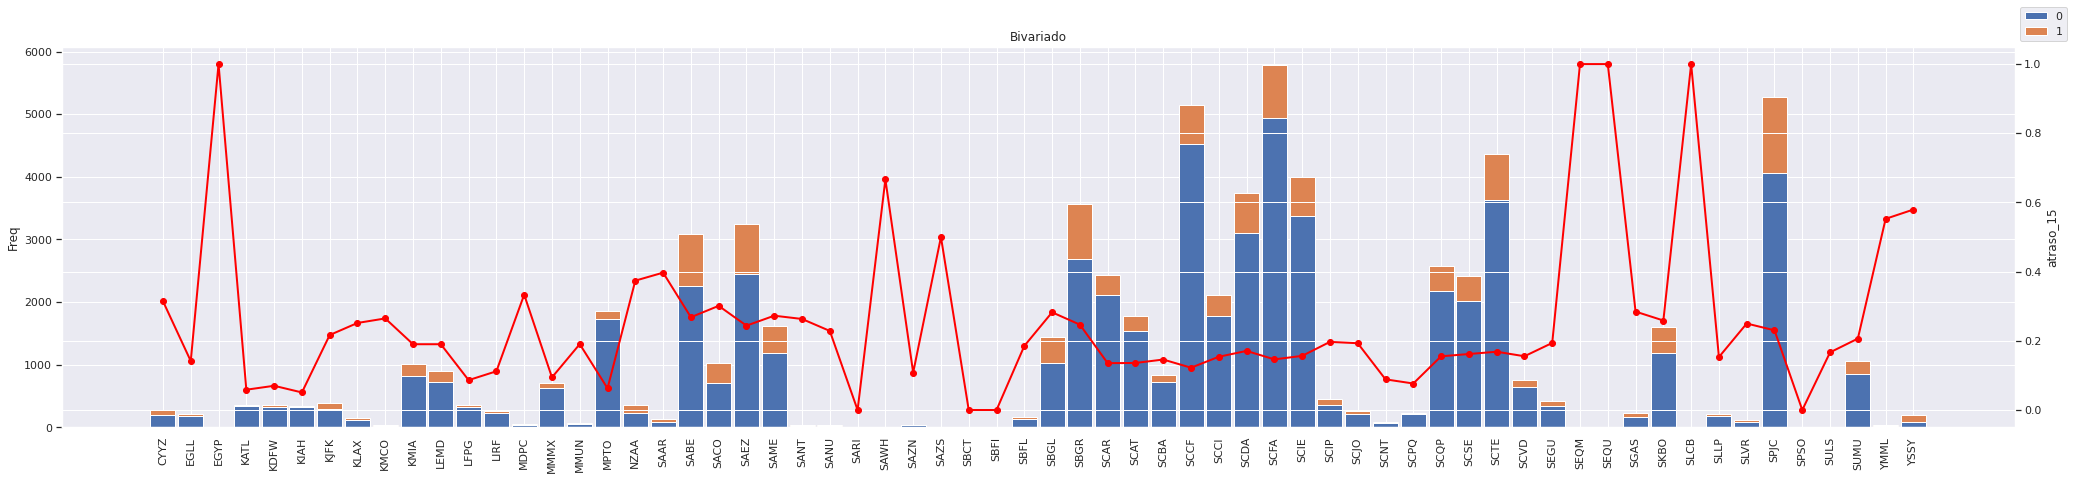

codAerolineaVuelProg


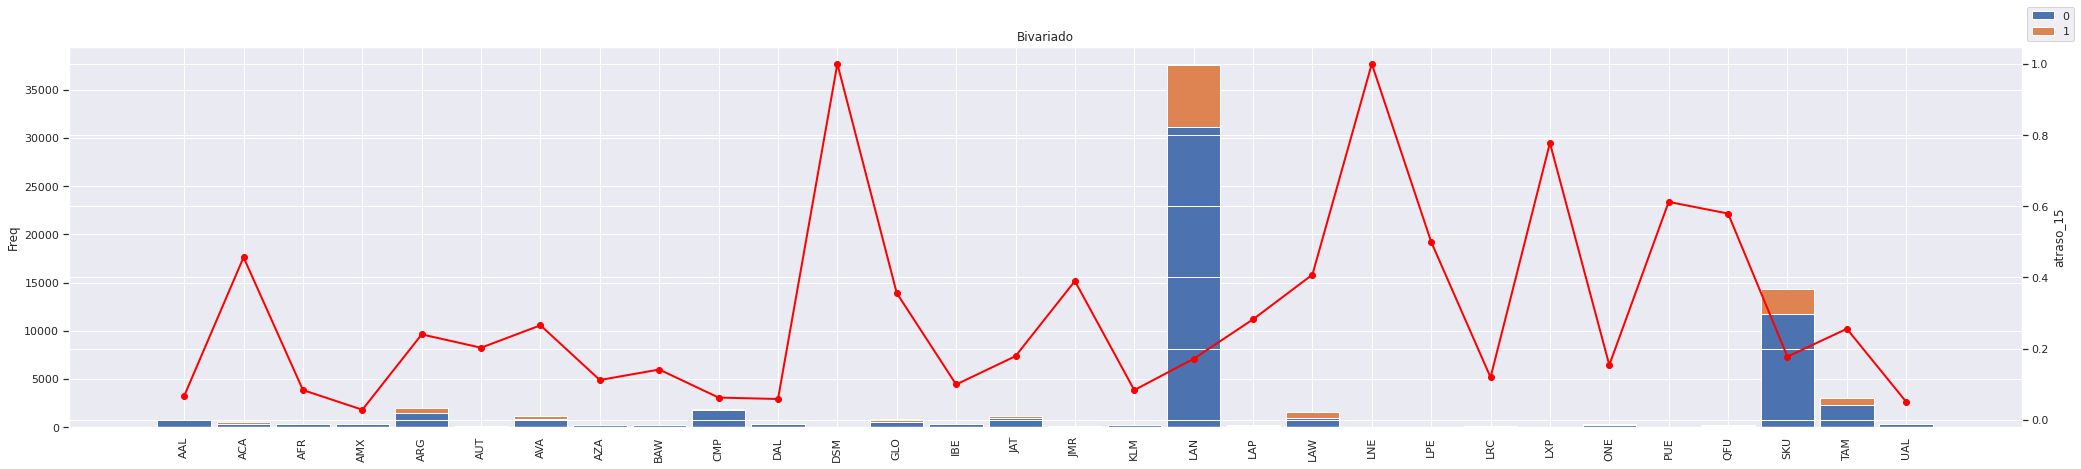

codCiudadDestOperado


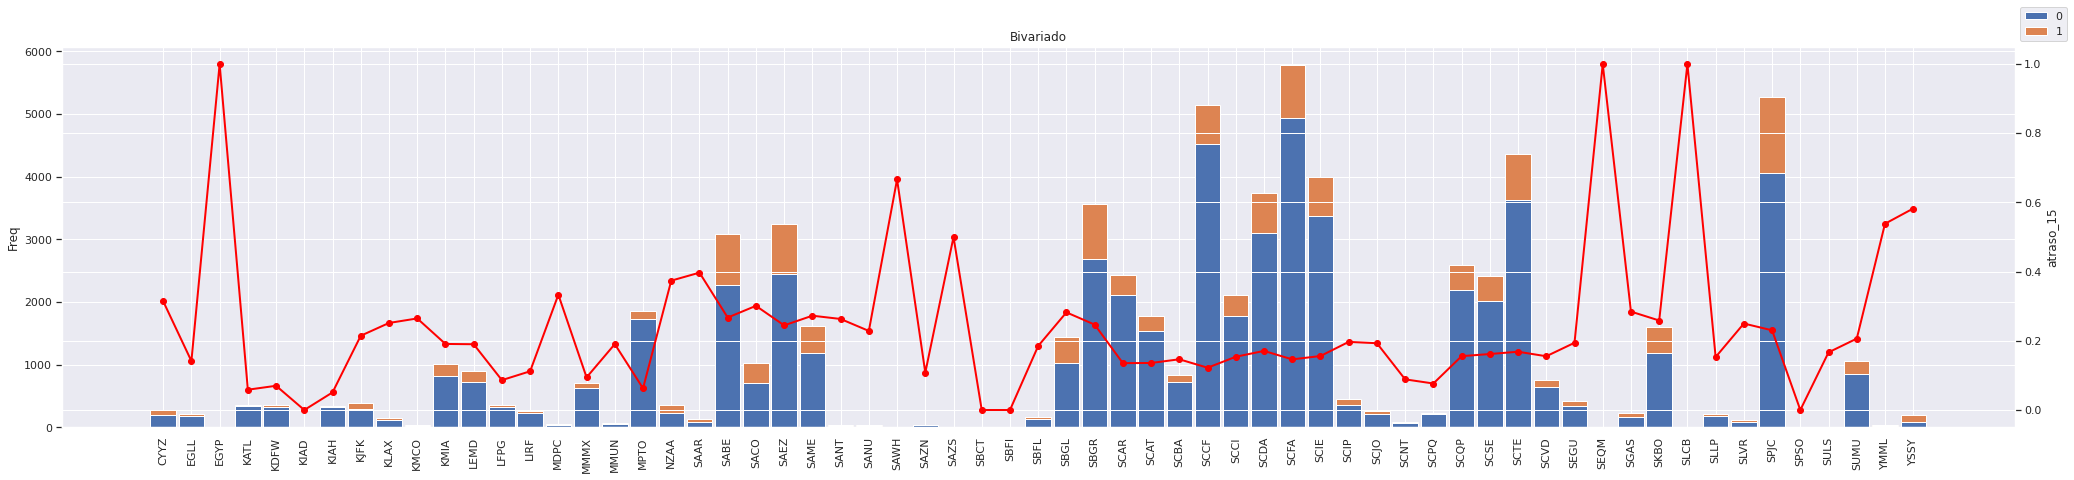

codAerolineaVuelOperado


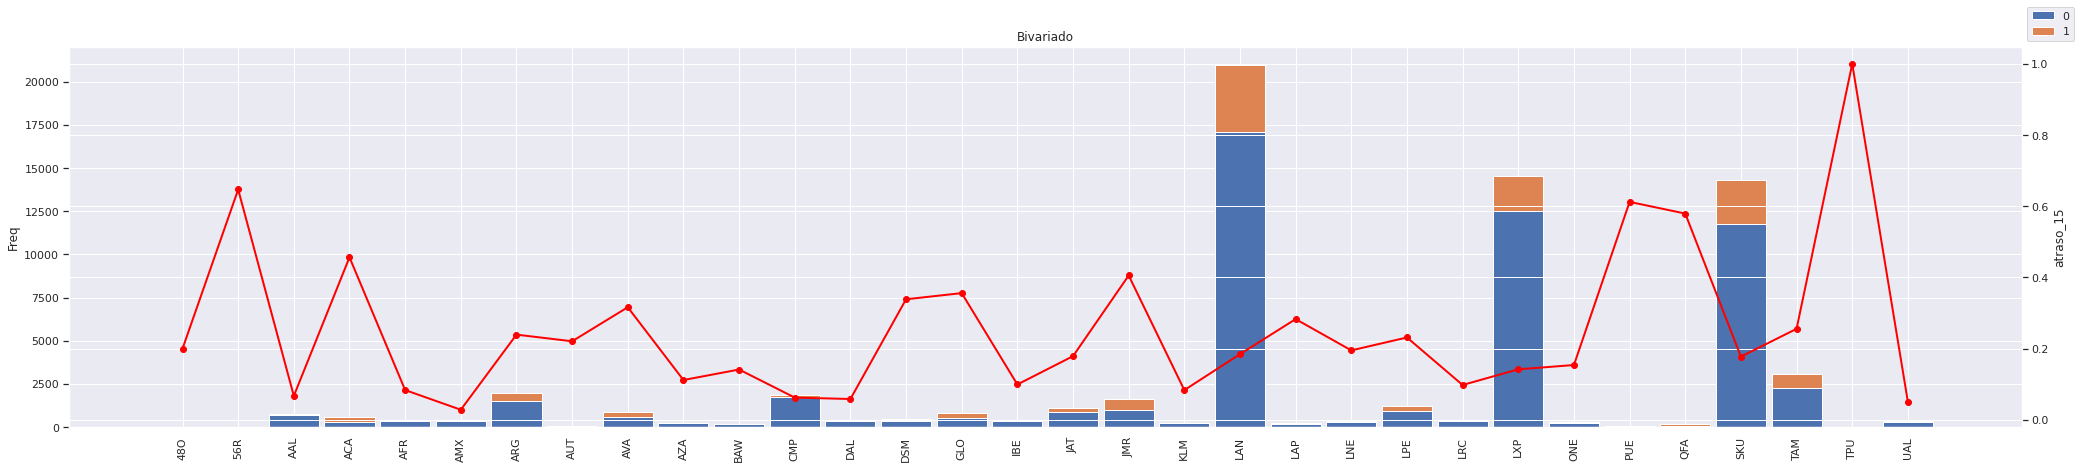

mesVuelOperado


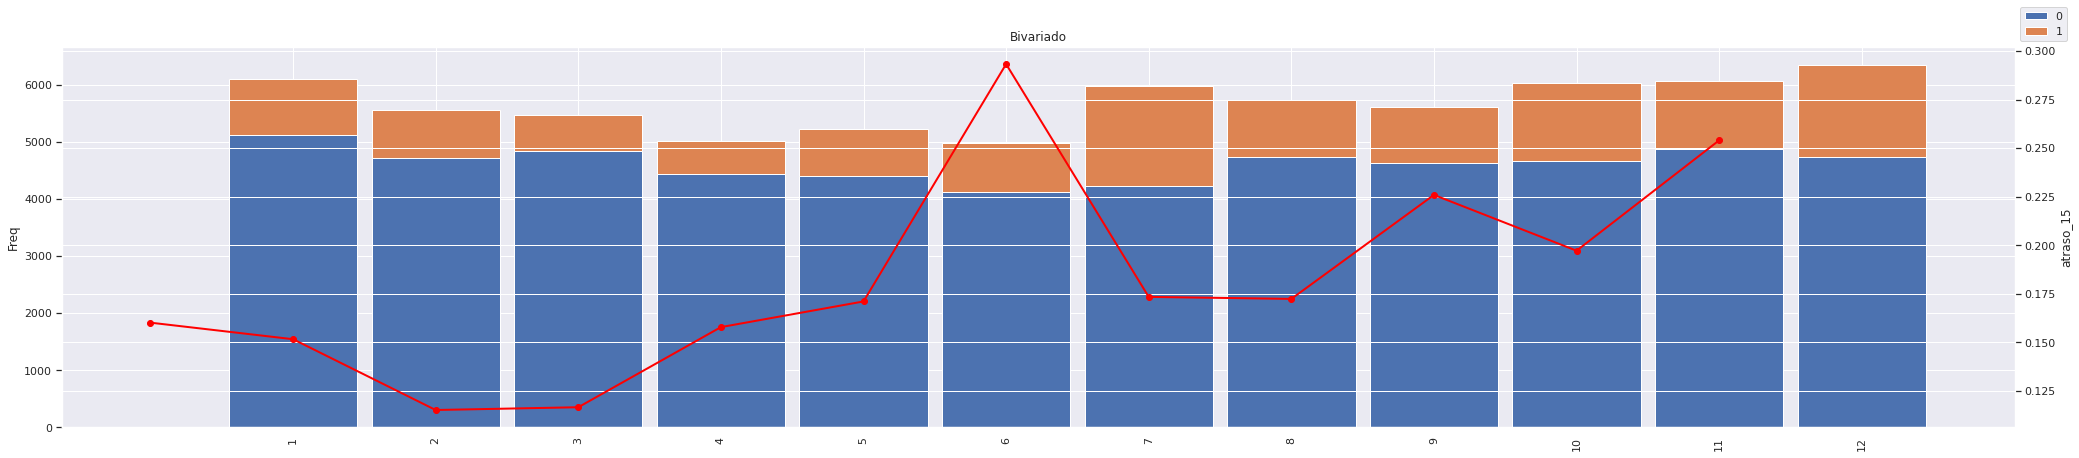

diaSemVuelOperado


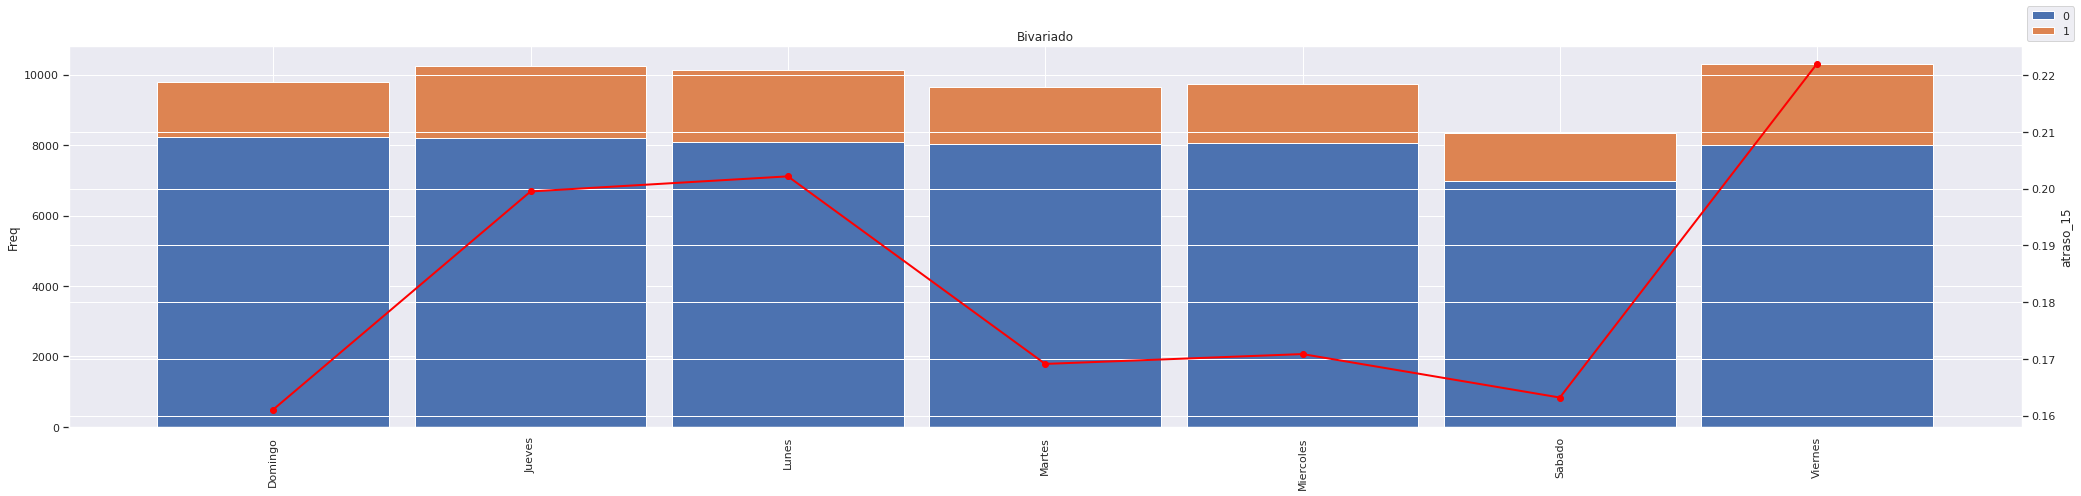

tipVuelo


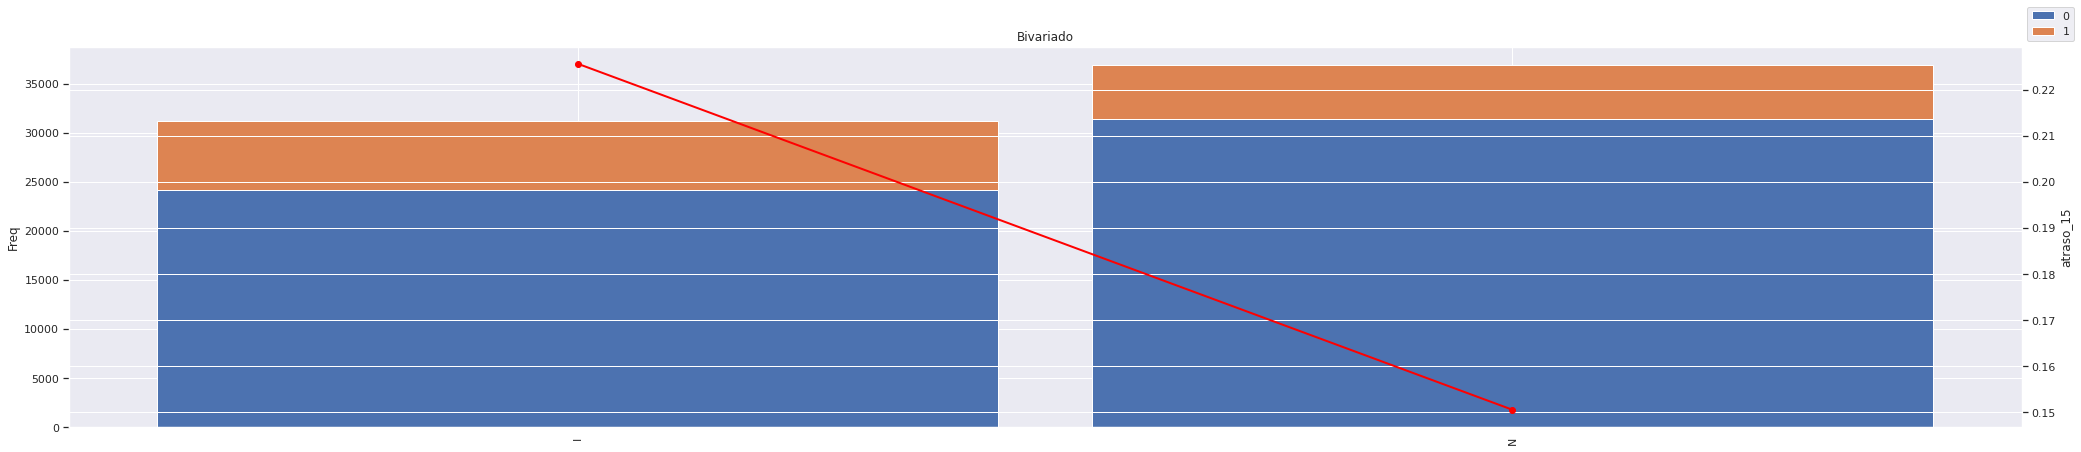

nombAerolineaOperado


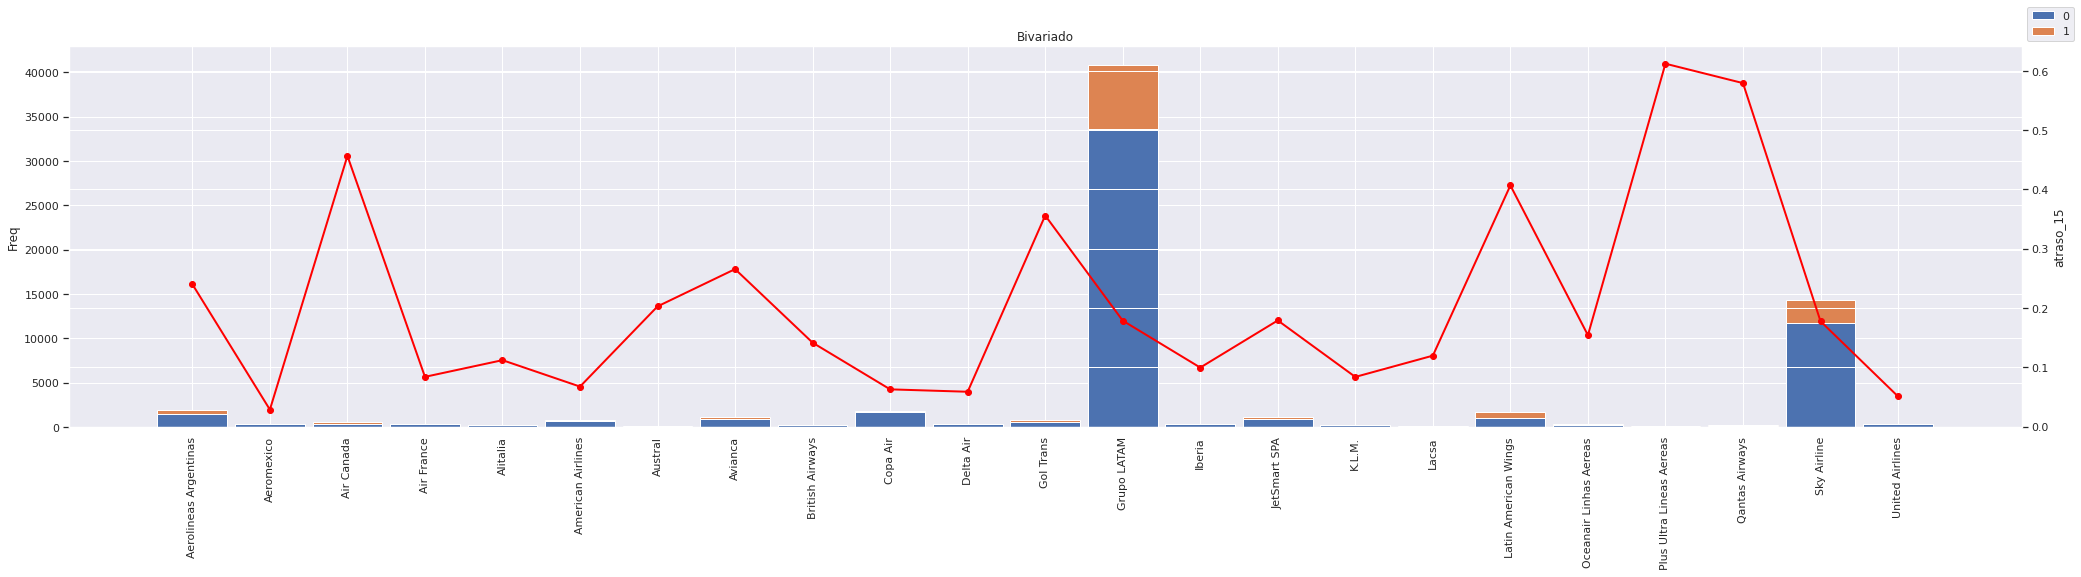

nombCiudadDest


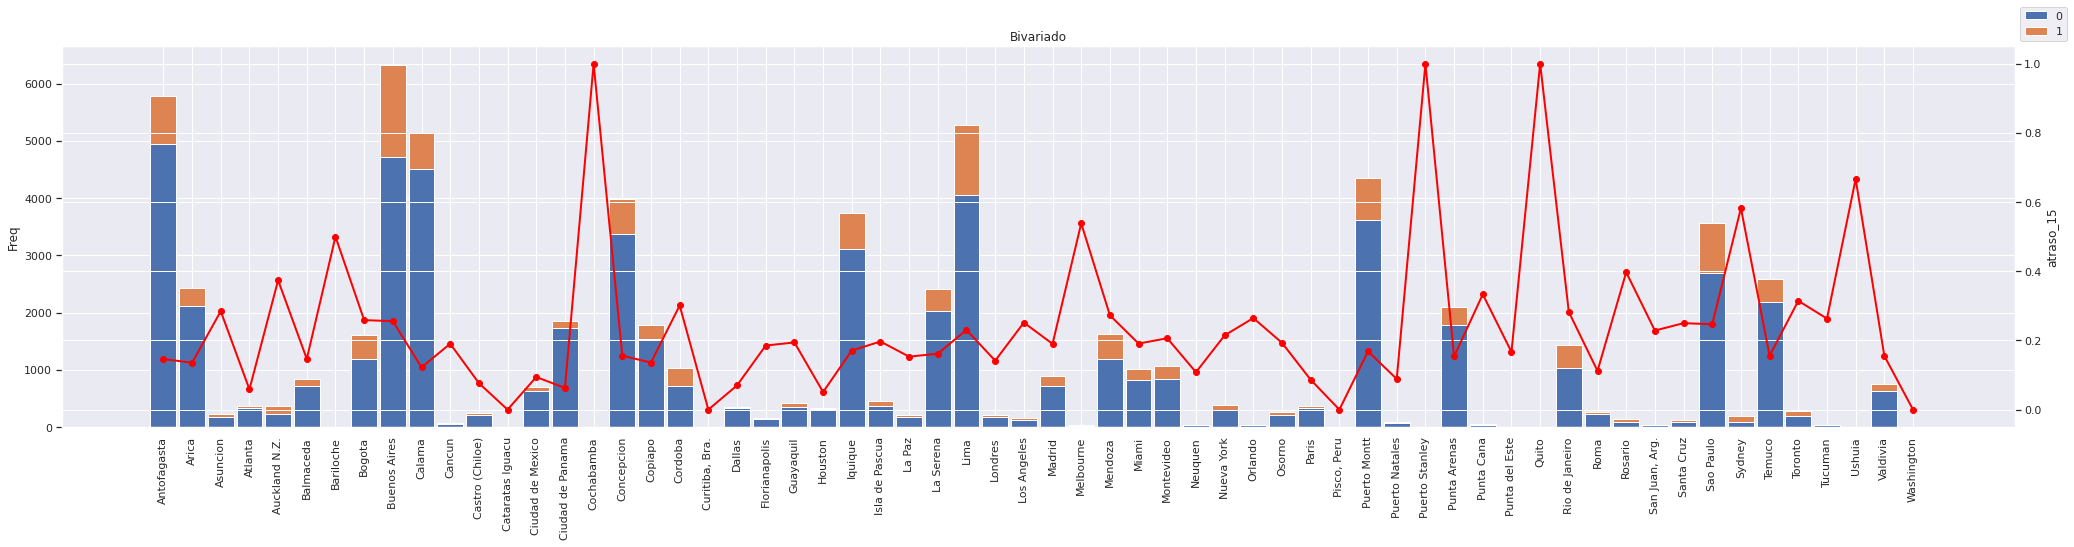

temporada_alta


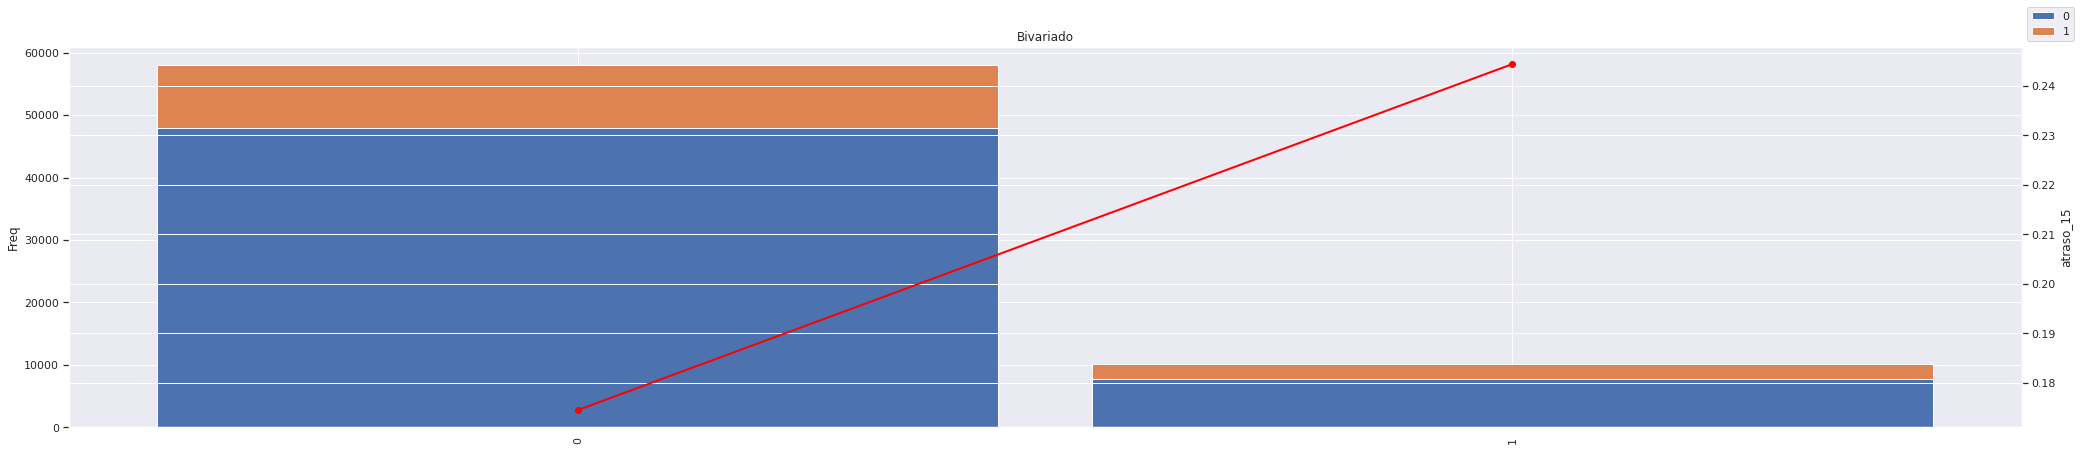

periodo_dia


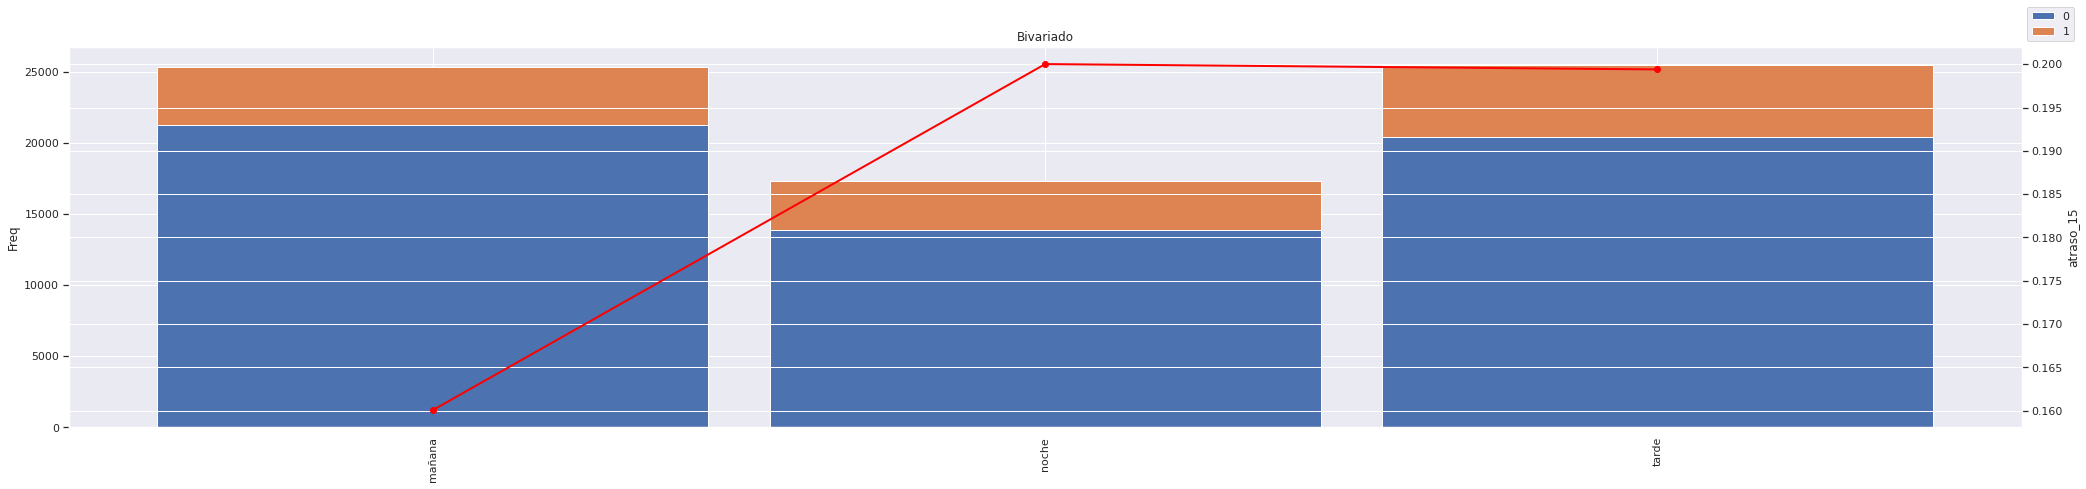

condMeteorologica


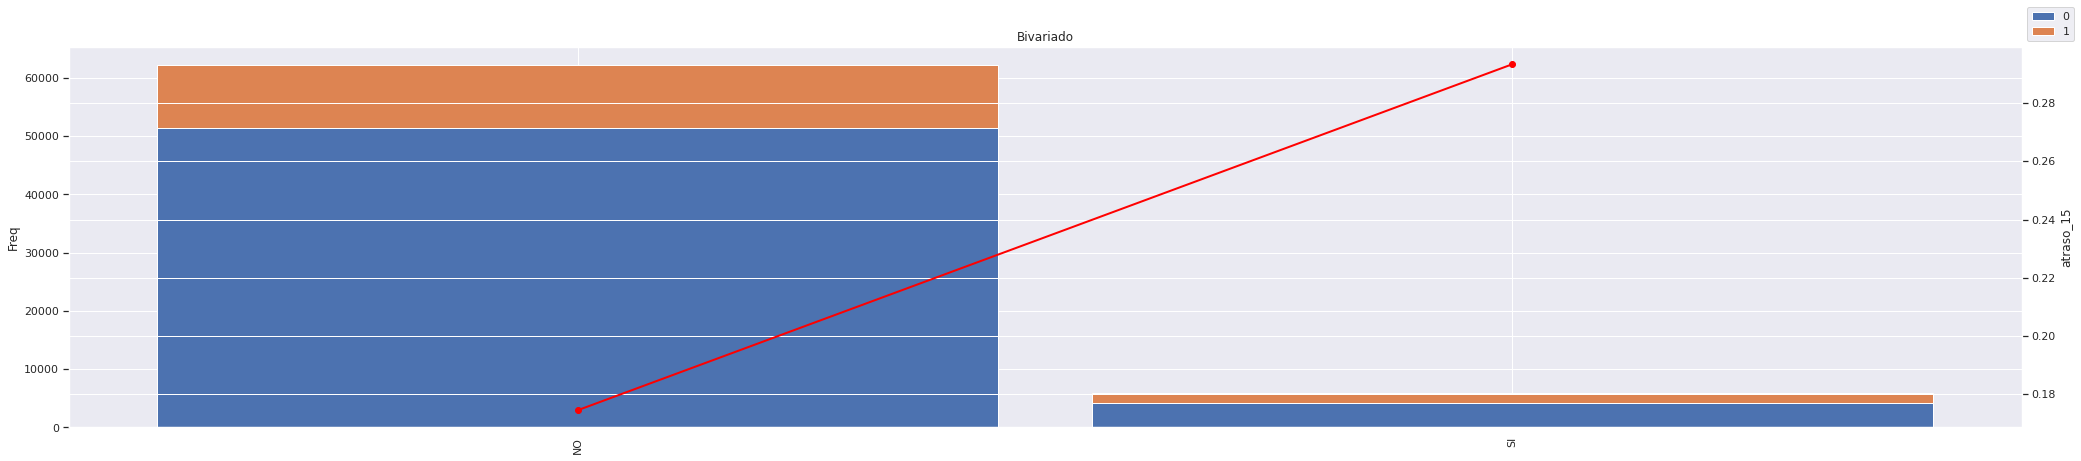

horaOperVuelo


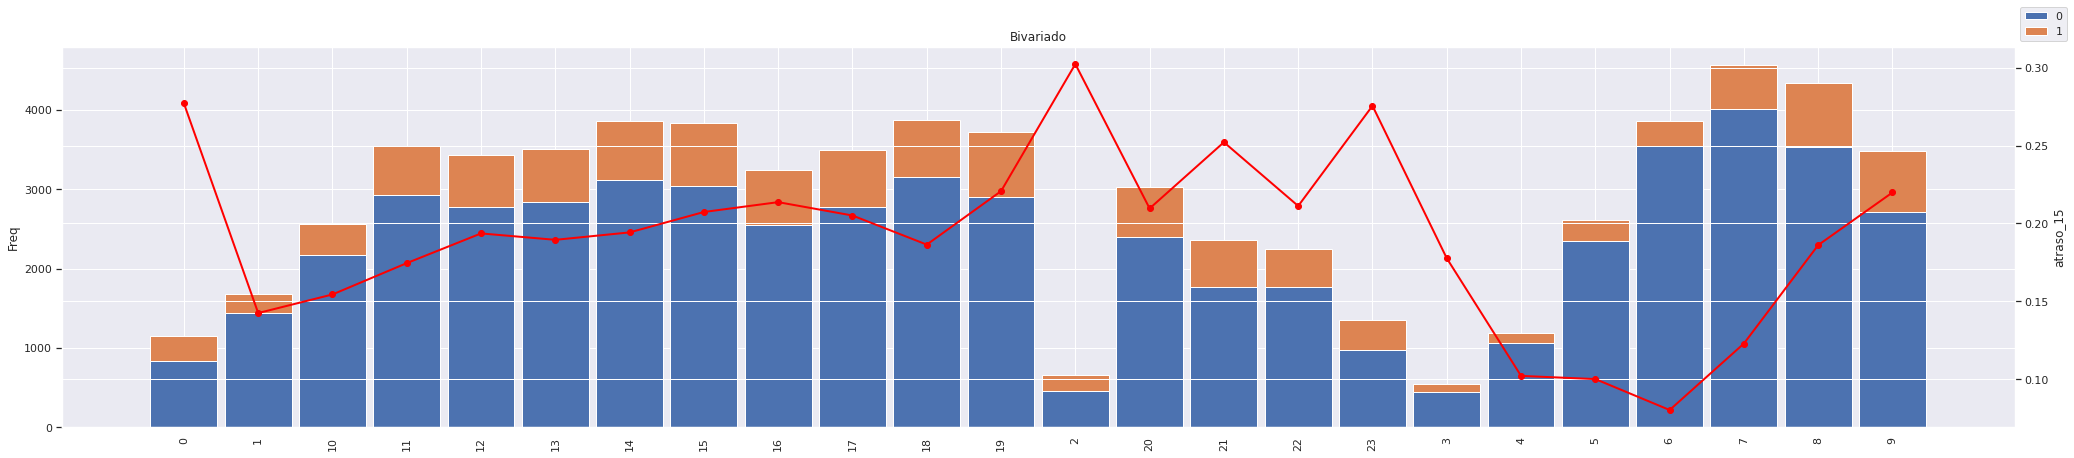

cambioNroVuelo


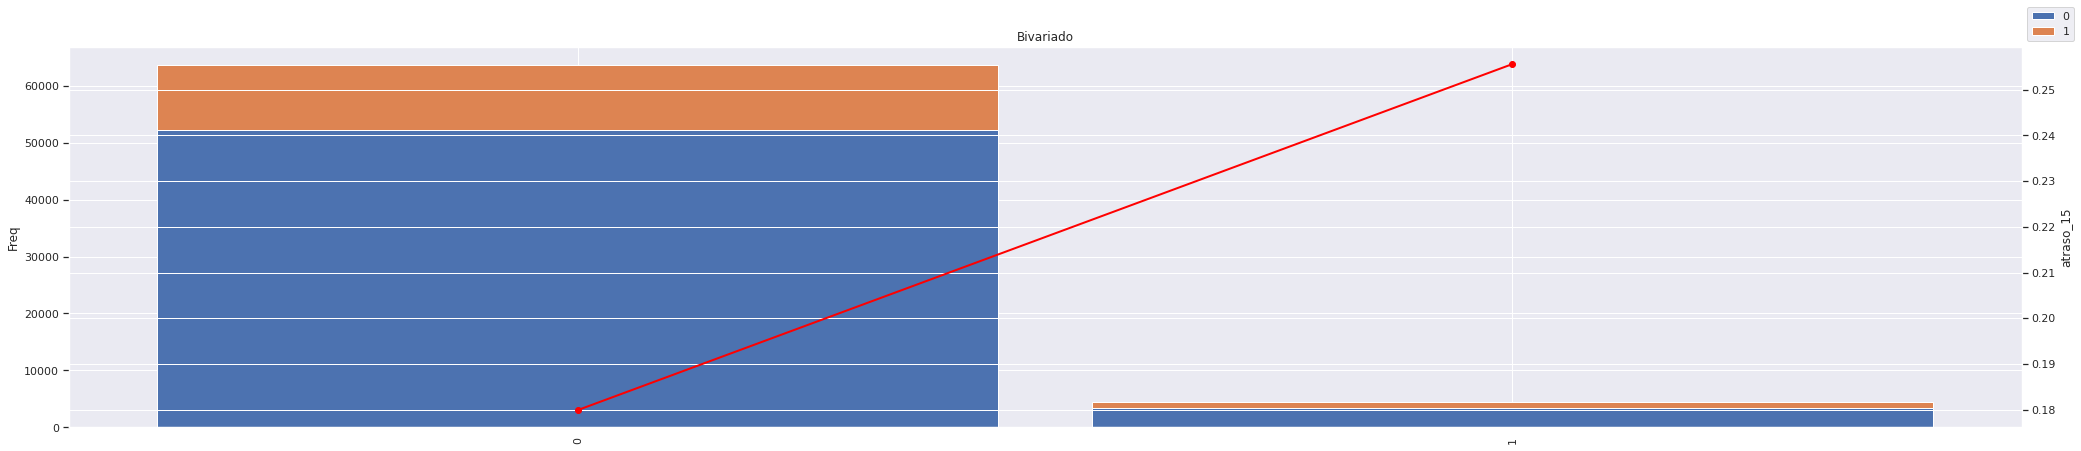

cambioCodAerolineaVuelo


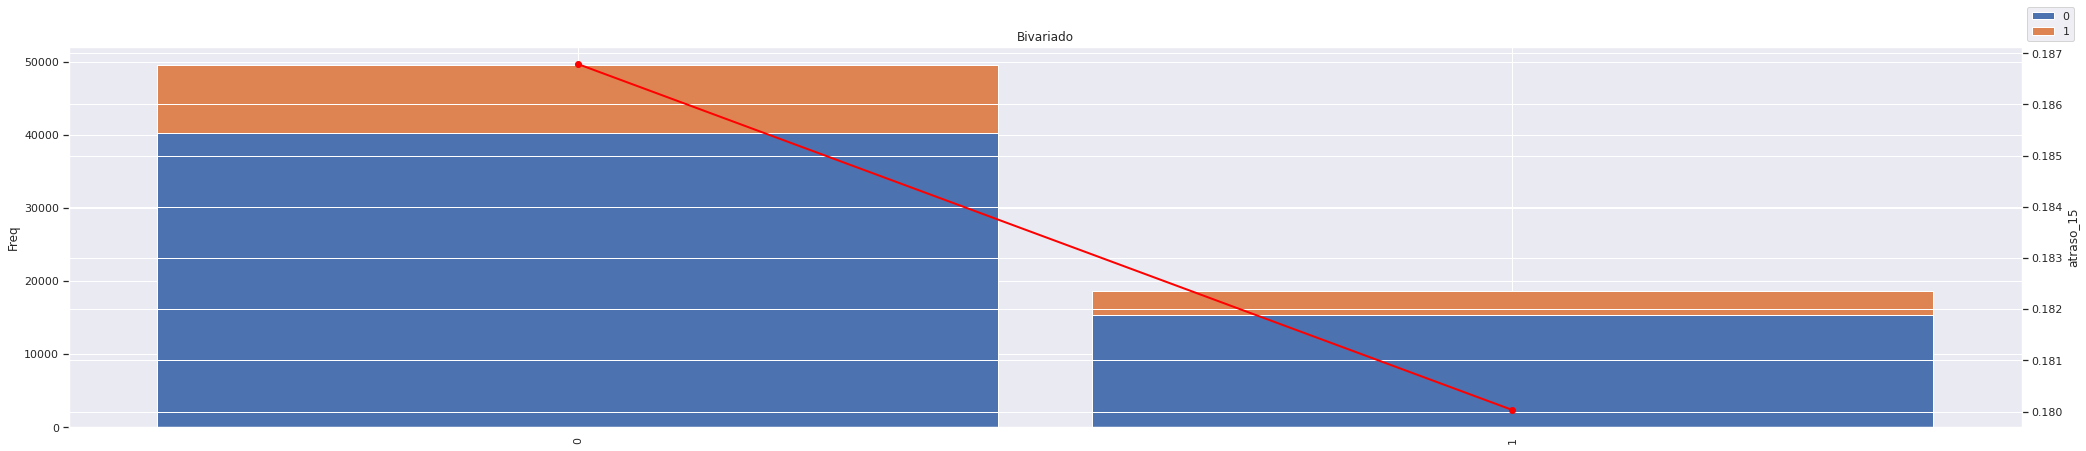

In [115]:
# Reporte para conocer la tasa de atraso
plot_graph_bivariable(df_analisis_bi, meta,'atraso_15')

Este análisis nos permite visualizar por tipo categoria de la variable cualitativa y decil de la variable cuantitativa la tasa de atraso (su participación con respecto al target). Este análisis nos ayudará:
- **Cuales son las categorías de las variables que más influyeran en predecir atrasos**
- Conocer saber como podemos agrupar las variables, así como la representatividad con respecto al target de importancia.

Algunas insights obtenidos del análisis de la tasa de atraso:

- A pesar de tener menor proporción la categoria **Internacional** tiene un nivel alto de conversión, para predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).
- La proporción de viajes en cuanto al **dia de semana** no tiene mucha diferencia, son proporciones muy equitativas. Sin embargo su tasa de atraso es mayor los **Lunes, Jueves y Viernes** que los **Martes, Miercoles, Sabado y Domingo**
- Se observa que la mayoria de las personas prefiere viajar por la **mañana** y la **tarde**. Siendo la de menor preferencia por la **noche**, sin embargo la esta categoria tiene un mayor ratio de conversión con respecto al target, **es decir tiene una mayor tasa de retraso**

# Preparación de los datos

In [116]:
df_prep= df_analisis.copy()

In [117]:
feat_numerical_ = ['dif_min']

feat_categorical_ = [
 'codCiudadDestProg',
 'codAerolineaVuelProg',
 'codCiudadDestOperado',
 'codAerolineaVuelOperado',
 'diaSemVuelOperado',
 'mesVuelOperado',
 'tipVuelo',
 'nombAerolineaOperado',
 'nombCiudadDest',
 'temporada_alta',
 'periodo_dia',
 'horaOperVuelo',
 'cambioNroVuelo',
 'cambioCodAerolineaVuelo',
 'condMeteorologica']

In [118]:
# Conversion del tipo de dato
df_prep['atraso_15']=df_prep['atraso_15'].astype('int64')

for var in feat_categorical_:
  df_prep[var] = df_prep[var].astype('category')

### Variables cualitativas de alta cardinalidad


Se busca que al moverme de una categoría a otra el porcentaje del target que me interesa **(atraso_15==1)** cambie favorablemente para diferenciar una clase de otra. En ese sentido este tipo de variables de alta cardinalidad se agrupan según:
- **Ratio del total de vuelos**
- **Tasa de Atraso (conversión con respecto al target)**

Se utiliza la función **cross_target** que calcula los porcentajes de conversión del target por cada categoria de la variable (También se denomina tasa de atraso)

#### Nombre de la ciudad Destino

In [119]:
cross_target(df_prep,'nombCiudadDest','atraso_15')

----------------------------------------------------------------
---- Var:  nombCiudadDest
            Atributo  Cantidad    %Total
0       Buenos Aires      6335  9.288039
1        Antofagasta      5786  8.483125
2               Lima      5270  7.726593
3             Calama      5146  7.544791
4       Puerto Montt      4357  6.388001
5         Concepcion      3993  5.854324
6            Iquique      3747  5.493652
7          Sao Paulo      3569  5.232677
8             Temuco      2589  3.795854
9              Arica      2436  3.571533
10         La Serena      2410  3.533413
11      Punta Arenas      2105  3.086239
12  Ciudad de Panama      1850  2.712371
13           Copiapo      1780  2.609741
14           Mendoza      1625  2.382488
15            Bogota      1604  2.351699
16    Rio de Janeiro      1435  2.103920
17        Montevideo      1066  1.562912
18           Cordoba      1023  1.499868
19             Miami      1016  1.489605
20            Madrid       894  1.310735
21     

Se decide agrupar las categorías según su **ratio del total de vuelos**. Se construye la categoría **OTRO** tomando las categorías que tengan una **participación menor del 1%**

In [120]:
def fx_nombCiudadDest(x):
    if x in ['Buenos Aires','Antofagasta','Lima','Calama','Puerto Montt','Concepcion','Iquique','Sao Paulo','Temuco','Arica','La Serena','Punta Arenas','Ciudad de Panama',
             'Copiapo','Mendoza','Bogota','Rio de Janeiro','Montevideo','Cordoba','Miami','Madrid','Balmaceda','Valdivia','Ciudad de Mexico']:
        return x
    else:
        return 'OTRO'

df_prep['nombCiudadDest'] = df_prep['nombCiudadDest'].apply(lambda x: fx_nombCiudadDest(x))

In [121]:
cross_target(df_prep,'nombCiudadDest','atraso_15')

----------------------------------------------------------------
---- Var:  nombCiudadDest
            Atributo  Cantidad    %Total
0       Buenos Aires      6335  9.288039
1               OTRO      5878  8.618010
2        Antofagasta      5786  8.483125
3               Lima      5270  7.726593
4             Calama      5146  7.544791
5       Puerto Montt      4357  6.388001
6         Concepcion      3993  5.854324
7            Iquique      3747  5.493652
8          Sao Paulo      3569  5.232677
9             Temuco      2589  3.795854
10             Arica      2436  3.571533
11         La Serena      2410  3.533413
12      Punta Arenas      2105  3.086239
13  Ciudad de Panama      1850  2.712371
14           Copiapo      1780  2.609741
15           Mendoza      1625  2.382488
16            Bogota      1604  2.351699
17    Rio de Janeiro      1435  2.103920
18        Montevideo      1066  1.562912
19           Cordoba      1023  1.499868
20             Miami      1016  1.489605
21     

Se aprecia que **Buenos Aires** y **Lima**, dos destinos internacionales, tienen un alto porcentaje de valores así con un alto valor de conversión.

Por otro lado debido a que esta variable se convertirá en una variable del tipo dummy para evitar problemas con el nombre se realiza la siguiente transformación:

In [122]:
df_prep.loc[df_prep['nombCiudadDest']=='Buenos Aires',['nombCiudadDest']]='Buenos_Aires'
df_prep.loc[df_prep['nombCiudadDest']=='Puerto Montt',['nombCiudadDest']]='Puerto_Montt'
df_prep.loc[df_prep['nombCiudadDest']=='Sao Paulo',['nombCiudadDest']]='Sao_Paulo'
df_prep.loc[df_prep['nombCiudadDest']=='La Serena',['nombCiudadDest']]='La_Serena'
df_prep.loc[df_prep['nombCiudadDest']=='Sao Paulo',['nombCiudadDest']]='Sao_Paulo'
df_prep.loc[df_prep['nombCiudadDest']=='Punta Arenas',['nombCiudadDest']]='Punta_Arenas'
df_prep.loc[df_prep['nombCiudadDest']=='Ciudad de Panama',['nombCiudadDest']]='Ciudad_de_Panama'
df_prep.loc[df_prep['nombCiudadDest']=='Rio de Janeiro',['nombCiudadDest']]='Rio_de_Janeiro'
df_prep.loc[df_prep['nombCiudadDest']=='Ciudad de Mexico',['nombCiudadDest']]='Ciudad_de_Mexico'

In [123]:
cross_target(df_prep,'nombCiudadDest','atraso_15')

----------------------------------------------------------------
---- Var:  nombCiudadDest
            Atributo  Cantidad    %Total
0       Buenos_Aires      6335  9.288039
1               OTRO      5878  8.618010
2        Antofagasta      5786  8.483125
3               Lima      5270  7.726593
4             Calama      5146  7.544791
5       Puerto_Montt      4357  6.388001
6         Concepcion      3993  5.854324
7            Iquique      3747  5.493652
8          Sao_Paulo      3569  5.232677
9             Temuco      2589  3.795854
10             Arica      2436  3.571533
11         La_Serena      2410  3.533413
12      Punta_Arenas      2105  3.086239
13  Ciudad_de_Panama      1850  2.712371
14           Copiapo      1780  2.609741
15           Mendoza      1625  2.382488
16            Bogota      1604  2.351699
17    Rio_de_Janeiro      1435  2.103920
18        Montevideo      1066  1.562912
19           Cordoba      1023  1.499868
20             Miami      1016  1.489605
21     

#### Codigo de la ciudad del destino programado

In [124]:
cross_target(df_prep,'codCiudadDestProg','atraso_15')

----------------------------------------------------------------
---- Var:  codCiudadDestProg
   Atributo  Cantidad    %Total
0      SCFA      5787  8.484591
1      SPJC      5270  7.726593
2      SCCF      5145  7.543325
3      SCTE      4357  6.388001
4      SCIE      3995  5.857256
5      SCDA      3747  5.493652
6      SBGR      3570  5.234144
7      SAEZ      3240  4.750315
8      SABE      3094  4.536258
9      SCQP      2583  3.787057
10     SCAR      2436  3.571533
11     SCSE      2410  3.533413
12     SCCI      2105  3.086239
13     MPTO      1850  2.712371
14     SCAT      1780  2.609741
15     SAME      1625  2.382488
16     SKBO      1604  2.351699
17     SBGL      1434  2.102454
18     SUMU      1066  1.562912
19     SACO      1023  1.499868
20     KMIA      1015  1.488139
21     LEMD       894  1.310735
22     SCBA       843  1.235962
23     SCVD       753  1.104008
24     MMMX       700  1.026303
25     SCIP       452  0.662698
26     SEGU       423  0.620180
27     KJF

Se decide agrupar las categorías según su **ratio del total de vuelos**. Se construye la categoría **OTRO** tomando las categorías que tengan una **participación menor del 1%**

In [125]:
def fx_codCiudadDestProg(x):
    if x in ['SCFA','SPJC','SCCF','SCTE','SCIE','SCDA','SBGR','SAEZ','SABE','SCQP','SCAR','SCSE',
             'SCCI','MPTO','SCAT','SAME','SKBO','SBGL','SUMU','SACO','KMIA','LEMD','SCBA','SCVD']:
        return x
    else:
        return 'OTRO'

df_prep['codCiudadDestProg'] = df_prep['codCiudadDestProg'].apply(lambda x: fx_codCiudadDestProg(x))

In [126]:
cross_target(df_prep,'codCiudadDestProg','atraso_15')

----------------------------------------------------------------
---- Var:  codCiudadDestProg
   Atributo  Cantidad    %Total
0      OTRO      6580  9.647245
1      SCFA      5787  8.484591
2      SPJC      5270  7.726593
3      SCCF      5145  7.543325
4      SCTE      4357  6.388001
5      SCIE      3995  5.857256
6      SCDA      3747  5.493652
7      SBGR      3570  5.234144
8      SAEZ      3240  4.750315
9      SABE      3094  4.536258
10     SCQP      2583  3.787057
11     SCAR      2436  3.571533
12     SCSE      2410  3.533413
13     SCCI      2105  3.086239
14     MPTO      1850  2.712371
15     SCAT      1780  2.609741
16     SAME      1625  2.382488
17     SKBO      1604  2.351699
18     SBGL      1434  2.102454
19     SUMU      1066  1.562912
20     SACO      1023  1.499868
21     KMIA      1015  1.488139
22     LEMD       894  1.310735
23     SCBA       843  1.235962
24     SCVD       753  1.104008

   codCiudadDestProg % ratio_conv
5               SACO    30.107527
8    

#### Codigo de la ciudad destino operado

In [127]:
cross_target(df_prep,'codCiudadDestOperado','atraso_15')

----------------------------------------------------------------
---- Var:  codCiudadDestOperado
   Atributo  Cantidad    %Total
0      SCFA      5786  8.483125
1      SPJC      5270  7.726593
2      SCCF      5146  7.544791
3      SCTE      4357  6.388001
4      SCIE      3993  5.854324
5      SCDA      3747  5.493652
6      SBGR      3569  5.232677
7      SAEZ      3241  4.751781
8      SABE      3094  4.536258
9      SCQP      2589  3.795854
10     SCAR      2436  3.571533
11     SCSE      2410  3.533413
12     SCCI      2105  3.086239
13     MPTO      1850  2.712371
14     SCAT      1780  2.609741
15     SAME      1625  2.382488
16     SKBO      1604  2.351699
17     SBGL      1435  2.103920
18     SUMU      1066  1.562912
19     SACO      1023  1.499868
20     KMIA      1016  1.489605
21     LEMD       894  1.310735
22     SCBA       839  1.230097
23     SCVD       753  1.104008
24     MMMX       700  1.026303
25     SCIP       452  0.662698
26     SEGU       422  0.618714
27     

Se decide agrupar las categorías según su **ratio del total de vuelos**. Se construye la categoría **OTRO** tomando las categorías que tengan una **participación menor del 1%**

In [128]:
def fx_codCiudadDestOper(x):
    if x in ['SCFA','SPJC','SCCF','SCTE','SCIE','SCDA','SBGR','SAEZ','SABE','SCQP','SCAR','SCSE',
             'SCCI','MPTO','SCAT','SAME','SKBO','SBGL','SUMU','SACO','KMIA','LEMD','SCBA','SCVD']:
        return x
    else:
        return 'OTRO'

df_prep['codCiudadDestOperado'] = df_prep['codCiudadDestOperado'].apply(lambda x: fx_codCiudadDestOper(x))

In [129]:
cross_target(df_prep,'codCiudadDestOperado','atraso_15')

----------------------------------------------------------------
---- Var:  codCiudadDestOperado
   Atributo  Cantidad    %Total
0      OTRO      6578  9.644313
1      SCFA      5786  8.483125
2      SPJC      5270  7.726593
3      SCCF      5146  7.544791
4      SCTE      4357  6.388001
5      SCIE      3993  5.854324
6      SCDA      3747  5.493652
7      SBGR      3569  5.232677
8      SAEZ      3241  4.751781
9      SABE      3094  4.536258
10     SCQP      2589  3.795854
11     SCAR      2436  3.571533
12     SCSE      2410  3.533413
13     SCCI      2105  3.086239
14     MPTO      1850  2.712371
15     SCAT      1780  2.609741
16     SAME      1625  2.382488
17     SKBO      1604  2.351699
18     SBGL      1435  2.103920
19     SUMU      1066  1.562912
20     SACO      1023  1.499868
21     KMIA      1016  1.489605
22     LEMD       894  1.310735
23     SCBA       839  1.230097
24     SCVD       753  1.104008

   codCiudadDestOperado % ratio_conv
5                  SACO    30.107

Al aplicar este tipo de tratamiento podemos observar que esta variable se comporta de la misma manera que la variable **codCiudadDestProg** en ese sentido eliminaremos una de ellas

In [130]:
df_prep.drop(['codCiudadDestProg'],axis=1,inplace=True)

#### Nombre de la aerolinea que opera

In [131]:
cross_target(df_prep,'nombAerolineaOperado','atraso_15')

----------------------------------------------------------------
---- Var:  nombAerolineaOperado
                    Atributo  Cantidad     %Total
0                Grupo LATAM     40892  59.953670
1                Sky Airline     14298  20.962965
2      Aerolineas Argentinas      1949   2.857520
3                   Copa Air      1850   2.712371
4       Latin American Wings      1674   2.454330
5                    Avianca      1152   1.689001
6               JetSmart SPA      1095   1.605431
7                  Gol Trans       806   1.181714
8          American Airlines       757   1.109873
9                 Air Canada       565   0.828373
10                    Iberia       362   0.530745
11                 Delta Air       358   0.524881
12                Air France       358   0.524881
13                Aeromexico       351   0.514617
14           United Airlines       335   0.491159
15    Oceanair Linhas Aereas       279   0.409055
16                  Alitalia       259   0.379732
17 

Se decide no agrupar las categorías ya que mantiene una buena proporción en el número de vuelos y tasa de atraso

In [132]:
#def fx_aerolineaOpera(x):
#    if x in ['Grupo LATAM','Sky Airline']:
#        return x
#    else:
#        return 'OTRO'

#df_prep['nombAerolineaOperado'] = df_prep['nombAerolineaOperado'].apply(lambda x: fx_aerolineaOpera(x))

Se cambia el nombre de cada categoría por un nombre que no contenga espacios para un mejor tratamiento

In [133]:
df_prep['nombAerolineaOperado'] = df_prep['nombAerolineaOperado'].astype('object')

In [134]:
df_prep.loc[df_prep['nombAerolineaOperado']=='Grupo LATAM',['nombAerolineaOperado']]='Grupo_LATAM'
df_prep.loc[df_prep['nombAerolineaOperado']=='Sky Airline',['nombAerolineaOperado']]='Sky_Airline'
df_prep.loc[df_prep['nombAerolineaOperado']=='Aerolineas Argentinas',['nombAerolineaOperado']]='Aerolineas_Argentinas'
df_prep.loc[df_prep['nombAerolineaOperado']=='Copa Air',['nombAerolineaOperado']]='Copa_Air'
df_prep.loc[df_prep['nombAerolineaOperado']=='Latin American Wings',['nombAerolineaOperado']]='Latin_American_Wings'
df_prep.loc[df_prep['nombAerolineaOperado']=='JetSmart SPA',['nombAerolineaOperado']]='JetSmart_SPA'
df_prep.loc[df_prep['nombAerolineaOperado']=='Gol Trans',['nombAerolineaOperado']]='Gol_Trans'
df_prep.loc[df_prep['nombAerolineaOperado']=='American Airlines',['nombAerolineaOperado']]='American_Airlines'
df_prep.loc[df_prep['nombAerolineaOperado']=='Air Canada',['nombAerolineaOperado']]='Air_Canada'
df_prep.loc[df_prep['nombAerolineaOperado']=='Delta Air',['nombAerolineaOperado']]='Delta_Air'
df_prep.loc[df_prep['nombAerolineaOperado']=='Air France',['nombAerolineaOperado']]='Air_France'
df_prep.loc[df_prep['nombAerolineaOperado']=='United Airlines',['nombAerolineaOperado']]='United_Airlines'
df_prep.loc[df_prep['nombAerolineaOperado']=='Oceanair Linhas Aereas',['nombAerolineaOperado']]='Oceanair_Linhas_Aereas'
df_prep.loc[df_prep['nombAerolineaOperado']=='K.L.M.',['nombAerolineaOperado']]='K_L_M'
df_prep.loc[df_prep['nombAerolineaOperado']=='British Airways',['nombAerolineaOperado']]='British_Airways'
df_prep.loc[df_prep['nombAerolineaOperado']=='Qantas Airways',['nombAerolineaOperado']]='Qantas_Airways'
df_prep.loc[df_prep['nombAerolineaOperado']=='Plus Ultra Lineas Aereas',['nombAerolineaOperado']]='Plus_Ultra_Lineas_Aereas'

In [135]:
cross_target(df_prep,'nombAerolineaOperado','atraso_15')

----------------------------------------------------------------
---- Var:  nombAerolineaOperado
                    Atributo  Cantidad     %Total
0                Grupo_LATAM     40892  59.953670
1                Sky_Airline     14298  20.962965
2      Aerolineas_Argentinas      1949   2.857520
3                   Copa_Air      1850   2.712371
4       Latin_American_Wings      1674   2.454330
5                    Avianca      1152   1.689001
6               JetSmart_SPA      1095   1.605431
7                  Gol_Trans       806   1.181714
8          American_Airlines       757   1.109873
9                 Air_Canada       565   0.828373
10                    Iberia       362   0.530745
11                 Delta_Air       358   0.524881
12                Air_France       358   0.524881
13                Aeromexico       351   0.514617
14           United_Airlines       335   0.491159
15    Oceanair_Linhas_Aereas       279   0.409055
16                  Alitalia       259   0.379732
17 

- Se observa que la categoria **Grupo LATAM** tiene un **59.9%** del total de vuelos y un **17.86%** de conversión con respecto al target.
- Se observa que la categoria **Sky Airline** tiene un **20.9%** de total de vuelos y **17.7%** de conversión con respecto al target.



#### Codigo de la aerolínea del vuelo Operado

In [136]:
cross_target(df_prep,'codAerolineaVuelOperado','atraso_15')

----------------------------------------------------------------
---- Var:  codAerolineaVuelOperado
   Atributo  Cantidad     %Total
0       LAN     20988  30.771486
1       LXP     14558  21.344163
2       SKU     14298  20.962965
3       TAM      3046   4.465883
4       ARG      1946   2.853121
5       CMP      1850   2.712371
6       JMR      1647   2.414744
7       LPE      1214   1.779902
8       JAT      1095   1.605431
9       AVA       885   1.297540
10      GLO       806   1.181714
11      AAL       757   1.109873
12      ACA       565   0.828373
13      DSM       493   0.722810
14      LNE       374   0.548339
15      IBE       362   0.530745
16      DAL       358   0.524881
17      AFR       358   0.524881
18      LRC       357   0.523414
19      AMX       351   0.514617
20      UAL       335   0.491159
21      ONE       279   0.409055
22      AZA       259   0.379732
23      KLM       251   0.368003
24      LAP       219   0.321086
25      BAW       205   0.300560
26      Q

Se decide agrupar las categorías según su **ratio del total de vuelos**. Se construye la categoría **OTRO** conformada por todos los codigo de aerolinea de vuelo programada que no son **LAN, LXP, SKU, TAM**. Se decide dejar la categoria TAM porque su tasa de atraso es alta.

In [137]:
def fx_codAeroVueloOper(x):
    if x in ['LAN','LXP','SKU','TAM']:
        return x
    else:
        return 'OTRO'

df_prep['codAerolineaVuelOperado'] = df_prep['codAerolineaVuelOperado'].apply(lambda x: fx_codAeroVueloOper(x))

In [138]:
cross_target(df_prep,'codAerolineaVuelOperado','atraso_15')

----------------------------------------------------------------
---- Var:  codAerolineaVuelOperado
  Atributo  Cantidad     %Total
0      LAN     20988  30.771486
1     OTRO     15316  22.455502
2      LXP     14558  21.344163
3      SKU     14298  20.962965
4      TAM      3046   4.465883

  codAerolineaVuelOperado % ratio_conv
4                     TAM    25.574524
2                    OTRO    21.879081
0                     LAN    18.467696
3                     SKU    17.764722
1                     LXP    14.205248


- Se observa que la categoria **LAN** tiene un **30%** del total de vuelos y un **18.4%** de conversión con respecto al target.
- Se observa que la categoria **SKU** tiene un **21%** de total de vuelos y **17.7%** de conversión con respecto al target.
- Se observa que la categoria **LXP** tiene un **21%** de total de vuelos y **14.2%** de conversión con respecto al target.
- Se observa que la categoria **TAM** tiene un **4.4%** del total de vuelos y un **25.7%** de conversión con respecto al target. Se aprecia que a pesar de tener una poca cantidad de registros, tiene un alto nivel de conversión con respecto al target, esto ayudará a diferenciar una clase de otra
- La categoria **OTRO** al ser agrupada paso a tener un alto ratio de conversión, esto es mejor que tener una alta variabilidad con el resto de categorias

Por otro lado se puede observar que el codigo de la aerolinea de programación y operación son diferentes una de otra es por eso que se creó la variable **cambioCodAerolineaVuelo** con el objetivo de medir esta variabilidad.

#### Codigo de la aerolínea del vuelo Programado

In [139]:
cross_target(df_prep,'codAerolineaVuelProg','atraso_15')

----------------------------------------------------------------
---- Var:  codAerolineaVuelProg
   Atributo  Cantidad     %Total
0       LAN     37611  55.143243
1       SKU     14298  20.962965
2       TAM      3049   4.470281
3       ARG      1949   2.857520
4       CMP      1850   2.712371
5       LAW      1574   2.307715
6       AVA      1152   1.689001
7       JAT      1095   1.605431
8       GLO       806   1.181714
9       AAL       757   1.109873
10      ACA       565   0.828373
11      IBE       362   0.530745
12      AFR       358   0.524881
13      DAL       358   0.524881
14      AMX       351   0.514617
15      UAL       335   0.491159
16      ONE       279   0.409055
17      AZA       259   0.379732
18      KLM       251   0.368003
19      LAP       216   0.316688
20      BAW       205   0.300560
21      QFU       195   0.285899
22      JMR       100   0.146615
23      LRC        92   0.134885
24      AUT        74   0.108495
25      PUE        49   0.071841
26      LXP 

Se decide agrupar las categorías según su **ratio del total de vuelos**. Se construye la categoría **OTRO** conformada por todos los codigo de aerolinea de vuelo programada que no son **LAN, SKU, TAM**. Se decide dejar la categoria TAM porque su tasa de atraso es alta.

In [140]:
def fx_codAeroVueloProg(x):
    if x in ['LAN','SKU','TAM']:
        return x
    else:
        return 'OTRO'

df_prep['codAerolineaVuelProg'] = df_prep['codAerolineaVuelProg'].apply(lambda x: fx_codAeroVueloProg(x))

In [141]:
cross_target(df_prep,'codAerolineaVuelProg','atraso_15')

----------------------------------------------------------------
---- Var:  codAerolineaVuelProg
  Atributo  Cantidad     %Total
0      LAN     37611  55.143243
1      SKU     14298  20.962965
2     OTRO     13248  19.423511
3      TAM      3049   4.470281

  codAerolineaVuelProg % ratio_conv
3                  TAM    25.582158
1                 OTRO    21.444746
2                  SKU    17.764722
0                  LAN    17.157215


- Se observa que la categoria **LAN** tiene un **55%** del total de vuelos y un **17%** de conversión con respecto al target.
- Se observa que la categoria **SKU** tiene un **21%** de total de vuelos y **18%** de conversión con respecto al target.
- Se observa que la categoria **TAM** tiene un **4.4%** del total de vuelos y un **26%** de conversión con respecto al target. **Se aprecia que a pesar de tener una poca cantidad de registros, tiene un alto nivel de conversión con respecto al target, esto ayudará a diferenciar una clase de otra
- La categoria **OTRO** al ser agrupada paso a tener un alto ratio de conversión, esto es mejor que tener una alta variabilidad con el resto de categorias

### Variables constantes o de varianza nula

Acá se podría incluir las variables constante o de varianza nula como:
- **codCiudadOrigenProg**
- **codCiudadOrigenOperado**
- **nomCiudadOrigen**
- **anioVuelOperado**

Estas variables previamente ya han sido eliminados en la sección correspondiente, sin embargo podrían incluirse en este paso.

### Variables Binarias

Estos datos deben ser transformados en valores cuantitativas para que puedan ingresar al modelo

In [142]:
dicc_tipVuelo = {'N': 0,'I': 1}

df_prep['tipVuelo'] = df_prep['tipVuelo'].map(dicc_tipVuelo)
df_prep['tipVuelo'] = df_prep['tipVuelo'].astype('int64')

In [143]:
dicc_condMeteorologica = {'NO': 0,'SI': 1}

df_prep['condMeteorologica'] = df_prep['condMeteorologica'].map(dicc_condMeteorologica)
df_prep['condMeteorologica'] = df_prep['condMeteorologica'].astype('int64')

Transformacion de datos del tipo string a int64

In [144]:
df_prep['temporada_alta'] = df_prep['temporada_alta'].astype('int64')
df_prep['cambioNroVuelo'] = df_prep['cambioNroVuelo'].astype('int64')
df_prep['cambioCodAerolineaVuelo'] = df_prep['cambioCodAerolineaVuelo'].astype('int64')

### Variables según su naturaleza: Cualitativa ordinal

#### Dia de la semana

In [145]:
cross_target(df_prep,'diaSemVuelOperado','atraso_15')

----------------------------------------------------------------
---- Var:  diaSemVuelOperado
    Atributo  Cantidad     %Total
0    Viernes     10292  15.089582
1     Jueves     10251  15.029470
2      Lunes     10131  14.853532
3    Domingo      9796  14.362373
4  Miercoles      9722  14.253878
5     Martes      9662  14.165909
6     Sabado      8352  12.245257

  diaSemVuelOperado % ratio_conv
6           Viernes     22.20171
2             Lunes    20.215181
1            Jueves    19.949273
4         Miercoles    17.084962
3            Martes    16.911613
5            Sabado    16.319444
0           Domingo    16.108616


La proporción de viajes en cuanto al dia de semana no tiene mucha diferencia, son proporciones muy equitativas. Sin embargo su ratio de conversión es mayor los **Lunes, Jueves y Viernes** que los **Martes, Miercoles, Sabado y Domingo**

Por otro lado observamos que la variable es del tipo ordinal, conservamos su naturaleza.

In [146]:
dicc_diaSem = {'Lunes': 0,
               'Martes': 1,
               'Miercoles':2,
               'Jueves':3,
               'Viernes':4,
               'Sabado': 5, 
               'Domingo':6
               }

df_prep['diaSemVuelOperado'] = df_prep['diaSemVuelOperado'].map(dicc_diaSem)
df_prep['diaSemVuelOperado'] = df_prep['diaSemVuelOperado'].astype('int64')

#### Partes del dia (periodo_dia)

In [147]:
cross_target(df_prep,'periodo_dia','atraso_15')

----------------------------------------------------------------
---- Var:  periodo_dia
  Atributo  Cantidad     %Total
0    tarde     25506  37.395537
1   mañana     25352  37.169750
2    noche     17348  25.434712

  periodo_dia % ratio_conv
1       noche    20.002306
2       tarde    19.940406
0      mañana    16.006627


Se observa que la mayoria de las personas prefiere viajar por la **mañana** y la **tarde**. Siendo la de menor preferencia por la **noche**, sin embargo la esta categoria tiene un mayor ratio de conversión con respecto al target, **es decir tiene una mayor tasa de retraso**

In [148]:
dicc_periodo_dia = {'mañana': 0,
                    'tarde': 1,
                    'noche':2
                    }

df_prep['periodo_dia'] = df_prep['periodo_dia'].map(dicc_periodo_dia)
df_prep['periodo_dia'] = df_prep['periodo_dia'].astype('int64')

### Transformacion de Variables Categoricas Nominales a Dummies

In [149]:
df_prep.describe(include=['object','category'])

codAerolineaVuelProg codCiudadDestOperado codAerolineaVuelOperado  \
count                 68206                68206                   68206   
unique                    4                   25                       5   
top                     LAN                 OTRO                     LAN   
freq                  37611                 6578                   20988   

        mesVuelOperado nombAerolineaOperado nombCiudadDest horaOperVuelo  
count            68206                68206          68206         68206  
unique              12                   23             25            24  
top                 12          Grupo_LATAM   Buenos_Aires             7  
freq              6356                40892           6335          4570

In [150]:
vars_str = df_prep.select_dtypes(include=['object','category']).columns.tolist()
for var in vars_str:
  print("N de",var,":",df_prep[var].nunique())

N de codAerolineaVuelProg : 4
N de codCiudadDestOperado : 25
N de codAerolineaVuelOperado : 5
N de mesVuelOperado : 12
N de nombAerolineaOperado : 23
N de nombCiudadDest : 25
N de horaOperVuelo : 24


In [151]:
vars_to_dummies = [
#    'codAerolineaVuelProg',
    'codAerolineaVuelOperado',
    'nombAerolineaOperado'
#    ,'codCiudadDestOperado'
    ,'nombCiudadDest'
    ,'mesVuelOperado'
    ,'horaOperVuelo'
                   ]

In [152]:
df_prep = pd.get_dummies(df_prep, columns = vars_to_dummies,drop_first=True)
df_prep.describe(include='all')

/home/laren.osorio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


fecVuelProg codAerolineaVuelProg       fecVuelOperado  \
count                 68206                68206                68206   
unique                53252                    4                62774   
top     2017-07-28 13:30:00                  LAN  2017-11-05 14:51:00   
freq                      6                37611                    5   
first   2017-01-01 00:15:00                  NaN  2017-01-01 00:04:00   
last    2017-12-31 23:55:00                  NaN  2018-01-01 00:12:00   
mean                    NaN                  NaN                  NaN   
std                     NaN                  NaN                  NaN   
min                     NaN                  NaN                  NaN   
25%                     NaN                  NaN                  NaN   
50%                     NaN                  NaN                  NaN   
75%                     NaN                  NaN                  NaN   
max                     NaN                  NaN                  NaN   

       codCiudadDestOperado  diaSemVuelOperado      tipVuelo       dif_min  \
count                 68206       68206.000000  68206.000000  68206.000000   
unique                   25                NaN           NaN           NaN   
top                    OTRO                NaN           NaN           NaN   
freq                   6578                NaN           NaN           NaN   
first                   NaN                NaN           NaN           NaN   
last                    NaN                NaN           NaN           NaN   
mean                    NaN           2.955209      0.458024      9.110855   
std                     NaN           1.994333      0.498239     19.313387   
min                     NaN           0.000000      0.000000    -14.000000   
25%                     NaN           1.000000      0.000000     -1.000000   
50%                     NaN           3.000000      0.000000      4.000000   
75%                     NaN           5.000000      1.000000     12.000000   
max                     NaN           6.000000      1.000000    161.000000   

           atraso_15  temporada_alta   periodo_dia  condMeteorologica  \
count   68206.000000    68206.000000  68206.000000       68206.000000   
unique           NaN             NaN           NaN                NaN   
top              NaN             NaN           NaN                NaN   
freq             NaN             NaN           NaN                NaN   
first            NaN             NaN           NaN                NaN   
last             NaN             NaN           NaN                NaN   
mean        0.184940        0.148887      0.882650           0.087852   
std         0.388252        0.355980      0.782485           0.283081   
min         0.000000        0.000000      0.000000           0.000000   
25%         0.000000        0.000000      0.000000           0.000000   
50%         0.000000        0.000000      1.000000           0.000000   
75%         0.000000        0.000000      2.000000           0.000000   
max         1.000000        1.000000      2.000000           1.000000   

        cambioNroVuelo  cambioCodAerolineaVuelo  codAerolineaVuelOperado_LXP  \
count     68206.000000             68206.000000                 68206.000000   
unique             NaN                      NaN                          NaN   
top                NaN                      NaN                          NaN   
freq               NaN                      NaN                          NaN   
first              NaN                      NaN                          NaN   
last               NaN                      NaN                          NaN   
mean          0.066255                 0.273715                     0.213442   
std           0.248729                 0.445868                     0.409740   
min           0.000000                 0.000000                     0.000000   
25%           0.000000                 0.000000                     0.000000 

Después de varias iteraciones se eliminan las siguientes variables ya que guardan una relación lineal con otras variables predictoras
- Se elimina la variable **codAerolineaVuelProg** y se quedan las variables **nombAerolineaOperado** y **codAerolineaVuelOperado**.
- Se elimina la variable **codCiudadDestOperado** y se queda la variable **nombCiudadDest**.

In [153]:
df_prep.drop('codAerolineaVuelProg', axis=1, inplace=True)
df_prep.drop('codCiudadDestOperado', axis=1, inplace=True)

In [154]:
df_prep.shape

(68206, 95)

# Analisis de Correlación

In [155]:
var_cor=list(df_prep.columns)
var_cor.remove('fecVuelProg')
var_cor.remove('fecVuelOperado')

Análisis de correlación con respecto al target

In [156]:
df_prep.corrwith(df_prep["atraso_15"]).sort_values()

horaOperVuelo_6                                 -0.066005
codAerolineaVuelOperado_LXP                     -0.057543
mesVuelOperado_3                                -0.053177
nombAerolineaOperado_Copa_Air                   -0.052570
nombCiudadDest_Ciudad_de_Panama                 -0.052570
mesVuelOperado_4                                -0.049662
nombCiudadDest_Calama                           -0.046140
horaOperVuelo_5                                 -0.043613
horaOperVuelo_7                                 -0.042770
nombAerolineaOperado_American_Airlines          -0.032081
nombAerolineaOperado_Aeromexico                 -0.028982
horaOperVuelo_4                                 -0.028326
mesVuelOperado_2                                -0.025592
nombCiudadDest_Arica                            -0.024523
nombAerolineaOperado_United_Airlines            -0.024283
nombCiudadDest_Ciudad_de_Mexico                 -0.023777
nombAerolineaOperado_Delta_Air                  -0.023626
nombCiudadDest

Vamos a retirar la variable **dif_min** porque el **target** se calcula a partir de esta variable

In [157]:
df_prep.drop('dif_min', axis=1, inplace=True)

Se calcula un gráfico de correlación entre todas las variables

In [158]:
def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(40, 40))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }
    )
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

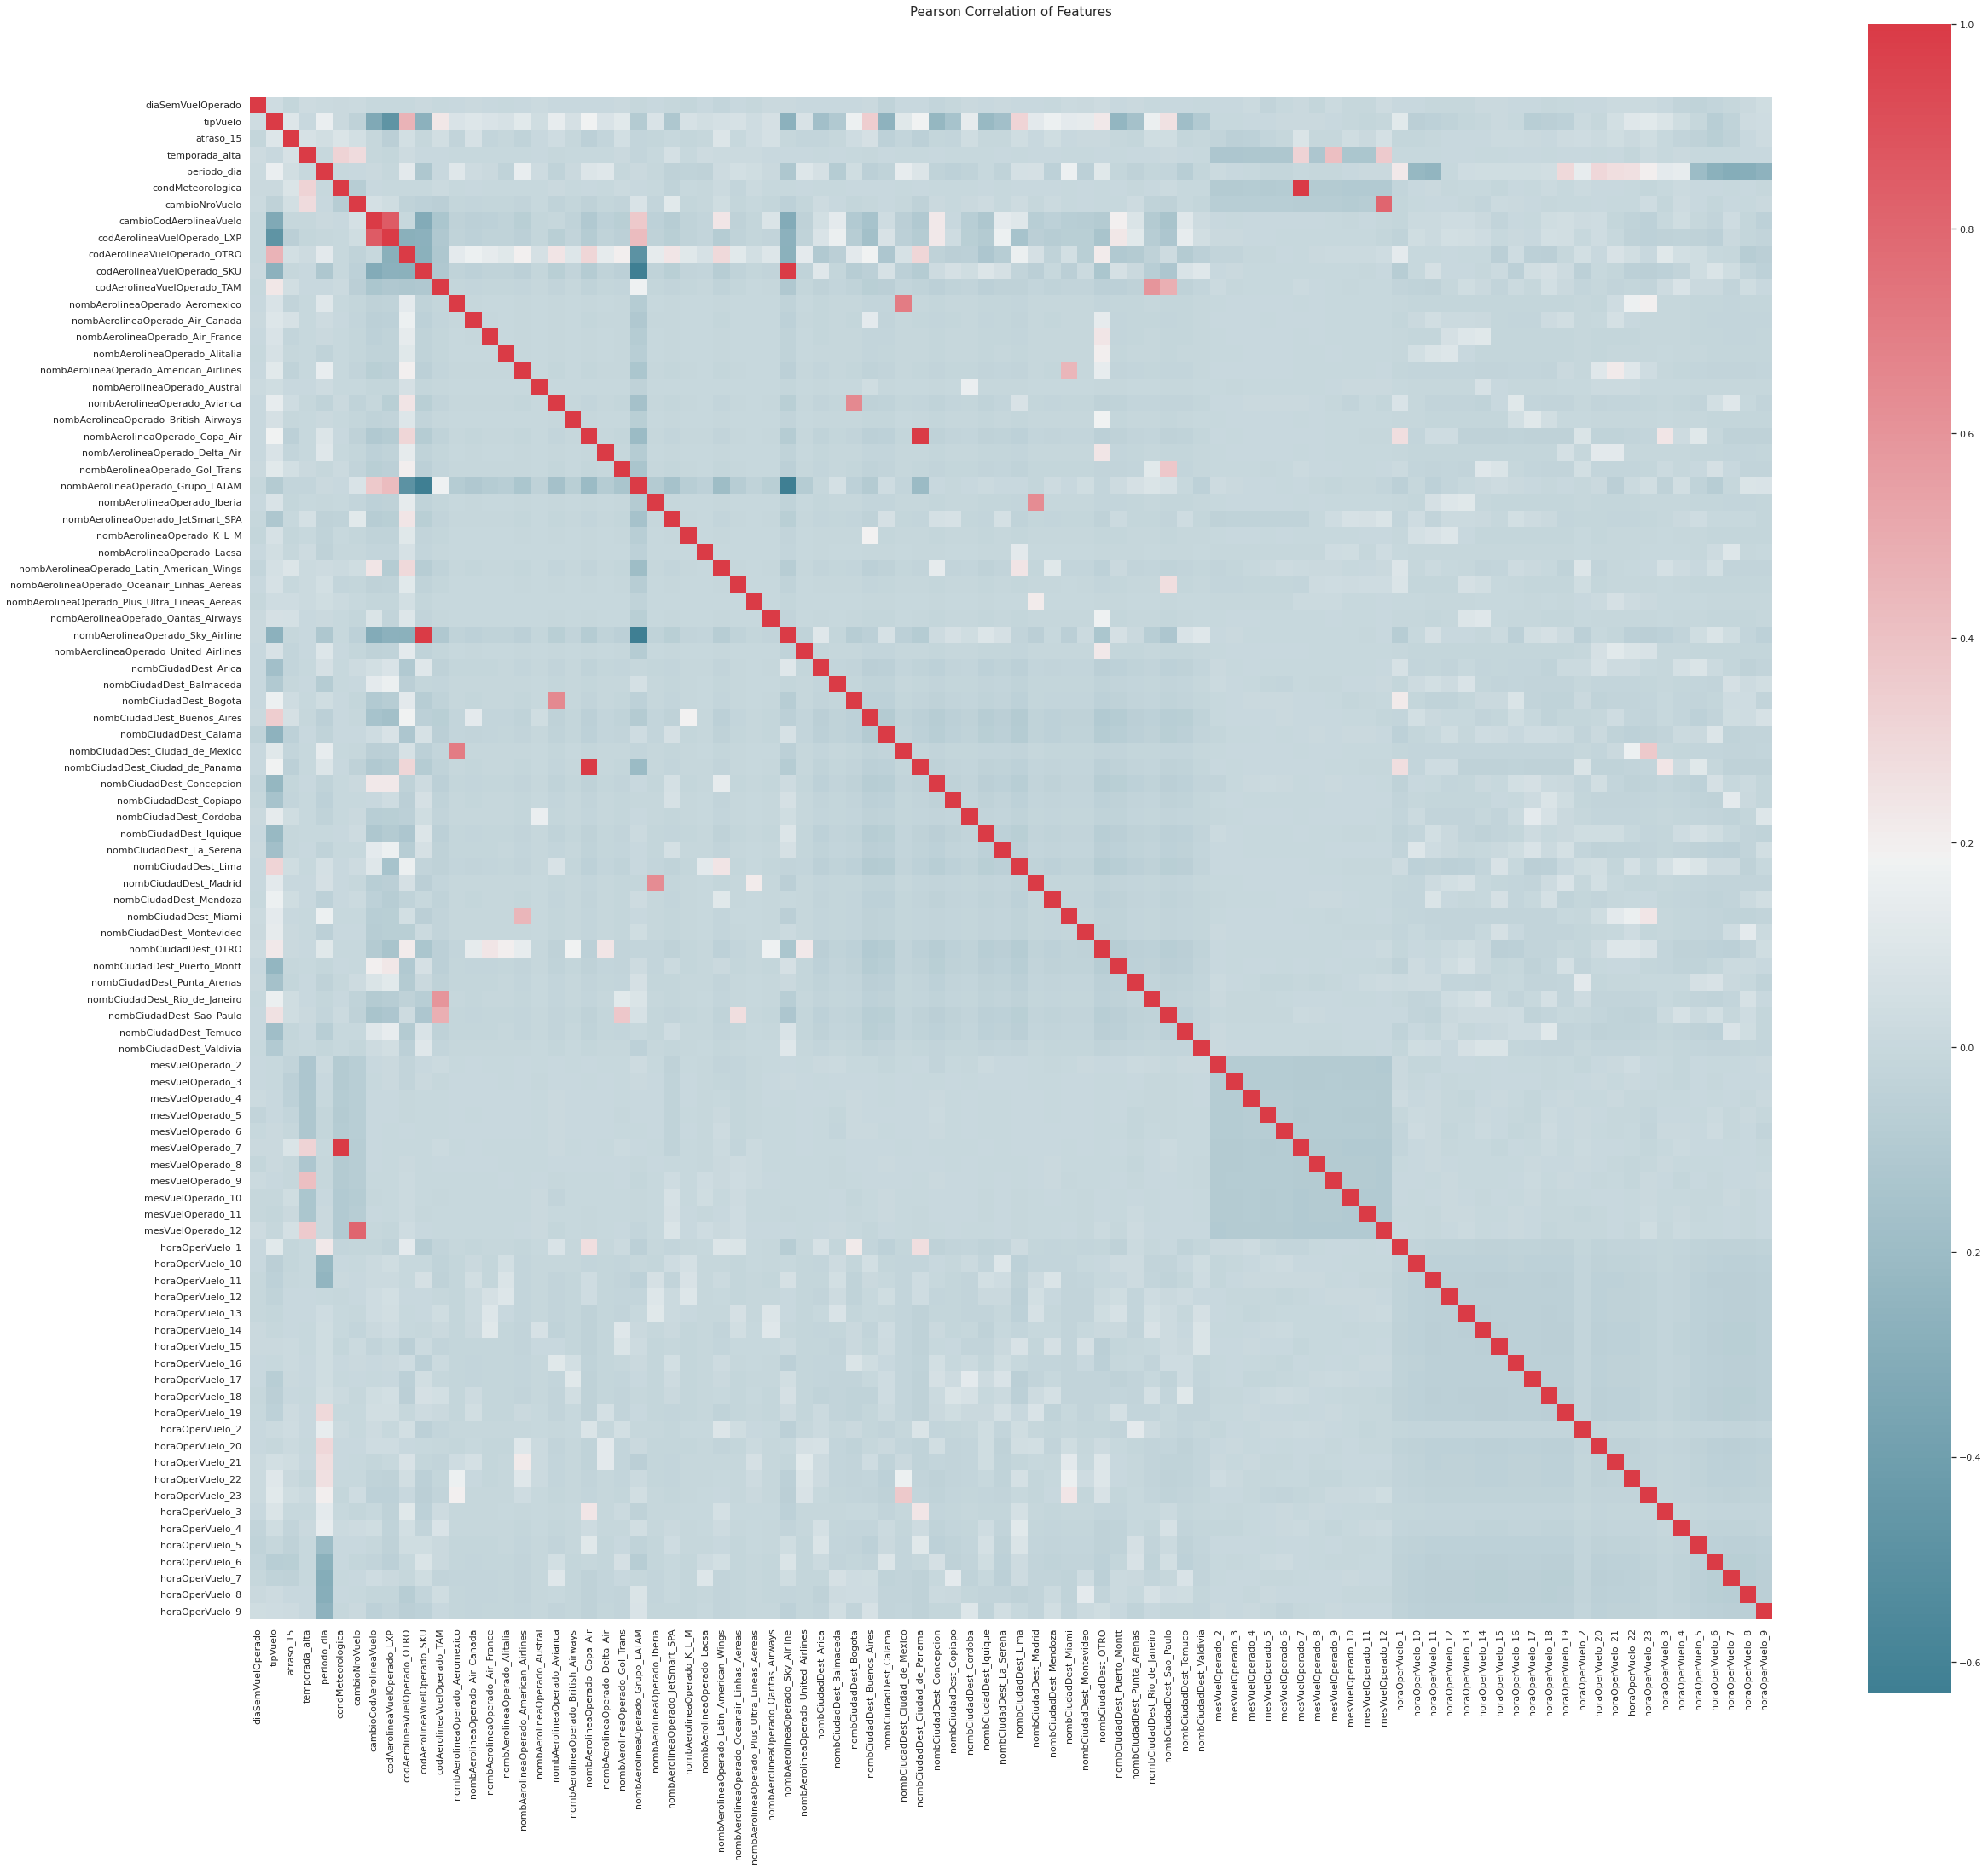

In [159]:
correlation_heatmap(df_prep)

Se retiran las variables que estan correlacionadas para no afectar la predictibilidad del modelo final. Se toman en cuenta una alta positiva correlación (color rojo intenso) y una alta negativa correlación (color verde intenso)

Estas variables serán retiradas automaticamente empleado pycaret con el parámetro **remove_multicollinearity=True** siendo el valor del **threshold de 0.8**

In [160]:
df_prep.drop('mesVuelOperado_7', axis=1, inplace=True)
df_prep.drop('nombCiudadDest_Ciudad_de_Panama', axis=1, inplace=True)
df_prep.drop('nombAerolineaOperado_Sky_Airline', axis=1, inplace=True)
#df_prep.drop('conMeteorologica', axis=1, inplace=True)
#df_prep.drop('mesVuelOperado_12', axis=1, inplace=True)
#df_prep.drop('codAerolineaVuelOperadp_LXP', axis=1, inplace=True)
#df_prep.drop('codAerolineaVuelOperado_SKU', axis=1, inplace=True)

# Modelado

## Definir la data de entrenamiento

Se realiza una copia del dataframe *df_prep*

In [161]:
df_model = df_prep.copy()

In [162]:
df_model.shape

(68206, 91)

Seleccionar las variables empleadas para el modelado

In [163]:
var_to_select=list(df_model.columns)
var_to_select.remove('fecVuelProg')
var_to_select.remove('fecVuelOperado')

In [164]:
df_model = df_model[var_to_select]

In [165]:
df_model.shape

(68206, 89)

Se emplea la librería **pycaret** que nos permite automatizar el proceso de aprendizaje y evaluación de diferentes algoritmos de clasificación. Para realizar esta tarea se define un experimento y una serie de valores de hiperparametros.

## Setear el experimento

Agrupar las variables por tipo de dato

In [166]:
feat_categorical_model=list(df_model.columns.values)
feat_categorical_model.remove('atraso_15')
#feat_numerical_model=['dif_min']

Definir los valores de los hiperparametros

In [167]:
from pycaret.classification import *

model_clf1 = setup(data=df_model,
                   target = 'atraso_15',
                   session_id=123,
                   train_size=0.75,#0.7
                   categorical_features=feat_categorical_model,
                   #numeric_features=feat_numerical_model,
                   remove_multicollinearity=True,
                   multicollinearity_threshold=0.8,
                   fold=10,
                   fold_shuffle=True,
                   fold_strategy='stratifiedkfold',
                   combine_rare_levels=True,
                   feature_selection=True,
                   fix_imbalance=True
                   )

## Comparar modelos

Una vez definido los valores de los hiperparametros del experimento se realiza el proceso de entrenamiento y evaluación empleando diferentes algoritmos de aprendizaje de máquina.

In [ ]:
compare_models()

IntProgress(value=0, description='Processing: ', max=79)

Initiated  . . . . . . . . . . . . . . . . . .                04:46:28
Status     . . . . . . . . . . . . . . . . . .        Fitting 10 Folds
Estimator  . . . . . . . . . . . . . . . . . .  K Neighbors Classifier

Según el desafio se debe entrenar uno o varios modelos (usando los algoritmos de preferencia) para estimar la probabilidad de atraso de un vuelo. En ese sentido se utilizó pycaret para probar diferentes algoritmos de aprendizaje automatico de clasificación.

Se toma en cuenta los siguientes algoritmos para un mejor entendimiento:

- El **accuracy** es alto para la mayoría de los modelos basados en árboles como **xgboost**, **lightgbm**, **extra tree**, **decision tree** y **random forest**, sin embargo se debe de tener en cuenta que esta métrica no solo esta siendo afectado por los **VP** sino también por los **VN**. En este problema se pretende predecir la probabilidad de atraso de un vuelo (VP).
- El modelo **xgboost** y **lightgbm** presentan altos valores de **Precisión**, sin embargo tienen un bajo valor de **Recall**
- El modelo **Regresión logística** presenta un menor valor de **Precisión** pero un mayor valor de **Recall**

**Esta comparación nos permite conocer que algoritmo se debe elegir basado en las métricas que el negocio necesita optimizar**. 

## Elegir el modelo *final*

Para elegir el modelo que será empleado para predecir los vuelos que presentan atraso se debe de tomar en cuenta algunos puntos relacionados con la interpretación del error en una matriz de confusión:

- Sabemos que los **Falsos Negativos** son los vuelos predecidos como **NO ATRASO** sin embargo realmente presentan **ATRASO**
- Sabemos que los **Falsos Positivos** son los vuelos predecidos como **ATRASO** sin embargo realmente presentan **NO ATRASO**

**Esto como impacta en el negocio** Analicemos lo siguientes casos:
- CASO 1: En el caso de predecir **NO ATRASO** pero sucede **ATRASO**, el impacto sobre el negocio sería **la insatisfacción del cliente** ya que tendría que esperar de acuerdo a lo programado, **lo que tendría consencuencias mayores relacionadas con reclamos y posibles pérdidas de dinero**.
- CASO 2: En el caso de predecir **ATRASO** pero sucede **NO ATRASO**, el impacto sobre el negocio sería posiblemente dada la alerta de **ATRASO** citarlos minutos antes, lo que demandaria en **posibles cancelaciones por parte del cliente ante el cambio de horario**.

**Considero que el CASO 1 tendría más impacto para el negocio**, es decir predecir **NO ATRASO** pero sucede **ATRASO**.

¿Qué se hará?

Como se puede ver en ambos casos, la **precision** y el **recall** están involucrados. En ese sentido se buscará un corte de probabilidad que permita optimizar ambos frentes, dandole un peso mayor al **recall** por el interés de  reducir los **Falsos Negativos**.

Tener en cuenta que será una opción interesante usar la curva ROC y el ROC AUC cuando tengamos un dataset más balanceado o **queramos poner de manifiesto un indicador más relacionado con falsas alarmas (falsos positivos)**

Se sugieren dos frentes:
- FRENTE 1: Elegir el modelo de **Regresion Logistica** ya que presenta un valor alto de **recall** con respecto al resto de modelos, así como un aceptable **roc-auc**. Aún así se puede buscar un corte optimo de probabilidad para tener un mejor trade-off entre precision y recall
- FRENTE 2: Seleccionar el algoritmo **xgboost** que presenta un valor alto de **Precision** con respecto al resto de modelos, un aceptable **roc-auc** y un bajo valor de **recall**; y encontrar un **probability_threshold** que permita mejorar el **recall** sin empeorar la **precision**

**Seleccionamos el FRENTE 2**

En pycaret por defecto, todos los clasificadores que son capaces de predecir probabilidades utilizan **0.5** como umbral de corte.

In [ ]:
xgboost = create_model('xgboost')

En ese sentido se entrena 10 modelos con un mismo algoritmo pero con diferente threshold

In [ ]:
recalls = []
precisions=[]

for i in np.arange(0,1,0.1):
   model = create_model('xgboost', probability_threshold = i, verbose=False)
   recalls.append(pull()['Recall']['Mean'])
   precisions.append(pull()['Prec.']['Mean'])

Se construye el dataframe que contiene los valores de **recall** y **precision** para los diferentes punto de corte

In [ ]:
df_threshold = pd.DataFrame()
df_threshold['threshold'], df_threshold['recall'], df_threshold['precision']=np.arange(0,1,0.1),recalls,precisions
df.set_index('threshold').plot(marker='o')
plt.show()

In [ ]:
df_threshold

A partir de este caso se selecciona un **probability_threshold** de valor **0.32**

In [ ]:
best=create_model('xgboost',probability_threshold=0.32)

Como se puede notar hemos logrado subir los valores del **recall de 0.26 (mean) a 0.5385 (mean)**, conservando un buen **auc**.

En el siguiente gráfico se tienen las curvas de precisión, recall así como el punto de corte óptimo encontrado previamente. Este gráfico nos permite validar el punto de corte óptimo.

In [ ]:
# Threshold
evaluate_model(best)

## Evaluar el modelo

In [ ]:
# Precision-recall
evaluate_model(best)

**PR-curve** La curva PR es el resultado de dibujar la gráfica entre el precision y el recall. Esta gráfica nos permite ver a partir de qué recall tenemos una degradación de la precisión y viceversa. Lo ideal sería una curva que se acerque lo máximo posible a la esquina superior derecha (alta precisión y alto recall).

Por lo general, se usa la curva PR o el Average Precision cuando tengamos problemas de datasets no balanceados, es decir, cuando la clase positiva ocurre pocas veces. En relación al Average Precision, nos interesa que su valor se acerque lo máximo posible a 1.

In [ ]:
#roc-auc
evaluate_model(best)

**ROC-AUC** Relaciona el recall con el ratio de falsos positivos. Es decir relaciona la sensibilidad del modelo con los fallos optimistas (clasificar los negativos como positivos). Tiene sentido ya que, generalmente, si aumentamos el recall, el modelo tenderá a ser más optimista e introducirá mas falsos positivos en la clasificación, esto generaría una disminución en la precisión. De manera similar al Average Precision, nos interesa que su valor se acerque lo máximo posible a 1

Para este caso el área bajo la curva (AUC) es 0.77

In [ ]:
# confusion Matrix
evaluate_model(best)

In [ ]:
# Boundary
plot_model(best, plot = 'boundary')

# Interpretabilidad del modelo

Para la interpretabilidad del modelo empleamos el criterio de importancia de cada variable por gini

In [ ]:
evaluate_model(best)

In [ ]:
plot_model(best, plot = 'feature')

Como se observa las variables que mejor explican la probabilidad de la tasa de atraso son las siguientes:
- nombre de la aerolínea Copa Air
- nombre de la ciudad destimo Calama
- hora de operacion de vuelo (6)
- mes de operacion de vuelo operados (3 y 10)

In [ ]:
interpret_model(best)

In [ ]:
interpret_model(best, plot = 'correlation')

In [ ]:
interpret_model(best, plot = 'reason', observation=1)

# Consideraciones finales

Relacionadas al modelo:

- Se podría haber usado una regresión logistica (presenta buen recall pero baja precision) y con ello la posibilidad de tener una mejor interpretabilidad
- Se puede mejorar el siguiente proceso buscando los valores de los hiperparamétros optimos a partir del algoritmo seleccionado

Relacionadas al modelo de negocio:
- Ahora en este punto, depende de cuanto antes es la llamada de alerta (cálculo de las predicciones), si se realiza el mismo día no tendría mucho sentido ya que no se tendría posibilidad de accionar, de tener una ventana de tiempo se podría considerar mejores escenarios.
- Las condiciones climatologicas es un factor que impacta fuertemente en la tasa de atraso de un vuelo.

# Referencias

- Pycaret official documentation: https://pycaret.gitbook.io/docs/
- Pycaret installation: https://pycaret.gitbook.io/docs/get-started/installation#install-from-pip
- PyCaret Classification Module:
[1](https://www.pycaret.org/classification)
[2](https://pycaret.readthedocs.io/en/stable/api/classification.html)

- Binary Classification Tutorial (Level Beginner) : https://pycaret.org/clf101/

- Binary Classification Tutorial (Level Intermediate) : https://pycaret.org/clf102/
- curve pr and auc-roc: https://medium.com/bluekiri/curvas-pr-y-roc-1489fbd9a527
- Nevada en chile en el 2017: https://www.bbc.com/mundo/noticias-america-latina-40620874